# Create or update a MISP event with information from a phishing incident with a link

## Introduction

- UUID: **48674c0e-1c31-4f4a-bfaa-86b9511081ac**
- Started from [issue 1](https://github.com/MISP/misp-playbooks/issues/1)
- State: **Published** : demo version with **output**
- Purpose: This playbook creates a new MISP event or completes an existing MISP event with details of a **phishing incident**.
- - The playbook is *triggered* during the investigation of a phishing security incident. The playbook requires the phishing indicators such as the **links**, e-mail body, e-mail **headers**, e-mail **subject** and **senders** as *input*. It will then encode these values as attributes and objects in a MISP event. The playbook creates relationships between the objects and sets default tags (PAP, course-of-action matrix) and MISP clusters on event and attributes (*contextualisation*).
- - The playbook queries (local) MISP events and OSINT feeds for matches with the indicators. You can use this information for *correlation*. URLscan is queried for the links included in the e-mail. The historical scan results and screenshots are imported in the playbook and MISP. Next to the *enrichment* via the scan results, the query at URLscan also provides IP and ASN information of the location where the URL is hosted. The URLs are submitted to Lookyloo for further analysis. The phishing URLs are also reported (manually) to Google, Microsoft and Phishtank. 
- - A final report with a list of indicators is summarised in the playbook and sent via chat to Mattermost. The results can also be added as an alert to TheHive.
- Tags: [ "phishing" ]
- External resources: **URLscan, Lookyloo, Mattermost, TheHive, Google Safe Browsing, Microsoft Security Intelligence, Phishtank**
- Target audience: **SOC, CSIRT**

![helpers/playbook-create_update_misp_event_on_phishing_with_link.png](helpers/playbook-create_update_misp_event_on_phishing_with_link.png)

# Playbook

- **Create or update a MISP event on a phishing incident with a link**
- - Introduction
- **Preparation**
- - PR:1 Initialise environment
- - PR:2 Load helper functions
- - PR:3 Set helper variables
- - PR:4 MISP event details
- - PR:5 Setup MISP event link
- - PR:6 Phishing case
- **Investigation**
- - IN:1 Analyse the e-mail
- - IN:2 Categorisation and case context details
- - IN:3 Create MISP objects - email 
- - IN:4 Create MISP objects - URL
- - IN:5 Send URLs to LookyLoo
- - IN:6 Send Lookyloo analyse URLs to MISP
- **Enrichment**
- - ER:1 Enrich with information from URLscan
- - ER:2 Add screenshots from URLscan to playbook
- - ER:3 Event graphs
- **Correlation**
- - CR:1 Correlation
- - CR:2 Correlation with MISP events
- - CR:3 Correlation with MISP feeds
- **Containment**
- - CN:1 Report phishing website to external providers
- **Summary**
- - EN:1 MISP indicators 
- - EN:2 MISP PDF export
- - EN:3 Create the summary of the playbook
- - EN:4 Print the summary of the playbook
- - EN:5 Send a summary to Mattermost
- - EN:6 Send an alert to TheHive
- - EN:7 Publish MISP event
- - EN:8 End of the playbook
- External references
- Technical details

# Preparation

## PR:1 Initialise environment

This section **initialises the playbook environment** and loads the required Python libraries. 

The credentials for MISP (**API key**) and other services are loaded from the file `keys.py` in the directory **vault**. A [PyMISP](https://github.com/MISP/PyMISP) object is created to interact with MISP and the active MISP server is displayed. By printing out the server name you know that it's possible to connect to MISP. In case of a problem PyMISP will indicate the error with `PyMISPError: Unable to connect to MISP`.

The contents of the `keys.py` file should contain at least :

```
misp_url="<MISP URL>"
misp_key="<MISP API KEY>"
misp_verifycert=<True or False>
urlscan_url="https://urlscan.io/api/v1/search"
urlscan_apikey="<URLSCAN API KEY>"
lookyloo_url="<LINK TO LOOKYLOO>"
mattermost_playbook_user="<MATTERMOST USER>"
mattermost_hook="<MATTERMOST WEBHOOK>"
thehive_url="<THEHIVE URL>"
thehive_key="<THEHIVE API KEY>"
```

In [2]:
# Initialise Python environment
import urllib3
import sys
import requests
import json
import base64
import uuid
from uuid import uuid4
from pyfaup.faup import Faup
from datetime import date
from prettytable import PrettyTable, MARKDOWN
from IPython.display import Image, display, display_markdown, HTML
from pylookyloo import Lookyloo
from pymisp import *

# Load the credentials
sys.path.insert(0, "../vault/")
from keys import *
if misp_verifycert is False:
    import urllib3
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
print("\033[92mPython libraries\033[90m are loaded and the \033[92mcredentials\033[90m are read from keys file.")

# PyMISP object and header dictionary for requests outside PyMISP
misp = PyMISP(misp_url, misp_key, misp_verifycert)
misp_headers = {"Authorization": misp_key,  "Content-Type": "application/json", "Accept": "application/json"}
print("I will use the MISP server \033[92m{}\033[90m for this playbook.\n\n".format(misp_url))

Python libraries are loaded and the credentials are read from keys file.
I will use the MISP server https://misp.demo.cudeso.be/ for this playbook.




## PR:2 Load helper functions

The next cell contains **helper functions** that are used in this playbook. 

Instead of distributing helper functions as separate Python files this playbook includes all the required code as one code cell. This makes portability of playbooks between instances easier. The downside is that functions defined in this playbook need to be defined again in other playbooks, which is not optimal for code re-use. For this iteration of playbooks it is chosen to include the code in the playbook (more portability), but you can easily create one "helper" file that contains all the helper code and then import that file in each playbook (for example by adding to the previous cell `from helpers import *`). Note that the graphical workflow image is included as an external image. A missing image would not influence the further progress of the playbook.

To avoid cluttering the output of the playbook the next code cell is **collapsed**. You still **need to execute it**, but you can leave the cell collapsed. Click on the cell to expand it, click on the left bar that indicates the active cell in the Jupyter notebook to collapse it again.

In [3]:
def pb_get_urlscan(misp, urlscan_url, urlscan_apikey, urlscan_mapping, misp_event, source_url, url_object, phishing_object, attribute_tags):
    '''
    Query URLscan for the scan results of a given URL, create MISP attributes and objects and return the results
    We can use the MISP URLscan module but for our playbook we only require a check of the results, not a submit.
    Also we need a bit more flexiblity in parsing the results.

    :param misp: MISP object
    :param urlscan_url: URLscan endpoint
    :param urlscan_apikey: URLscan API key
    :param urlscan_mapping: list of values for which to create attributes/objects
    :param misp_event: MISP event
    :param source_url: Search URLscan for results for this URL
    :param url_object: corresponding URL object in MISP
    :param phishing_object: corresponding phishing object in MISP
    :param attribute_tags: tags to add for attributes 
    '''

    # Required by URLscan to submit the URL
    replace_urlscan = ["+", "-", "=", "&&", "||", ">", "<", "!", "(", ")", "{", "}", "[", "]", "^", "~", "*", "?", ":", "/"]
    tag_urlscan_prefix = "urlscan"
    url = source_url.strip()
    for k in replace_urlscan:
        url = url.replace(k, "\{}".format(k))
    enrichment = []
    headers = {"API-Key": urlscan_apikey, "Content-Type": "application/json", "Cache-Control": "no-cache"}
    result = requests.get("{}/?q=page.url.keyword:{}".format(urlscan_url, url), headers=headers)

    if result.status_code == 200 and result.json().get("total") > 0:
        for el in result.json().get("results"):
            screenshot_data = requests.get(el["screenshot"])
            enrichment.append({
                    "time": el["task"].get("time", False),
                    "source": el["task"].get("source", False),
                    "country": el["page"].get("country", False),
                    "server": el["page"].get("server", "Unknown").strip(),
                    "ip": el["page"].get("ip", False),
                    "title": el["page"].get("title", "").strip(),
                    "url": el["page"]["url"],
                    "ptr": el["page"].get("ptr", False),
                    "tlsIssuer": el["page"].get("tlsIssuer", False),
                    "asnname": el["page"].get("asnname", False),
                    "asn": el["page"].get("asn", False),
                    "status": el["page"]["status"],
                    "result": el["result"],
                    "screenshot": el["screenshot"],
                    "screenshot_data": screenshot_data
            })

        for enriched in enrichment:
            if "asn" in urlscan_mapping and "asn" in enriched and "asnname" in enriched:
                # First check if we already have this object
                already_there = False
                already_there_result = misp.search("objects", value=[enriched["asn"], enriched["asnname"]], eventid=misp_event.id, pythonify=True)
                for object_there in already_there_result:
                    if object_there.name == "asn":
                        for attribute in object_there.attributes:
                            if attribute.object_relation == "asn" and "AS{}".format(attribute.value) == enriched["asn"]:
                                already_there = True
                # Avoid cluttering the event with additional objects.
                # Ideally we should add a reference to the existing object.
                if not already_there:
                    asn_object = MISPObject("asn")
                    tags = pb_get_misp_tags(["{}={}".format(tag_urlscan_prefix, "asn")])
                    asn_object = pb_add_objectattr_from_dict(enriched, asn_object, "asnname", "description", tags=tags)
                    asn_object = pb_add_objectattr_from_dict(enriched, asn_object, "asn", "asn", tags=tags)
                    try:
                        asn_object_misp = misp.add_object(misp_event.uuid, asn_object, pythonify=True)
                        misp.add_object_reference(url_object.add_reference(asn_object_misp.uuid, "linked-to"))
                    except Exception as e:
                        print("asnname", e)

            if "ip" in urlscan_mapping and "ip" in enriched and "ptr-record" in enriched:
                # First check if we already have this object
                already_there = False
                already_there_result = misp.search("objects", value=[enriched["ptr"], enriched["ip"]], eventid=misp_event.id, pythonify=True)                
                for object_there in already_there_result:
                    if object_there.name == "dns-record":
                        for attribute in object_there.attributes:
                            if attribute.object_relation == "queried-domain" and attribute.value == enriched["ip"]:
                                already_there = True
                # Avoid cluttering the event with additional objects.
                # Ideally we should add a reference to the existing object.                                
                if not already_there:                
                    dns_object = MISPObject("dns-record")
                    tags = pb_get_misp_tags(["{}={}".format(tag_urlscan_prefix, "dns-record")])
                    dns_object = pb_add_objectattr_from_dict(enriched, dns_object, "ptr", "ptr-record", attribute_tags["ip"] + tags, -1, True)
                    dns_object = pb_add_objectattr_from_dict(enriched, dns_object, "ip", "queried-domain", attribute_tags["ip"] + tags, -1, True)
                    try:
                        dns_object_misp = misp.add_object(misp_event.uuid, dns_object, pythonify=True)
                        #if "errors" not in dns_object_misp:
                        misp.add_object_reference(url_object.add_reference(dns_object_misp.uuid, "resolved-to"))
                    except Exception as e:
                        print("dns-record", e)

            if "country" in urlscan_mapping and "country" in enriched:
                # No need to check for "already there", MISP prevents double attributes of same type, category and value
                attribute = MISPAttribute()
                attribute.category = "External analysis"
                attribute.type = "text"
                attribute.value = "country: {}".format(enriched["country"])
                attribute.to_ids = False
                attribute.disable_correlation = False
                attribute.tags = pb_get_misp_tags(["{}={}".format(tag_urlscan_prefix, "country")])
                try:
                    country_attribute = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
                    if "errors" not in country_attribute:
                        misp.add_object_reference(url_object.add_reference(country_attribute.uuid, "located"))
                except Exception as e:
                    print("country", e)

            if "tlsIssuer" in urlscan_mapping and "tlsIssuer" in enriched and enriched["tlsIssuer"] != False:
                # No need to check for "already there", MISP prevents double attributes of same type, category and value                
                attribute = MISPAttribute()
                attribute.category = "External analysis"
                attribute.type = "text"
                attribute.value = "tlsIssuer: {}".format(enriched["tlsIssuer"])
                attribute.to_ids = False
                attribute.disable_correlation = False
                attribute.tags = pb_get_misp_tags(["{}={}".format(tag_urlscan_prefix, "tlsIssuer")])                
                try:
                    tls_attribute = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
                    if "errors" not in tls_attribute:
                        misp.add_object_reference(url_object.add_reference(tls_attribute.uuid, "related-to"))
                except Exception as e:
                    print("tlsIssuer", e)

            if "server" in urlscan_mapping and "server" in enriched:
                # No need to check for "already there", MISP prevents double attributes of same type, category and value
                attribute = MISPAttribute()
                attribute.category = "External analysis"
                attribute.type = "text"
                attribute.value = "server: {}".format(enriched["server"])
                attribute.to_ids = False
                attribute.disable_correlation = False
                attribute.tags = pb_get_misp_tags(["{}={}".format(tag_urlscan_prefix, "server")])                
                try:
                    server_attribute = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
                    if "errors" not in server_attribute:
                        misp.add_object_reference(url_object.add_reference(server_attribute.uuid, "found-on"))
                except Exception as e:
                    print("server", e)

            if "source_time" in urlscan_mapping and "source" in enriched and "time" in enriched:
                # No need to check for "already there", MISP prevents double attributes of same type, category and value                
                attribute = MISPAttribute()
                attribute.category = "External analysis"
                attribute.type = "text"
                attribute.value = "URLscan.io submit: {} ({})".format(enriched["source"], enriched["time"])
                attribute.to_ids = False
                attribute.disable_correlation = True
                attribute.tags = pb_get_misp_tags(["{}={}".format(tag_urlscan_prefix, "source")])                
                try:
                    source_attribute = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
                    if "errors" not in source_attribute:
                        misp.add_object_reference(url_object.add_reference(source_attribute.uuid, "analyzed-with"))
                except Exception as e:
                    print("source_time", e)

            if "result" in enriched:
                # First check if it's already there
                comment = "URLscan.io scan result for {}".format(source_url)
                already_there = misp.search("attributes", value=enriched["result"], uuid=misp_event.uuid, comment=comment, to_ids=False, type="link", category="External analysis", limit=1, pythonify=True)
                if len(already_there) < 1:
                    attribute = MISPAttribute()
                    attribute.category = "External analysis"
                    attribute.type = "link"
                    attribute.value = enriched["result"]
                    attribute.to_ids = False
                    attribute.comment = "URLscan.io scan result for {}".format(source_url)
                    attribute.disable_correlation = True
                    attribute.tags = pb_get_misp_tags(["{}={}".format(tag_urlscan_prefix, "result")])                    
                    try:
                        urlscan_result_attribute = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
                        if "errors" not in urlscan_result_attribute:
                            misp.add_object_reference(url_object.add_reference(urlscan_result_attribute.uuid, "analyzed-with"))
                    except Exception as e:
                        print("result", e)

            if "screenshot" in enriched:
                # First check if it's already there
                comment = "URLscan.io screenshot for {}".format(source_url)
                already_there = misp.search("attributes", value=enriched["screenshot"], uuid=misp_event.uuid, comment=comment, to_ids=False, type="link", category="External analysis", limit=1, pythonify=True)
                if len(already_there) < 1:
                    attribute = MISPAttribute()
                    attribute.category = "External analysis"
                    attribute.type = "link"
                    attribute.value = enriched["screenshot"]
                    attribute.to_ids = False
                    attribute.comment = comment
                    attribute.disable_correlation = True
                    attribute.tags = pb_get_misp_tags(["{}={}".format(tag_urlscan_prefix, "screenshot")])                                        
                    try:
                        urlscan_screenshot_attribute = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
                        if "errors" not in urlscan_screenshot_attribute:
                            misp.add_object_reference(url_object.add_reference(urlscan_screenshot_attribute.uuid, "analyzed-with"))
                            comment = "{} for {}".format(enriched["screenshot"], source_url)
                            phishing_object.add_attribute("screenshot", value="screenshot.png", data=base64.b64encode(enriched["screenshot_data"].content).decode('utf-8'), tags=pb_get_misp_tags(["{}={}".format(tag_urlscan_prefix, "screenshot")], []), comment=comment)
                            misp.update_object(phishing_object)
                    except Exception as e:
                        print("screenshot", e)

            try:
                if "ip" in enriched:
                    #attributes = misp.get_object("24606215-f6a7-4850-955c-4e92c9009755", pythonify=True)
                    already_there = False
                    for attr in url_object.Attribute:
                        if attr.object_relation == "ip" and attr.value == enriched["ip"]:
                            already_there = True
                    if not already_there:                        
                        url_object.add_attribute("ip", enriched["ip"], tags=pb_get_misp_tags(["{}={}".format(tag_urlscan_prefix, "ip")]) + attribute_tags["ip"], comment=source_url)
                if "title" in enriched and len(enriched["title"]) > 0:
                    already_there = False
                    for attr in url_object.Attribute:
                        if attr.object_relation == "text" and attr.value == "Site title: {}".format(enriched["title"]):
                            already_there = True
                    if not already_there:
                        url_object.add_attribute("text", "Site title: {}".format(enriched["title"]), tags=pb_get_misp_tags(["{}={}".format(tag_urlscan_prefix, "sitetitle")]), comment=source_url)
                misp.update_object(url_object)
            except Exception as e:
                print("ip_title", e)
        return enrichment
    else:
        return False


def pb_print_object_definition(misp, object_template):
    '''
    Print the raw object template

    :param misp: MISP object
    :param object_template: which object template to return
    '''

    if object_template:
        object_definition = misp.get_raw_object_template(object_template)  # get_raw_object_template does not support pythonify
        if "errors" not in object_definition:
            from prettytable import PrettyTable
            object_definition_table = PrettyTable()
            object_definition_table.title = "MISP object definition for '{}'".format(object_template)
            object_definition_table.field_names = ["Object attribute name", "Description", "MISP attribute type", "Multiple allowed?"]
            object_definition_table.align["Object attribute name"] = "l"
            object_definition_table.align["Description"] = "l"
            object_definition_table.align["MISP attribute type"] = "l"
            object_definition_table.sortby = "Object attribute name"
            object_definition_table.border = True

            for attribute in object_definition["attributes"]:
                attribute_details = object_definition["attributes"][attribute]
                multiple = False
                if attribute_details.get("multiple", False):
                    multiple = True
                object_definition_table.add_row([attribute, attribute_details["description"][:50], attribute_details["misp-attribute"], multiple])
            print(object_definition_table)
            if "required" in object_definition:
                print("required", object_definition["required"])
            elif "requiredOneOf" in object_definition:
                print("requiredOneOf", object_definition["requiredOneOf"])
        else:
            print("Error: {} for template {}".format(object_definition["errors"][1]["message"], object_template))
            return False
    else:
        print("No object template supplied")
        return False


def pb_add_objectattr_from_dict(playbook_dict, playbook_object, playbook_attr, object_type, tags=[], distribution=-1, force_toids_false=False):
    '''
    Find a match between fields provided in the playbook and the fieldnames part of the object and the add it as an attribute
    to the object

    :param playbook_dict: dictionary containing the playbook fields
    :param playbook_object: object from the playbook that requires changes
    :param playbook_attr: field in the playbook
    :param object_type: field in the object
    :param tags: tags to add to the attribute
    :param distribution: override distribution level (default -1)
    :param force_toids_false: override the IDS setting and set to false
    '''

    if playbook_attr in playbook_dict and playbook_dict[playbook_attr] is not None and playbook_dict[playbook_attr] is not False and len(playbook_dict[playbook_attr]) > 0:
        if type(playbook_dict[playbook_attr]) == list:
            for el in playbook_dict[playbook_attr]:
                if distribution > -1:
                    if force_toids_false:
                        playbook_object.add_attribute(object_type, el, to_ids=False, tags=tags, distribution=distribution)
                    else:
                        playbook_object.add_attribute(object_type, el, tags=tags, distribution=distribution)
                else:
                    if force_toids_false:
                        playbook_object.add_attribute(object_type, el, to_ids=False, tags=tags)
                    else:
                        playbook_object.add_attribute(object_type, el, tags=tags)
        else:
            if distribution > -1:
                if force_toids_false:
                    playbook_object.add_attribute(object_type, playbook_dict[playbook_attr], to_ids=False, tags=tags, distribution=distribution)
                else:
                    playbook_object.add_attribute(object_type, playbook_dict[playbook_attr], tags=tags, distribution=distribution)
            else:
                if force_toids_false:
                    playbook_object.add_attribute(object_type, playbook_dict[playbook_attr], to_ids=False, tags=tags)
                else:
                    playbook_object.add_attribute(object_type, playbook_dict[playbook_attr], tags=tags)
    return playbook_object


def pb_get_misp_tags(tags=[], local_tags=[]):
    '''
    Get a list of MISP tags based on a Python list

    :param misp: MISP object
    :param object_template: which object template to return
    '''
    misp_tags = []
    for el in tags:
        t = MISPTag()
        t.name = el
        t.local = False
        misp_tags.append(t)

    for el in local_tags:
        t = MISPTag()
        t.name = el
        t.local = True
        misp_tags.append(t)
    return misp_tags

print("\033[92mHelper functions loaded\033[90m.\n\n".format(misp_url))

Helper functions loaded.




## PR:3 Set helper variables

This cell contains **helper variables** that are used within this playbook. You can leave most of these variables to their default values.

The first three variables allow you to tune the playbook. 

- `phishing_required` : a list of fields that are required to continue the playbook
- `phishing_correlation_fields` : fields on which you would like to do correlation
- `phishing_correlation_unwanted_values` : values for which you do not want correlation. For example when requesting information from URLscan some fields can contain the value 'False'

The last three variables are completed when the playbook progresses.

- `phishing_objects` : a dictionary of objects created when the playbook progresses
- `phishing_correlation_results`: a dictionary with the correlation results
- `phishing_correlation_values` : a list of values used for correlation

In [4]:
# Required fields
phishing_required = ["from", "subject", "links"]

# Fields used for correlation
phishing_correlation_fields = {  "phishing": ["from", "subject", "ip-src", "user-agent", "url-redirect"],
                                 "urlscan": ["ip", "ptr", "asn", "url"],
                                 "url": ["host", "domain_without_tld"]}

# Values to ignore for correlation
phishing_correlation_unwanted_values = [True, False, ""]

# Completed when the playbook progresses
phishing_objects = {}
phishing_correlation_results = {}
phishing_correlation_values = []

## PR:4 MISP event details

### Event title

Now decide if you want to create a **new** MISP event or add data to an **existing** MISP event (referenced via its UUID). If you create a new event then its good practice to choose a self-explanatory **event title**. This event title is shown in the MISP event index and should provide you the necessary information what the event is about. You should avoid using generic event titles. Read the [Best Practices in Threat Intelligence](https://www.misp-project.org/best-practices-in-threat-intelligence.html) for further guidance.

### Contexualisation

This playbook adds event contexualisation via the **tags** that are defined in `event_additional_global_tags` (for *global* tags) and `event_additional_global_tags` (for *local* tags). As a reminder, whereas *global* tags remain attached to the events that you share with your community, the *local* tags are not shared outside your organisation. It's also a good idea to primarily use tags that are part of a [taxonomy](https://github.com/MISP/misp-taxonomies), this allows you to make the contexualisation more portable accross multiple MISP instances.

In this playbook the list of tags is build via one of the helper functions `pb_get_misp_tags`. This function takes two arguments, first a list of tags to convert as *global* tags, and secondly a list of tags to convert as *local* tags. 

### Traffic Light Protocol

The default **TLP** for this event is **<span style='color:#FFBF00'>tlp:amber</span>**. The Traffic Light Protocol (TLP) facilitates sharing of potentially sensitive information and allows for more effective collaboration. TLP is a set of four standard labels to indicate the sharing boundaries to be applied by the recipients. TLP is always set by the creator of information. You can find more information at [FIRST](https://www.first.org/tlp/). You can specify TLP via `event_tlp`.

### MISP distribution, threat level and analysis level

Optionally you can specifiy a MISP **distribution** (with `event_distribution`), **threat level** (with `event_threat_level_id`) or **analysis state** (with `event_analysis`). The event **date** is set to today via `event_date`.

If you cannot remember the options for distribution, threat level or the analysis state then use the next cell to guide you. This cell is set as **raw**. If you **change its type to code** and execute the cell you get an overview of the options available for creating a MISP event.

## PR:5 Setup MISP event link

Provide your **user input** via the variable `event_input`.

If you want to **create a new event** then provide the MISP event title in `event_input`. We will use the PyMISP function [add_event](https://pymisp.readthedocs.io/en/latest/_modules/pymisp/api.html#PyMISP.add_event) to create the MISP event.

If you want to add the results of the playbook to an **existing event**, then add the MISP event UUID to `event_input`. In this case we check that you provide a valid UUID4 and use the PyMISP function [get_event](https://pymisp.readthedocs.io/en/latest/_modules/pymisp/api.html#PyMISP.get_event) to query the MISP server for the provided UUID. We also request the response to be returned as a PyMISP object with `pythonify=True`. If the event does not exist then PyMISP will return an error.

Note that in this phase of the playbook we only add generic contex with `event_additional_global_tags` and `event_additional_local_tags`. In the later investigation stages of the playbook we add more **specific context** to the event and the attributes.

In [5]:
# Provide the event title for a new event or valid MISP event UUID to add to an existing event
#event_input = "9cf8cac1-845e-44db-af1f-266e858d63b5"
event_input = "Demo Event Phishing"

# Optionally, you can change TLP, add additional event (local and global) tags, threatlevel, analysis state or distribution level
event_tlp = "tlp:amber"

# Event context
event_additional_global_tags = []                                 # This needs to be a Python list
event_additional_local_tags = ["workflow:state=\"incomplete\""]   # This needs to be a Python list

# Additional MISP event settings
event_threat_level_id = ThreatLevel.low
event_analysis = Analysis.ongoing
event_distribution = Distribution.your_organisation_only
event_date = date.today()

In [6]:
# Code block to create the event or add data to an existing event
event_input = event_input.strip()
new_event = False
misp_event = False

# Check if we received a valid UUID
try:
    uuid.UUID(str(event_input))
except ValueError:
    new_event = True

# Decide if we start with a new event or add to an existing one
if not new_event:   
    misp_event = misp.get_event(event_input, pythonify=True)
    if "errors" in misp_event:
        misp_event = False
        print("\033[91mUnable to proceed.\033[90m \nEither the MISP event does not exist or the UUID is not in the correct format.")
        print("Go back to the previous (code) cell and adjust the input.\n\n")
    else:
        print("Continue the playbook with adding data to an \033[92mexisting MISP event\033[90m: {} ({}).\n\n".format(misp_event.info, misp_event.uuid))
else:
    # Set the tags, or default to an empty list in case of wrong types
    if type(event_tlp) == str and type(event_additional_global_tags) == list and type(event_additional_local_tags) == list:
        event_additional_global_tags.append(event_tlp)
        misp_event_tags = pb_get_misp_tags(event_additional_global_tags, event_additional_local_tags)
    else:
        print("\033[91mWrong types\033[90m specified for the tags. I will not add tags to the event.")
        misp_event_tags = []
        
    # Create the PyMISP object for an event
    event = MISPEvent()
    event.info = event_input
    event.distribution = event_distribution
    event.threat_level_id = event_threat_level_id
    event.analysis = event_analysis
    event.set_date(event_date)
 
    # Create the MISP event on the server side
    misp_event = misp.add_event(event, pythonify=True)
    print("Continue the playbook with the new \033[92mcreated\033[90m MISP event ID {} with UUID {}".format(misp_event.id, misp_event.uuid))
    for el in misp_event_tags:
        misp.tag(misp_event.uuid, el, local=el.local)
        print("\033[92mAdded\033[90m event tag {}".format(el.name))
    print("\n\n")

Continue the playbook with the new created MISP event ID 2591 with UUID 7452cb6d-01a4-4a30-92a8-55a8b4c26011
Added event tag tlp:amber
Added event tag workflow:state="incomplete"





## PR:6 Phishing case

The previous sections covered the playbook initialisation. In the next section you have to provide the **phishing case details**. In this version of the playbook you have to **manually** provide these details.

Based on your input the playbook will create multiple, related, MISP objects of type Email, Spearphishing-link, Phishing, URL and DNS-records.

The exact object definitions are not that relevant to execute this playbook but if you are interested in their details you can use the next cell to lookup the **MISP object definitions**. This cell is set as *raw*. If you change the cell type to *code* and execute the cell you will get the object definitions as defined in your MISP server. This makes use of one of the helper functions `pb_print_object_definition`.

# Investigate

## IN:1 Analyse the e-mail

### Case details dictionary

In this playbook we store the information that we obtained for investigation in a dictionary `case_details`. In future extensions of this playbook you can let this dictionary be prefilled with information from your case handling system. 

The fields in the dictionary correspond with the attributes for the [email](https://www.misp-project.org/objects.html#_email), [spearphishing-link](https://www.misp-project.org/objects.html#_spearphishing_link) and [url](https://www.misp-project.org/objects.html#_url) MISP objects. 

For each field you can supply *one value or a list of values* ([ "item1", "item2"]).

### E-mail

The first required elements for the investigation are the **phishing e-mail details**. 

- `from-display-name` : **display name** of the sender
- `from`             : **email address** of the sender
- `to-display-name`  : who received the message - display address
- `to`               : who received the message - e-mail address in the to-field
- `subject`          : **subject** of the e-mail
- `email-body`       : e-mail body
- `ip-src`           : **source IP address** from where the e-mail was sent
- `header`           : headers of the e-mail
- `send-date`        : send date of the e-mail
- `user-agent`       : **user agent** of the e-mail client

### Links

The dictionary `case_details` also contains the **links embedded in the e-mail**. This key (`links`) is a list containing dictionaries with `url`, a list of `redirect-url` and a key `online` to indicate if the phishing website is online ('Yes','No', or leave empty).
    
- `links`            : **phishing links** embedded in the e-mail. List of dictionaries with url, redirect-url and online indication.

### Required variables

Not all values are required but you have to supply at least:
- **from** (required for `spearphishing-link` and as one of requiredOneOf for `email`)
- **subject** (required for `spearphishing-link` and as one of requiredOneOf for `email`)
- **links** (required for `spearphishing-link`, `phishing` and `url`)

### Sample case details

An example dictionary is as follows
```
case_details = {
    "from-display-name": [ "BadPhisher", "AnotherPhisher" ],
    "from"             : [ "info@fakedomain.org" ],
    "to"               : "accounting@mycompany.org",
    "subject"          : "Here are some funds",
    "links"            : [ { "url": "https://www.clickhere.com",
                             "redirect-url": [ "https://www.redirect.clickhere.com",
                                               "https://anotherredirect.com" ],
                             "online": "Yes" }
                          ]
}
```

### Case details

The next cell completes the dictionary `case_details` and is the <font color='red'>central piece of this playbook</font>. Do not forget to complete it!

In [7]:
case_details = {
    "from-display-name": ["MrPhisher", "MrsPhisher"],
    "from"             : ["mr@phisher-domain.com", "mrs@phisher-domain.com"],
    "to-display-name"  : "Head of Legal Dpt.",
    "to"               : "head.legal@my-internal-company.com",
    "subject"          : "Unable to complete invoice payment because of your unbalanced ToS",
    "email-body"       : False,
    "ip-src"           : ["20.30.40.50"],
    "header"           : "",
    "send-date"        : "",
    "user-agent"       : "Basic-Phishing-Kit-v0.1",
    "links"            : [ { "url": "https://tytrrfgfg.weebly.com/",
                             "redirect-url": [ "https://lihi3.cc/hxxI4", "https://lihi3.cc/hxxI5" ],
                             "online": "Yes" },
                           { "url": "https://veilig-90.lu-490.ru/01/6.php",
                             "redirect-url": [ "http://reliancematrrix.com/" ],
                           }
                          ]
}

In [8]:
# Simple check to verify that all fields defined in phishing_required are there
required_fields_present = True
for el in phishing_required:
    if not len(case_details[el]) > 0:
        required_fields_present = False

if not required_fields_present:
    print("\033[91mCannot continue\033[90m when not all required fields for the investigation are provided.\n\n")
else:
    print("All required fields present. \033[92mContinue\033[90m with the investigation.\n\n")

All required fields present. Continue with the investigation.




## IN:2 Categorisation and case context details

In this section you can set the context details (tags) for event and the attributes. You can leave most of these variables to their default settings. 

### Additional context for the MISP event

You can define additional context elements (tags) for the MISP event with `event_tags_extra`.

### PAP

The default **PAP** code is **<span style='color:green'>PAP:GREEN</span>**. In this playbook PAP is attached to the attributes. The Permissible Actions Protocol (PAP) was designed to indicate how received information can be used. It uses a colour code similar as TLP and describes how much that we accept that an attacker can detect of the current analysis state or defensive actions. Read more about PAP on the [MISP taxonomy website](https://www.misp-project.org/taxonomies.html#_pap). You can specify PAP via `attribute_pap`.

### Courses of action

The **courses of action** matrix describes passive and active actions that defenders can take with a varying type of impact on the attacker (or intrusion). In this playbook the CoA is attached to attributes. You can read more about how PAP and CoA work together in this [blog post](https://www.vanimpe.eu/2020/12/28/how-to-support-defenders-with-the-permissible-actions-protocol/). In this playbook we use
- the **discover** course of action to indicate we want to query our logs for traffic related to the case details. This is a form of **retro-search**;
- the **detect** course of action, to setup rules to detect future activity. This is **alerting**;
- the **deny** course of action, to deny or prevent activity from taking place. This is **blocking**.

You can specify the contextualisation via a dictionary with a course of action per attribute type via `attribute_course_of_action`. The playbook will translate the dictionary to the corresponding tags and add them to the attributes that are part of the objects.

```
attribute_course_of_action = {
    "file": ["discover", "detect", "deny"],
    "network": ["discover", "detect", "deny"]
    }
```

### Privacy

There might also be attributes that you want to keep track of but never want to share outside your organisation. You can tag these attributes with tags indicating that they are **sensitive** or **privacy** related. For example for spearphishing the list of targeted persons is useful for you, but can contain sensitive information that you do not want to share outside your information.

- `attribute_tags_private`: Attributes that should never be shared outside your organisation, either because of their sensitivity or because of privacy related information.

In our playbook we add a *review for privacy* task on the event level (with the previous `event_extra_tags` but we also highlight the more specific attributes with this todo task.

### Indicate if a URL is still online

In a previous section you defined the phishing URLs found in this e-mail. You can specify the tags to indicate that a **URL is online**, as well as the MISP galaxies to need to be added to the URL. This type of contextualisation can be useful for statistical purposes, for example as part of the daily or weekly [MISP event summaries](https://www.misp-project.org/2022/09/12/2022-09-12_periodic_notifications.html/). You can specify if a URL is online via `attribute_online_url`.

### Galaxies and clusters

This playbook also adds a MISP **galaxy** referring to Spearphishing ([T1566/002](https://attack.mitre.org/techniques/T1566/002/))

In [11]:
# Additional global and local tags for the MISP event
# List of tags inspired by Vilius Benetis post on Linkedin
# https://www.linkedin.com/posts/viliusbenetis_csirt-socanalyst-cti-activity-7051226630249160705-mX-G
event_extra_tags = pb_get_misp_tags(["sentinel-threattype:Phishing", 
                                     "threatmatch:incident-type=\"Phishing Activity\"", 
                                     "circl:incident-classification=\"phishing\"", 
                                     "rsit:fraud=\"phishing\"",
                                     "phishing:report-type=\"manual-reporting\""],
                                    
                                    ["workflow:todo=\"review-for-false-positive\"", 
                                     "workflow:todo=\"review-for-privacy\""])


# Set the course of action per attribute type
attribute_course_of_action = { 
    "url": ["discover", "detect", "deny"],
    "host": ["discover", "detect", "deny"],
    "domain": ["discover", "detect"],
    "subdomain": ["discover", "detect"],
    "email": ["discover", "detect"],
    "ip": ["discover", "detect"],
}

# Default PAP
attribute_pap = "PAP:GREEN"

# Tags for "private" attributes
attribute_tags_private = pb_get_misp_tags(["tlp:red"], ["workflow:todo=\"review-for-privacy\""])

# Tags for an active campaign / online URL
attribute_url_online = pb_get_misp_tags(["phishing:state=\"active\""])

# Tags to add for linking a galaxy to Emotet.
attribute_tags_galaxy = pb_get_misp_tags(["misp-galaxy:mitre-attack-pattern=\"Spearphishing Link - T1192\"", 
                                          "misp-galaxy:rsit=\"Fraud:Phishing\""])

In [12]:
# Convert the tag matrix to something we can use for tagging the attributes
attribute_tags = {}
for target in attribute_course_of_action:
    tag_list = []
    for action in attribute_course_of_action[target]:
        if action.lower() in ["discover", "detect"]:
            tag_list.append("course-of-action:{}=\"{}\"".format("passive", action.lower()))
        elif action.lower() in ["decieve", "degrade", "deny", "destroy", "disrupt"]:
            tag_list.append("course-of-action:{}=\"{}\"".format("active", action.lower()))
    tag_list.append(attribute_pap.upper())
    attribute_tags[target] = pb_get_misp_tags(tag_list)

print("Converted user input to usable list of tags. \033[92mContinue\033[90m with the investigation.\n\n")

Converted user input to usable list of tags. Continue with the investigation.




### Tag the MISP event with a list of additional tags

First we apply the value from `event_extra_tags` on the MISP event. This transforms our MISP event from a more generic event, to an event specific for handling phishing cases.

In [13]:
for el in event_extra_tags:
    misp.tag(misp_event.uuid, el, local=el.local)   
    print("\033[92mTagged\033[90m the event with {}".format(el.name))
print("\n")

Tagged the event with sentinel-threattype:Phishing
Tagged the event with threatmatch:incident-type="Phishing Activity"
Tagged the event with circl:incident-classification="phishing"
Tagged the event with rsit:fraud="phishing"
Tagged the event with phishing:report-type="manual-reporting"
Tagged the event with workflow:todo="review-for-false-positive"
Tagged the event with workflow:todo="review-for-privacy"




![helpers/playbook-create_update_misp_event_on_phishing_with_link_eventags.png](helpers/playbook-create_update_misp_event_on_phishing_with_link_eventags.png)

## IN:3 Create MISP objects - email

This section defines how the values you provided earlier for the phishing case map to **different MISP object attributes**. The bulk of these mappings is in the dictionaries `email_mapping` and `spearphishing_mapping`. In general, you can leave this to their default settings. 

### Helper function pb_add_objectattr_from_dict

A helper function `pb_add_objectattr_from_dict` transforms the mappings used by our playbook to the values required by the MISP objects and then adds these values to the object. When all attributes are added to the object, the MISP object is then added to the MISP event.

### Field mappings

The mapping (the dictionary) has this format:

```"<playbook-field-name>": { "object": "<object-attribute-type>", "tags": [<list of tags>], "distr": <distribution level> }```. 

The `playbook-field-name` is used in this **playbook** (it uses the information from `case_details` defined earlier), whereas the `object-attribute-type` is the attribute as named by the **MISP object**. In most cases the playbook tries to use the naming convention of the objects that it is about to create.

You can also specify a list of tags (`tags`) to add to this attribute, as well as overriding the distribution level (`distr`). Because MISP already has a distribution level with value 0, this function uses as the default value **-1** (meaning no change is applied, the distribution level is inherited from the even level). If you specify 0, 1, 2 or 3 then the distribution level is changed. Typically, you set an explicit value (distribution level) of 0 for those attributes that should not be shared outside your organisation. An additional option `force_toids_false` allows you to disable the to_ids field, overriding the defaults of the MISP object definition. This can be useful to avoid detection on for example internal e-mail addresses or IP addresses. If you do not specify a value then the setting is ignored, and the to_ids value is taken from the MISP object definition.

### Spearphishing link

You can also choose to create a spearphishing-link object in the next cell by setting `create_spearphishing_link_object` to True. The playbook will link the spearphishing-link object to the e-mail and URL objects. The object can be useful for statistical purposes but can also create redundant information.

### Created e-mail objects

The final outcome of this cell is that **three MISP objects** (or two if you set `create_spearphishing_link_object` to False) with the values from the `case_details` dictionary are added to the MISP event:

- email object: **One** object with all the e-mail information
- spearphishing-link object: **One** object with the e-mail and link information
- phishing object. **One or more** objects containing the link(s) in the e-mail

In [14]:
# Do you want to create a spearphishing-link object? This can create redundant information.
create_spearphishing_link_object = True

In [15]:
# Specify the mapping between the case_details and the MISP objects
# Depending on detection capabilities of your infrastructure you might want to
# add "force_toids_false": True to the e-mail and spearphishing "from"

email_mapping = {    "from-display-name": {"object": "from-display-name", "tags": [], "distr": -1},
                     "from": {"object": "from", "tags": attribute_tags["email"], "distr": -1},
                     "to-display-name": {"object": "to-display-name", "tags": attribute_tags_private, "distr": 0, "force_toids_false": True},
                     "to": {"object": "to", "tags": attribute_tags_private, "distr": 0, "force_toids_false": True},
                     "subject": {"object": "subject", "tags": [], "distr": -1},
                     "email-body": {"object": "email-body", "tags": [], "distr": -1},
                     "ip-src": {"object": "ip-src", "tags": attribute_tags["ip"], "distr": -1},
                     "header": {"object": "header", "tags": [], "distr": -1},
                     "send-date": {"object": "send-date", "tags": [], "distr": -1},
                     "user-agent": {"object": "user-agent", "tags": [], "distr": -1},
                    }

spearphishing_mapping = {    "from": {"object": "email-sender", "tags": attribute_tags["email"], "distr": -1},
                             "subject": {"object": "subject", "tags": [], "distr": -1},
                             "ip-src": {"object": "sender-ip", "tags": attribute_tags["ip"], "distr": -1}
                            }

In [16]:
# Code block to do the conversion based on the case details and the mapping
email_object = MISPObject("email")
for email_mapping_field in email_mapping:
    force_toids_false = email_mapping[email_mapping_field].get("force_toids_false", False)
    email_object = pb_add_objectattr_from_dict(case_details, email_object, email_mapping_field, 
                                               email_mapping[email_mapping_field]["object"], 
                                               email_mapping[email_mapping_field]["tags"], 
                                               email_mapping[email_mapping_field]["distr"], 
                                               force_toids_false)
email_uuid = misp.add_object(misp_event.uuid, email_object, pythonify=True).uuid
print("\033[92mEmail\033[90m object added: {}".format(email_uuid))

# Do we have to create a spearphishing-link object?
if create_spearphishing_link_object:
    spearphishing_link_object = MISPObject("spearphishing-link")
    for spearphishing_mapping_field in spearphishing_mapping:
        force_toids_false = spearphishing_mapping[spearphishing_mapping_field].get("force_toids_false", False)
        spearphishing_link_object = pb_add_objectattr_from_dict(case_details, spearphishing_link_object, spearphishing_mapping_field, 
                                                                spearphishing_mapping[spearphishing_mapping_field]["object"], 
                                                                spearphishing_mapping[spearphishing_mapping_field]["tags"], 
                                                                spearphishing_mapping[spearphishing_mapping_field]["distr"],
                                                                force_toids_false)
    for link in case_details["links"]:
        spearphishing_link_object.add_attribute("embedded-link", link["url"], tags=attribute_tags["url"] + attribute_tags_galaxy)
        for redirect_url in link["redirect-url"]:
            spearphishing_link_object.add_attribute("redirect-url", redirect_url, tags=attribute_tags["url"] + attribute_tags_galaxy, comment="From: {}".format(link["url"]))
    spearphishing_link_uuid = misp.add_object(misp_event.uuid, spearphishing_link_object, pythonify=True).uuid
    print("\033[92mSpearphishing-link\033[90m object added: {}".format(spearphishing_link_uuid))
    misp.add_object_reference(email_object.add_reference(spearphishing_link_object.uuid, "related-to"))
    print("\033[92mRelation\033[90m between email and spearphishing-link added")

print("\n")

# Create the phishing objects
for link in case_details["links"]:
    phishing_object = MISPObject("phishing")
    phishing_objects[link["url"]] = {}
    phishing_object.add_attribute("url", link["url"], tags=attribute_tags["url"] + attribute_tags_galaxy)
    for redirect_url in link["redirect-url"]:
        phishing_object.add_attribute("url-redirect", redirect_url, tags=attribute_tags["url"] + attribute_tags_galaxy)
    tags_online_url = []
    if "online" in link:
        if link["online"].lower().strip() == "yes":
            tags_online_url = attribute_url_online
        phishing_object.add_attribute("online", link["online"], tags=tags_online_url)
    phishing_objects[link["url"]]["phishing"] = misp.add_object(misp_event.uuid, phishing_object, pythonify=True)
    print("\033[92mPhishing\033[90m object added: {} for {}".format(phishing_object.uuid, link["url"]))
    misp.add_object_reference(email_object.add_reference(phishing_object.uuid, "contains"))
    print("\033[92mRelation\033[90m phishing object to email added")    
    if create_spearphishing_link_object:
        misp.add_object_reference(phishing_object.add_reference(spearphishing_link_object.uuid, "contains"))
        print("\033[92mRelation\033[90m phishing object to spearphishing-link added")
    print("\n")

print("\n")

Email object added: 3c380500-4e05-49c5-a3cf-f7e01a553c52
Spearphishing-link object added: cafda216-34cf-4001-8cd6-012c9815f96b
Relation between email and spearphishing-link added


Phishing object added: 485d8a33-ace9-470a-8d5e-e2569237dcb0 for https://tytrrfgfg.weebly.com/
Relation phishing object to email added
Relation phishing object to spearphishing-link added


Phishing object added: d311b569-d9ab-4393-981b-7da0b7a602cd for https://veilig-90.lu-490.ru/01/6.php
Relation phishing object to email added
Relation phishing object to spearphishing-link added






## IN:4 Create MISP objects- url

This section defines the mappings of the case fields (from the `links` key in the `case_details` dictionary) with the attributes for the `url` MISP object. The syntax is similar to how the email and phishing objects are created. You can disable some mappings to avoid cluttering the contents of your MISP event. Although it's advised to also create URL objects from the redirect URLs you can skip this step by setting `include_redirects` to False.

The playbook uses the [Faup](https://github.com/stricaud/faup) library to extract the different elements of an URL and then uses them in a **MISP object**. Faup stands for Finally An Url Parser and is a library and command line tool to parse URLs and normalize fields. Both the links in the phishing e-mail and the redirects are considered. 

This section also adds **correlation** data to `phishing_correlation_fields` as a result of the extraction of URL components with the Faup library.

The final outcome of this cell is that one or more MISP objects are created

- url object: For **each link**
- url object: For **each redirect link**

In [17]:
# The mapping for the MISP URL object
url_mapping = { "url": {"object": "url", "tags": attribute_tags["url"] + attribute_tags_galaxy, "distr": -1},
                #"tld": {"object": "tld", "tags": [], "distr": -1}, 
                "domain": {"object": "domain", "tags": attribute_tags["domain"], "distr": -1},    
                "subdomain": {"object": "subdomain", "tags": [], "distr": -1}, 
                #"scheme": {"object": "scheme", "tags": [], "distr": -1}, 
                #"resource_path": {"object": "resource_path", "tags": [], "distr": -1}, 
                #"query_string": {"object": "query_string", "tags": [], "distr": -1}, 
                #"port": {"object": "port", "tags": [], "distr": -1},
                "host": {"object": "host", "tags": attribute_tags["host"], "distr": -1, "force_toids_false": True},   ###disable ids
                "domain_without_tld": {"object": "domain_without_tld", "tags": [], "distr": -1}, 
              }

# Do you want to create URL objects for the redirects?
include_redirects = True

# You can also customise the relationship added to objects
relation_phishing_url = "contains"
relation_email_url = "contains"
relation_spearphishing_url = "contains"
realtion_url_redirect_url = "linked-to"

In [18]:
# Create the URL objects for all our links
fp = Faup()
for link in case_details["links"]:
    fp.decode(link["url"])
    phishing_url_parsed = fp.get()
    url_object = MISPObject("url")
    
    # Default mapping
    for url_mapping_field in url_mapping:
        force_toids_false = url_mapping[url_mapping_field].get("force_toids_false", False)
        url_object = pb_add_objectattr_from_dict(phishing_url_parsed, url_object, url_mapping_field, 
                                                 url_mapping[url_mapping_field]["object"], 
                                                 url_mapping[url_mapping_field]["tags"], 
                                                 url_mapping[url_mapping_field]["distr"],
                                                 force_toids_false)
        
    # Additional attributes
    url_object.add_attribute("text", "URL found in e-mail") 
    misp.add_object(misp_event.uuid, url_object, pythonify=True)
    print("\033[92mURL\033[90m object added: {} for {}".format(url_object.uuid, link["url"]))
    misp.add_object_reference(phishing_objects[link["url"]]["phishing"].add_reference(url_object.uuid, relation_phishing_url))
    misp.add_object_reference(email_object.add_reference(url_object.uuid, relation_email_url))
    print("\033[92mRelation\033[90m URL object to phishing and email added")
    
    # Take into account spearphishing-link?
    if create_spearphishing_link_object:
        misp.add_object_reference(spearphishing_link_object.add_reference(url_object.uuid, relation_spearphishing_url))
        print("\033[92mRelation\033[90m URL object to spearphishing-link added")
        
    # Do correlation?
    for correlation_field in phishing_correlation_fields["url"]:
        if correlation_field in phishing_url_parsed and phishing_url_parsed[correlation_field].strip() not in phishing_correlation_values:
            phishing_correlation_values.append(phishing_url_parsed[correlation_field])
            print("\033[92m{}\033[90m added for correlation".format(phishing_url_parsed[correlation_field]))
    print("\n")

    # Store and prepare for redirects
    phishing_objects[link["url"]]["url"] = url_object
    phishing_objects[link["url"]]["redirects"] = {}
    
    if include_redirects:
        for redirect_url in link["redirect-url"]:
            fp.decode(redirect_url)
            phishing_url_redirect_parsed = fp.get()
            url_redirect_object = MISPObject("url")

            for url_mapping_field in url_mapping:
                force_toids_false = url_mapping[url_mapping_field].get("force_toids_false", False)
                url_redirect_object = pb_add_objectattr_from_dict(phishing_url_redirect_parsed, url_redirect_object, url_mapping_field, 
                                                                  url_mapping[url_mapping_field]["object"], 
                                                                  url_mapping[url_mapping_field]["tags"], 
                                                                  url_mapping[url_mapping_field]["distr"],
                                                                  force_toids_false)           
            url_redirect_object.add_attribute("text", "url-redirect from {}".format(link["url"]))
            url_redirect_object.comment = "url-redirect from {}".format(link["url"])
            phishing_objects[link["url"]]["redirects"][redirect_url] = misp.add_object(misp_event.uuid, url_redirect_object, pythonify=True)
            print("\033[92mURL\033[90m object added for redirect-url: {} for {}".format(url_redirect_object.uuid, redirect_url))
            misp.add_object_reference(url_object.add_reference(url_redirect_object.uuid, realtion_url_redirect_url))
            print("\033[92mRelation\033[90m URL object (redirect) to URL object (link included in e-mail) added")

            # Correlation on redirect information
            for correlation_field in phishing_correlation_fields["url"]:
                if correlation_field in phishing_url_redirect_parsed and phishing_url_redirect_parsed[correlation_field].strip() not in phishing_correlation_values:
                    phishing_correlation_values.append(phishing_url_redirect_parsed[correlation_field])
                    print("\033[92m{}\033[90m added for correlation".format(phishing_url_redirect_parsed[correlation_field]))        
            print("\n")

URL object added: c0ad5d01-168f-4839-b9b7-2bcc7e57562d for https://tytrrfgfg.weebly.com/
Relation URL object to phishing and email added
Relation URL object to spearphishing-link added
tytrrfgfg.weebly.com added for correlation
weebly added for correlation


URL object added for redirect-url: 77e213f0-0228-40e6-9e06-b19946563118 for https://lihi3.cc/hxxI4
Relation URL object (redirect) to URL object (link included in e-mail) added
lihi3.cc added for correlation
lihi3 added for correlation


URL object added for redirect-url: cfa72866-b27c-4605-bcf8-d862d82771a9 for https://lihi3.cc/hxxI5
Relation URL object (redirect) to URL object (link included in e-mail) added


URL object added: 5bda57e4-9593-4a45-9a64-935f8e9722db for https://veilig-90.lu-490.ru/01/6.php
Relation URL object to phishing and email added
Relation URL object to spearphishing-link added
veilig-90.lu-490.ru added for correlation
lu-490 added for correlation


URL object added for redirect-url: 551eaebb-1caa-4131-81df-3b

## IN:5 Send URLs to LookyLoo

You can now submit the URLs to **LookyLoo** for further analysis. You can skip this step by setting `lookyloo_include_redirects` to False. 

[Lookyloo](https://github.com/Lookyloo/lookyloo) is a web interface that allows users to capture a website page and then display a tree of domains that call each other. You can explore its features with the demo instance at [https://lookyloo.circl.lu/](https://lookyloo.circl.lu/).

If you use a public instance of LookyLoo it is advised not to display the capture on the index page of that LookyLoo instance (controlled via `lookyloo_listing`). The playbook will not wait for the LookyLoo capture to complete but it outputs the URL that you can use to consult the report afterwards. In a next cell you can then add these URLs to MISP and link them to the corresponding URL objects.

You can also control if the URL redirects that you provided as case details are also sent to Lookyloo via `lookyloo_include_redirects`.

In [19]:
# Submit URLs to Lookyloo
lookyloo_submit = True

# Submit redirect URLs to Lookyloo
lookyloo_include_redirects = True 

# Have the analysis displayed in the Lookyloo listing
lookyloo_listing = True

In [20]:
# Code block to execute the submission to Lookyloo. We do not wait for the results to be returned.
phishing_correlation_results["lookyloo"] = {}

if lookyloo_submit:
    lookyloo = Lookyloo(lookyloo_url)

    for link in case_details["links"]:
        try:
            permaurl = lookyloo.submit(url=link["url"], listing=lookyloo_listing)
            phishing_correlation_results["lookyloo"][link["url"]] = permaurl
            print("URL \033[92m{}\033[90m submitted to Lookyloo: {}".format(link["url"], permaurl))
            if lookyloo_include_redirects:
                for redirect_url in link["redirect-url"]:
                    permaurl = lookyloo.submit(url=redirect_url, listing=lookyloo_listing)
                    phishing_correlation_results["lookyloo"][redirect_url] = permaurl
                    print("Redirect URL \033[92m{}\033[90m submitted to Lookyloo: {}".format(redirect_url, permaurl))
            print("\n")
        except Exception as e:
            print("\033[91mUnable to connect\033[90m to Lookyloo.\n\n")
else:
    print("Do \033[91mnot submit\033[90m URLs to Lookyloo.\n\n")

URL https://tytrrfgfg.weebly.com/ submitted to Lookyloo: http://lookyloo.prod.cudeso.be:5100/tree/92827d18-c26c-4cb6-9f28-f803d90dee61
Redirect URL https://lihi3.cc/hxxI4 submitted to Lookyloo: http://lookyloo.prod.cudeso.be:5100/tree/d2784007-c0a7-43a6-817f-4192beefba21
Redirect URL https://lihi3.cc/hxxI5 submitted to Lookyloo: http://lookyloo.prod.cudeso.be:5100/tree/6121ff95-9f24-4873-9bbe-cfc541093203


URL https://veilig-90.lu-490.ru/01/6.php submitted to Lookyloo: http://lookyloo.prod.cudeso.be:5100/tree/3a352f97-bf2b-4699-809c-93c628733cd0
Redirect URL http://reliancematrrix.com/ submitted to Lookyloo: http://lookyloo.prod.cudeso.be:5100/tree/9c80dc3a-a1a3-48f5-9f78-722c34292153




![helpers/playbook-create_update_misp_event_on_phishing_with_link_lookyloo.png](helpers/playbook-create_update_misp_event_on_phishing_with_link_lookyloo.png)

## IN:6 Send Lookyloo analyse URLs to MISP

This section allows you to add the **Lookyloo analysis URLs** to MISP. This playbook does not import the data from Lookyloo. In order to do that it is best to configure Lookyloo to **push** the results to MISP. This is described in detail in the Lookyloo documentation [push to a MISP instance](https://www.lookyloo.eu/docs/main/lookyloo-integration.html#_push_to_a_misp_instance).

If you set `send_lookyloo_urls_to_misp` to True then the playbook adds the analysis URLs of Lookyloo to MISP and adds relationships to the MISP URL objects.

In [21]:
# Add the Lookyloo report URLs to MISP
send_lookyloo_urls_to_misp = True

In [22]:
if lookyloo_submit and send_lookyloo_urls_to_misp:
    for analysis in phishing_correlation_results["lookyloo"]:
        attribute = MISPAttribute()
        attribute.category = "External analysis"
        attribute.type = "link"
        attribute.value = phishing_correlation_results["lookyloo"][analysis]
        attribute.to_ids = False
        attribute.disable_correlation = False
        attribute.comment = "Lookyloo analysis of {}".format(analysis)

        url_object = False
        if analysis in phishing_objects:
            url_object = phishing_objects[analysis]["url"]
        else:
            for el in phishing_objects:
                for redirect in phishing_objects[el]["redirects"]:
                    if analysis == redirect:
                        url_object = phishing_objects[el]["redirects"][redirect]

        if url_object:
            try:
                lookyloo_attribute = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
                print("Added Lookyloo URL \033[92m{}\033[90m for {}".format(attribute.value, analysis))
                if "errors" not in lookyloo_attribute:
                    misp.add_object_reference(url_object.add_reference(lookyloo_attribute.uuid, "analyzed-with"))
                    print("Added \033[92mrelation\033[90m to MISP URL object {}".format(url_object.uuid))
            except Exception as e:
                print("Lookyloo", e)
            print("\n")
else:
    print("Do \033[91mnot submit\033[90m URLs to Lookyloo and do not add resulting URLs to MISP.\n\n")

Added Lookyloo URL http://lookyloo.prod.cudeso.be:5100/tree/92827d18-c26c-4cb6-9f28-f803d90dee61 for https://tytrrfgfg.weebly.com/
Added relation to MISP URL object c0ad5d01-168f-4839-b9b7-2bcc7e57562d


Added Lookyloo URL http://lookyloo.prod.cudeso.be:5100/tree/d2784007-c0a7-43a6-817f-4192beefba21 for https://lihi3.cc/hxxI4
Added relation to MISP URL object 77e213f0-0228-40e6-9e06-b19946563118


Added Lookyloo URL http://lookyloo.prod.cudeso.be:5100/tree/6121ff95-9f24-4873-9bbe-cfc541093203 for https://lihi3.cc/hxxI5
Added relation to MISP URL object cfa72866-b27c-4605-bcf8-d862d82771a9


Added Lookyloo URL http://lookyloo.prod.cudeso.be:5100/tree/3a352f97-bf2b-4699-809c-93c628733cd0 for https://veilig-90.lu-490.ru/01/6.php
Added relation to MISP URL object 5bda57e4-9593-4a45-9a64-935f8e9722db


Added Lookyloo URL http://lookyloo.prod.cudeso.be:5100/tree/9c80dc3a-a1a3-48f5-9f78-722c34292153 for http://reliancematrrix.com/
Added relation to MISP URL object 551eaebb-1caa-4131-81df-3bb1

# Enrichment

This playbook only uses **one enrichment: URLscan.io.**

There are many other enrichment possibilities such as VirusTotal or Censys but for this playbook we focus on the creation of the MISP event and include a simple example on how to do this enrichment via the playbook. Other playbooks can continue the enrichment and provide you ways to explore data from other sources and include it in MISP, either directly or indirectly via MISP modules.

## ER:1 Enrich with information from URLscan

### URLscan

This section handles the primary enrichment for this playbook. It queries [URLscan.io](https://urlscan.io/) for scan results of the **url** and (optionally) **redirect_url** that were added to the `case_details` dictionary. Note that there is also a [MISP enrichment module for URLscan](https://github.com/MISP/misp-modules/blob/main/misp_modules/modules/expansion/urlscan.py) but that module is not used in this playbook. This playbook required more flexibility in handling the results from URLscan.

The playbook will **NOT** submit the URL to URLscan. We can use the indicators to setup blocking rules, but in this stage we cannot submit them to an external source for analysis. It only queries URLscan for the historical scan results (comparable to querying VirusTotal for hashes). In order to accomplish this it uses the helper function `pb_get_urlscan`. All the results, from all URLs (including the redirect-URLs) are added to the list `urlscan_results`.

### Field mapping

The enrichment can include a list of one or more scan results by URLscan with the below details. You can use `urlscan_mapping` to specify which details should be included. The result, screenshot and screenshot_data are **always** returned.

- `asn` :returns the `asnname` and `asn` where the URL was hosted. Values are combined to an `asn` MISP object
- `ip` : the IP address where the URL was hosted. The IP is combined with `ptr` to form a `dns-record` object. The IP is also always added to the `url` object.
- `country` : Geo location of the URL that is being analysed, added as a text attribute
- `server` : Server string that was returned by the server where the URL was hosted, added as a text attribute
- `tlsIssuer` : Issuer of the SSL certificate, added as a text attribute
- `source` : Indication if the scan was submitted via the API or manually. Combined in one text attribute with `time`, the time of the scan by URLscan

Furthermore, the `pb_get_urlscan` function also includes these values
- `title` : Title of the web page, added to the `url` object
- `url` : URL of the scan (actually the value that is used for the query)
- `status` : HTTP status of the page
- `result` : URL linking to the results of URLscan (**always returned**)
- `screenshot` and `screenshot_data` : URL linking to a screenshot of the URL and the actual raw data of the screenshot (**always returned**)

### MISP objects and attributes

The enrichment thus **creates one or more of these MISP elements**
- [asn](https://www.misp-project.org/objects.html#_asn) object
- [dns-record](https://www.misp-project.org/objects.html#_dns_record) consisting of ptr and ip
- country, tlsIssuer, server, source and time text attributes
- links to the URLscan results and screenshots. These screenshots are added to MISP as well via the phishing object

### Query time

Note that execution of this cell takes a couple of seconds. 

Also don't worry if you get an error message such as `A similar attribute already exists for this event`. If there are multiple scan results then the enrichment attempts to add the value for country, tlsIssuer and server multiple for each scan result. If the site hasn't moved in the time between different scans then these values are identical. MISP does not accept multiple attributes that have the same category, type and value.

In [23]:
# Define the field mapping for urlscan
urlscan_mapping = ["ip", "asn", "server"]
#urlscan_mapping = ["ip", "asn", "country", "server", "tlsIssuer", "source"]

include_redirect_url_for_urlscan = True

In [24]:
# Code block to query URLscan for results
urlscan_results = []
for link in case_details["links"]:
    print("Query URLscan for {}".format(link["url"]))
    results = pb_get_urlscan(misp, urlscan_url, urlscan_apikey, urlscan_mapping, 
                             misp_event, 
                             link["url"], 
                             phishing_objects[link["url"]]["url"], 
                             phishing_objects[link["url"]]["phishing"], 
                             attribute_tags)
    if results:
        print("Received {} URLscan results for \033[92m{}\033[90m\n".format(len(results), link["url"]))
        for result in results:
            urlscan_results.append(result)
    else:
        print("No URLscan results for \033[91m{}\033[90m\n".format(link["url"]))

    # Query URLscan for the redirect URLs
    # It's advised not to skip this query, the site to which the phishing URLs redirect often are those that
    # are presented to the user. So it's very useful to check if there are historical results for these URLs
    if include_redirect_url_for_urlscan:
        for redirect_url in link["redirect-url"]:
            print("Query URLscan for redirect {}".format(redirect_url))
            results = pb_get_urlscan(misp, urlscan_url, urlscan_apikey, urlscan_mapping, 
                                     misp_event, 
                                     redirect_url, 
                                     phishing_objects[link["url"]]["redirects"][redirect_url], 
                                     phishing_objects[link["url"]]["phishing"], 
                                     attribute_tags)
            if results:
                print("Received {} URLscan results for \033[92m{}\033[90m\n".format(len(results), redirect_url))
                for result in results:
                    urlscan_results.append(result)
            else:
                print("No URLscan results for \033[91m{}\033[90m\n".format(redirect_url))

Query URLscan for https://tytrrfgfg.weebly.com/


Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}


Received 3 URLscan results for https://tytrrfgfg.weebly.com/

Query URLscan for redirect https://lihi3.cc/hxxI4
No URLscan results for https://lihi3.cc/hxxI4

Query URLscan for redirect https://lihi3.cc/hxxI5
No URLscan results for https://lihi3.cc/hxxI5

Query URLscan for https://veilig-90.lu-490.ru/01/6.php


Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}


Received 2 URLscan results for https://veilig-90.lu-490.ru/01/6.php

Query URLscan for redirect http://reliancematrrix.com/


Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute'

Received 33 URLscan results for http://reliancematrrix.com/



## ER:2 Add screenshots from URLscan to playbook

This section displays the screenshots retrieved earlier from URLscan. 

You can use the screenshots for a visual verification of the phishing URLs without the need to visit them in a sandbox. All these screenshots are also **added to the MISP event** as part of the `phishing` object.

If you want to skip this step then don't execute the next cell. Not executing the cell has no negative impact on the progress of the playbook.

https://tytrrfgfg.weebly.com/ at 2023-03-28T16:41:59.309Z via https://urlscan.io/screenshots/1bdea585-810f-4e3d-aad0-089dc8a983e2.png


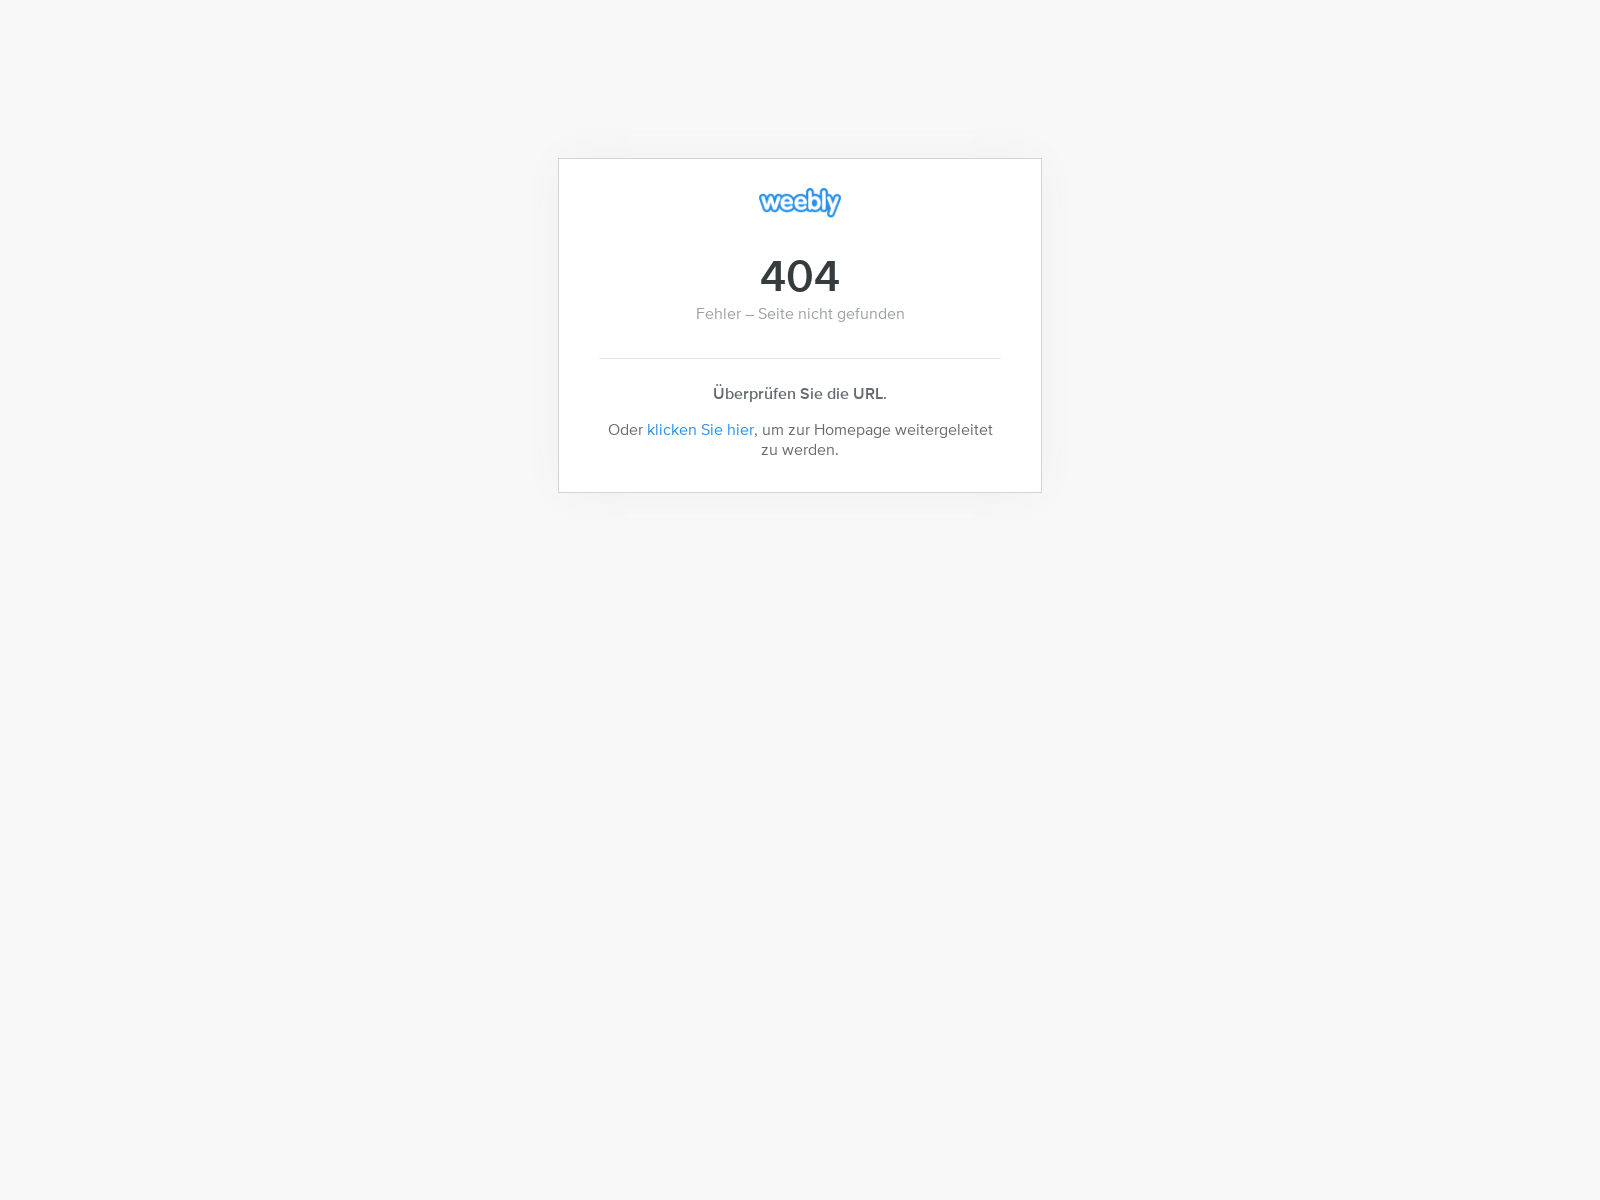



https://tytrrfgfg.weebly.com/ at 2023-03-28T14:03:14.727Z via https://urlscan.io/screenshots/905352f7-7e17-404f-92a7-37f0fd09a16b.png


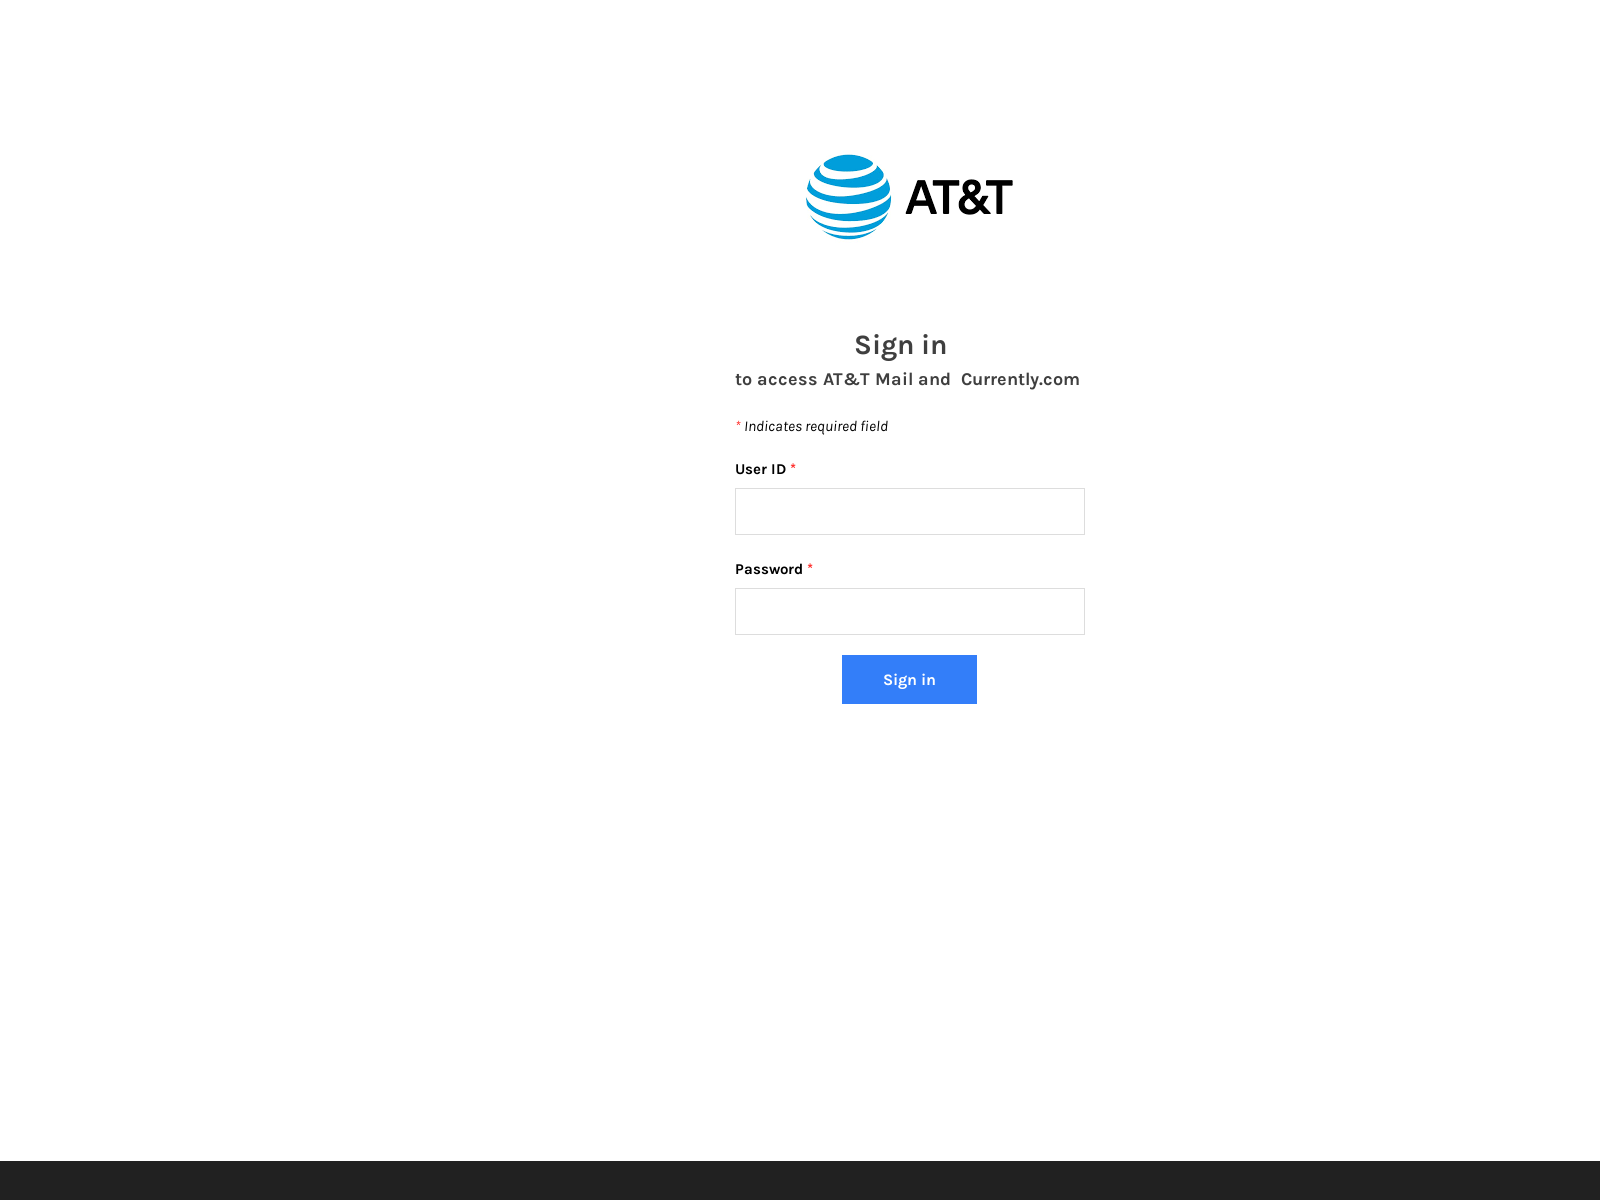



https://veilig-90.lu-490.ru/01/6.php at 2023-03-12T12:25:32.975Z via https://urlscan.io/screenshots/72c5d423-8f90-4f49-a62d-b73f99318662.png


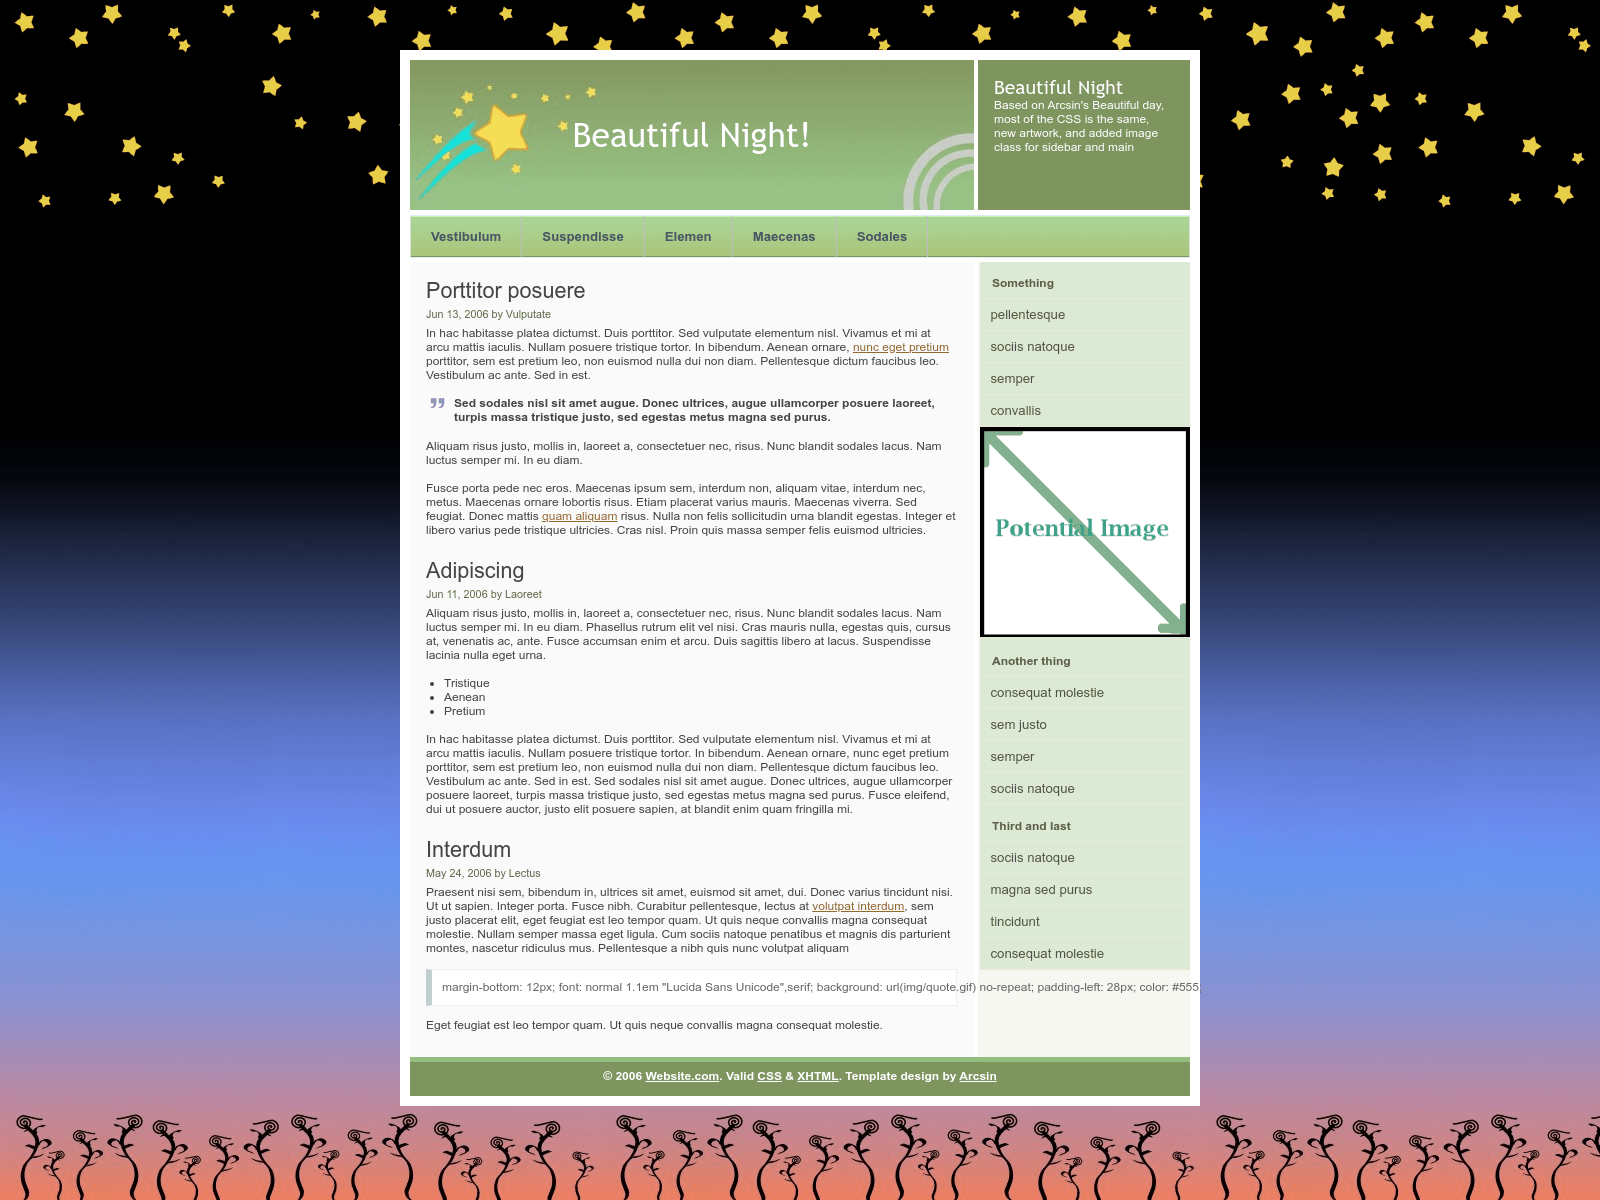



http://reliancematrrix.com/ at 2023-04-11T08:59:45.825Z via https://urlscan.io/screenshots/4f4be164-9945-4fd9-9df8-84b82ace1acb.png


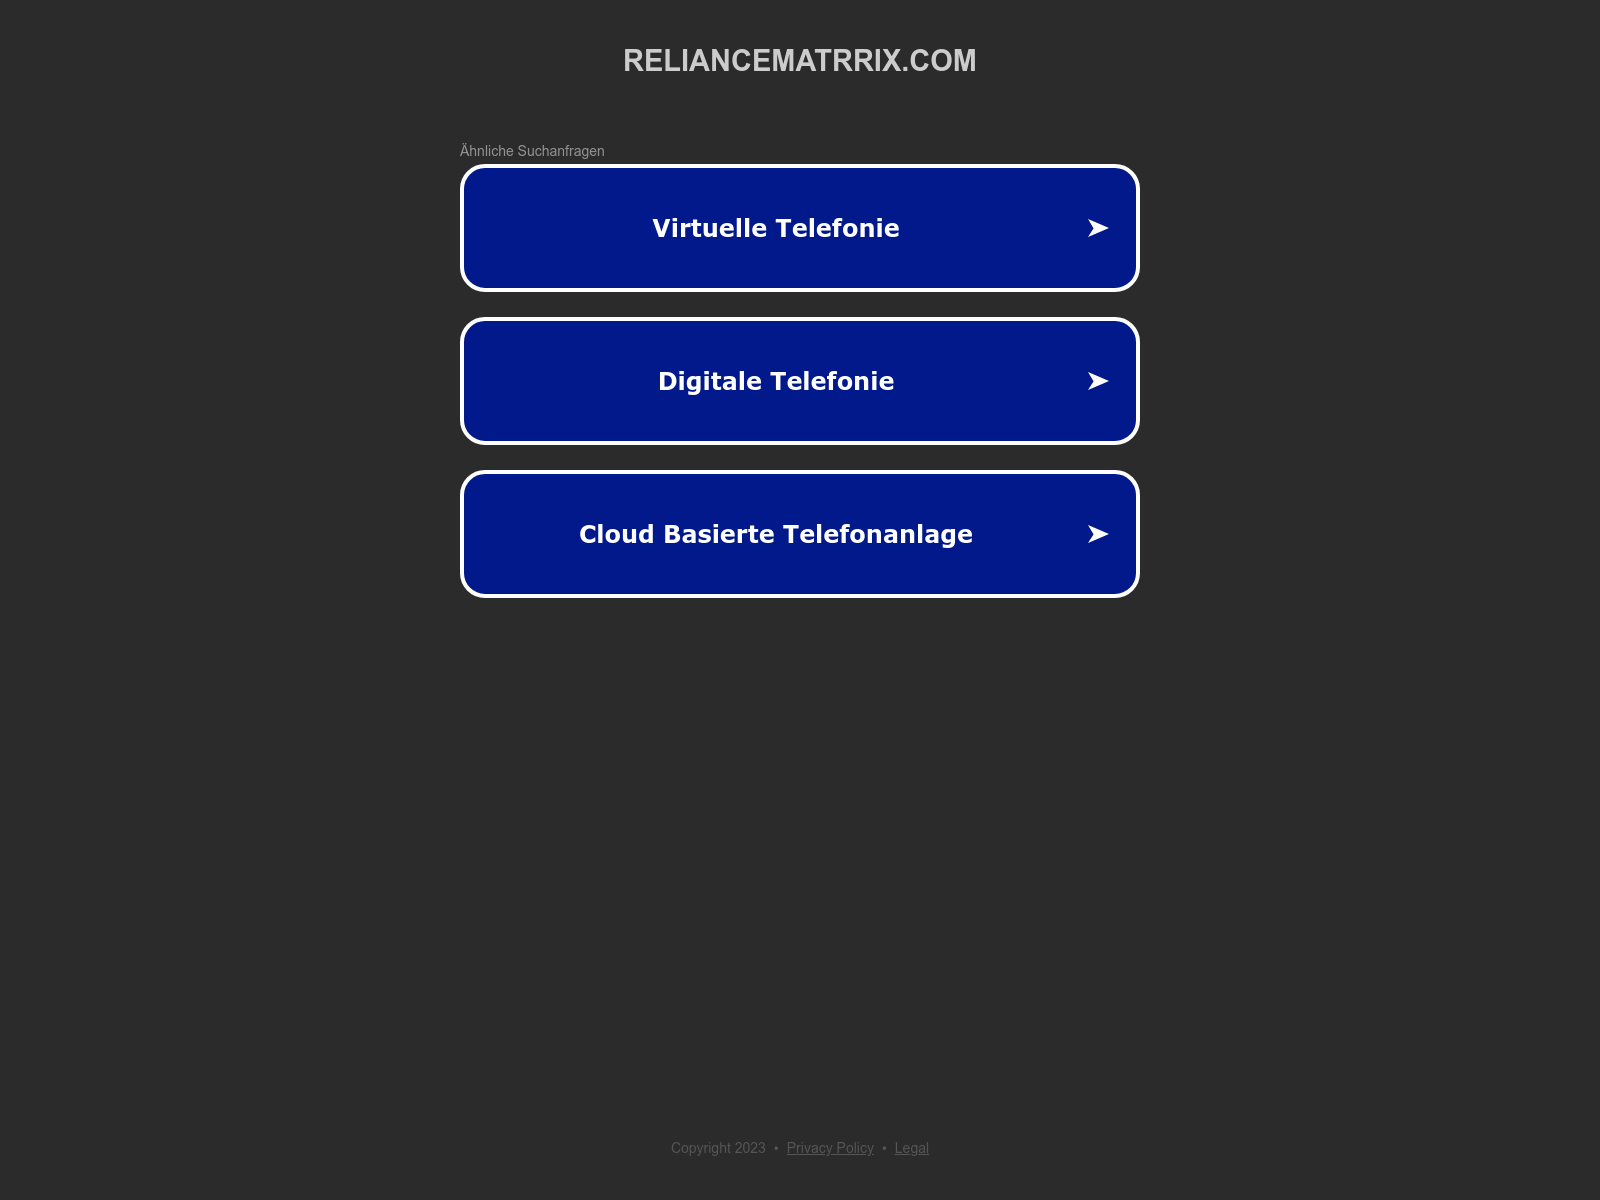



http://reliancematrrix.com/ at 2023-04-10T21:31:39.952Z via https://urlscan.io/screenshots/3224edba-fba8-47cb-be6c-16f5df8415d9.png


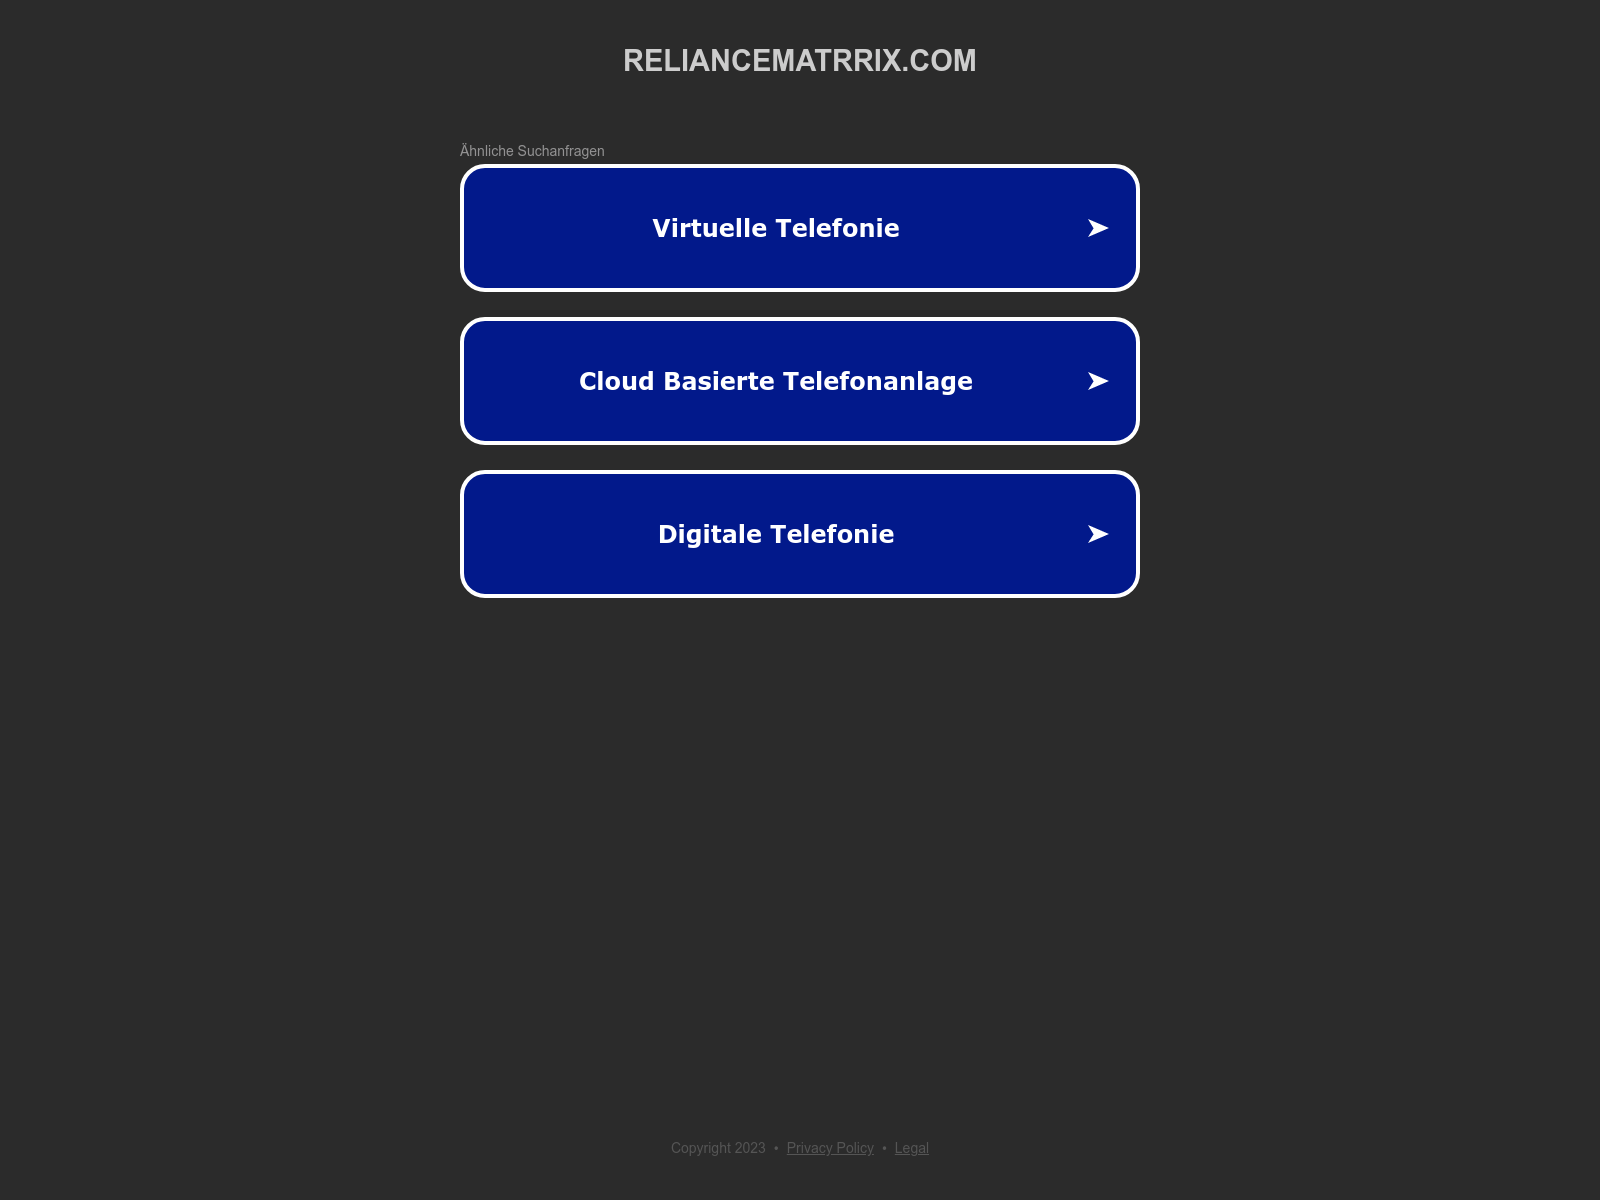



http://reliancematrrix.com/ at 2023-04-09T09:07:26.738Z via https://urlscan.io/screenshots/4083ed66-9a4b-4acf-a209-a41e7c8564a8.png


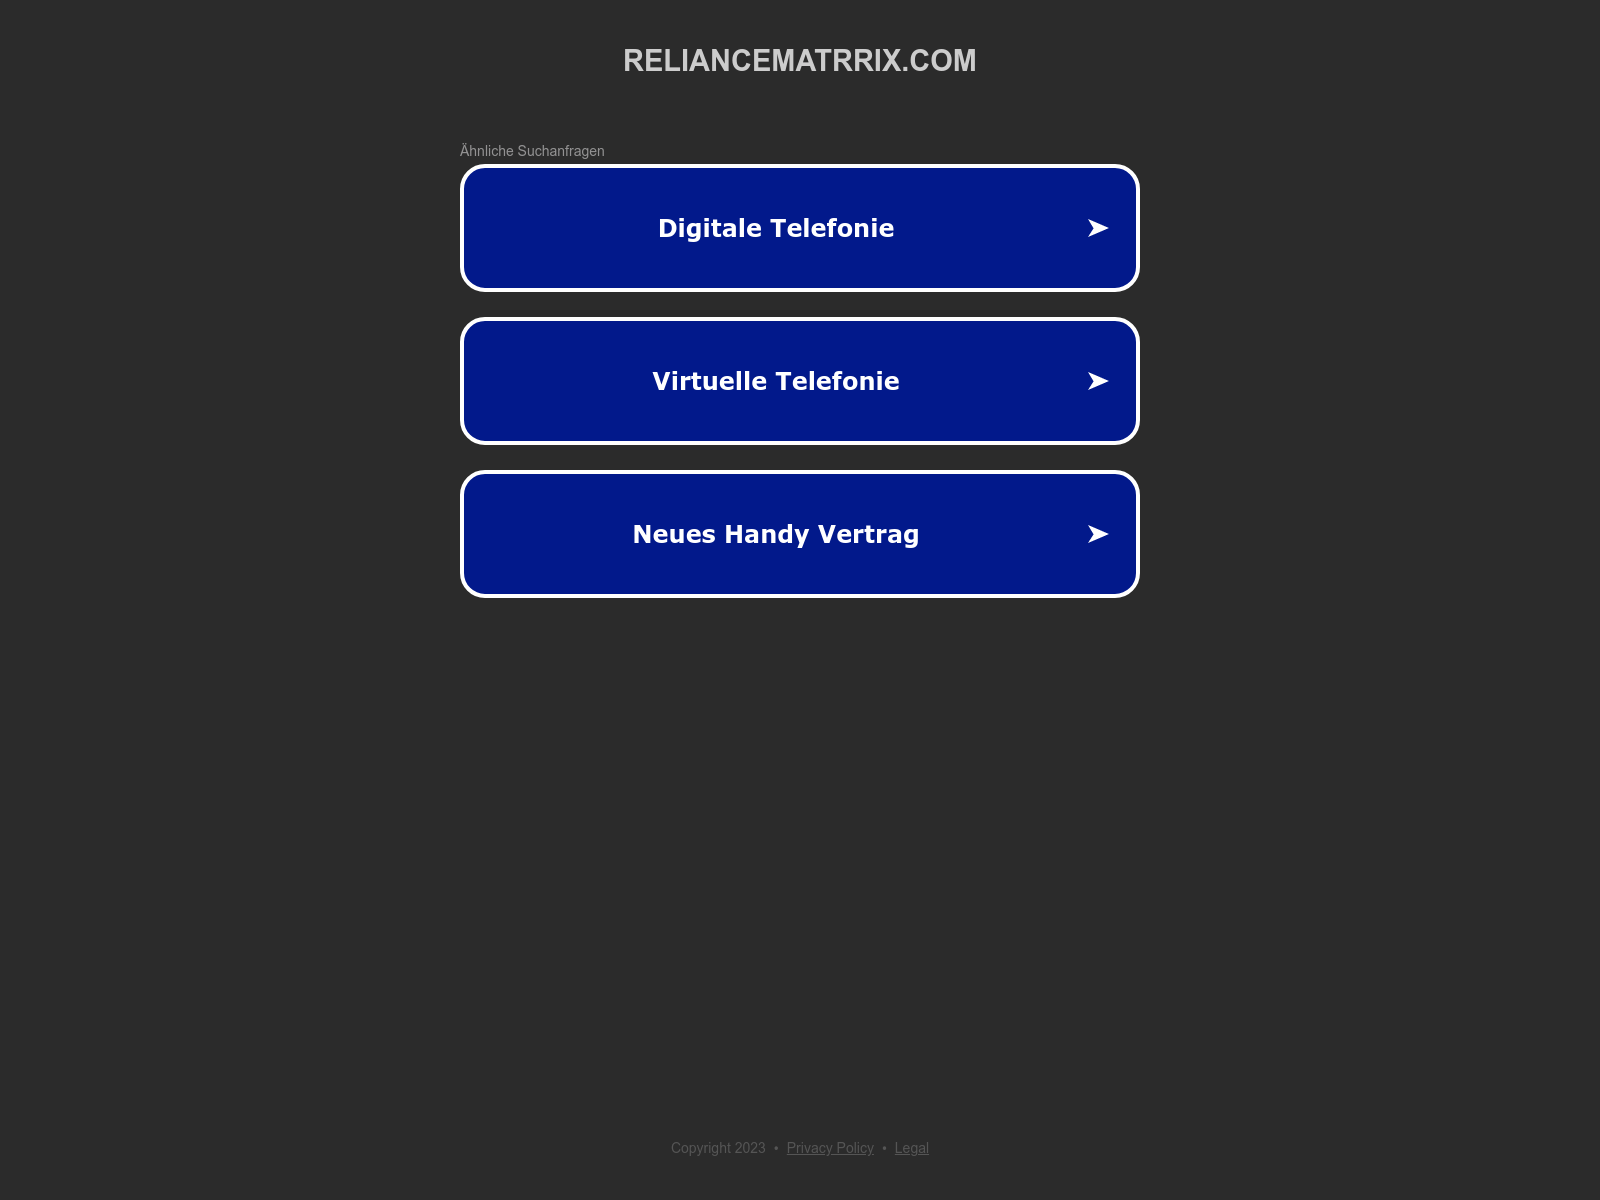



http://reliancematrrix.com/ at 2023-04-07T09:12:58.912Z via https://urlscan.io/screenshots/96d1aaae-d2f6-4fb0-9ef5-9045995bd80f.png


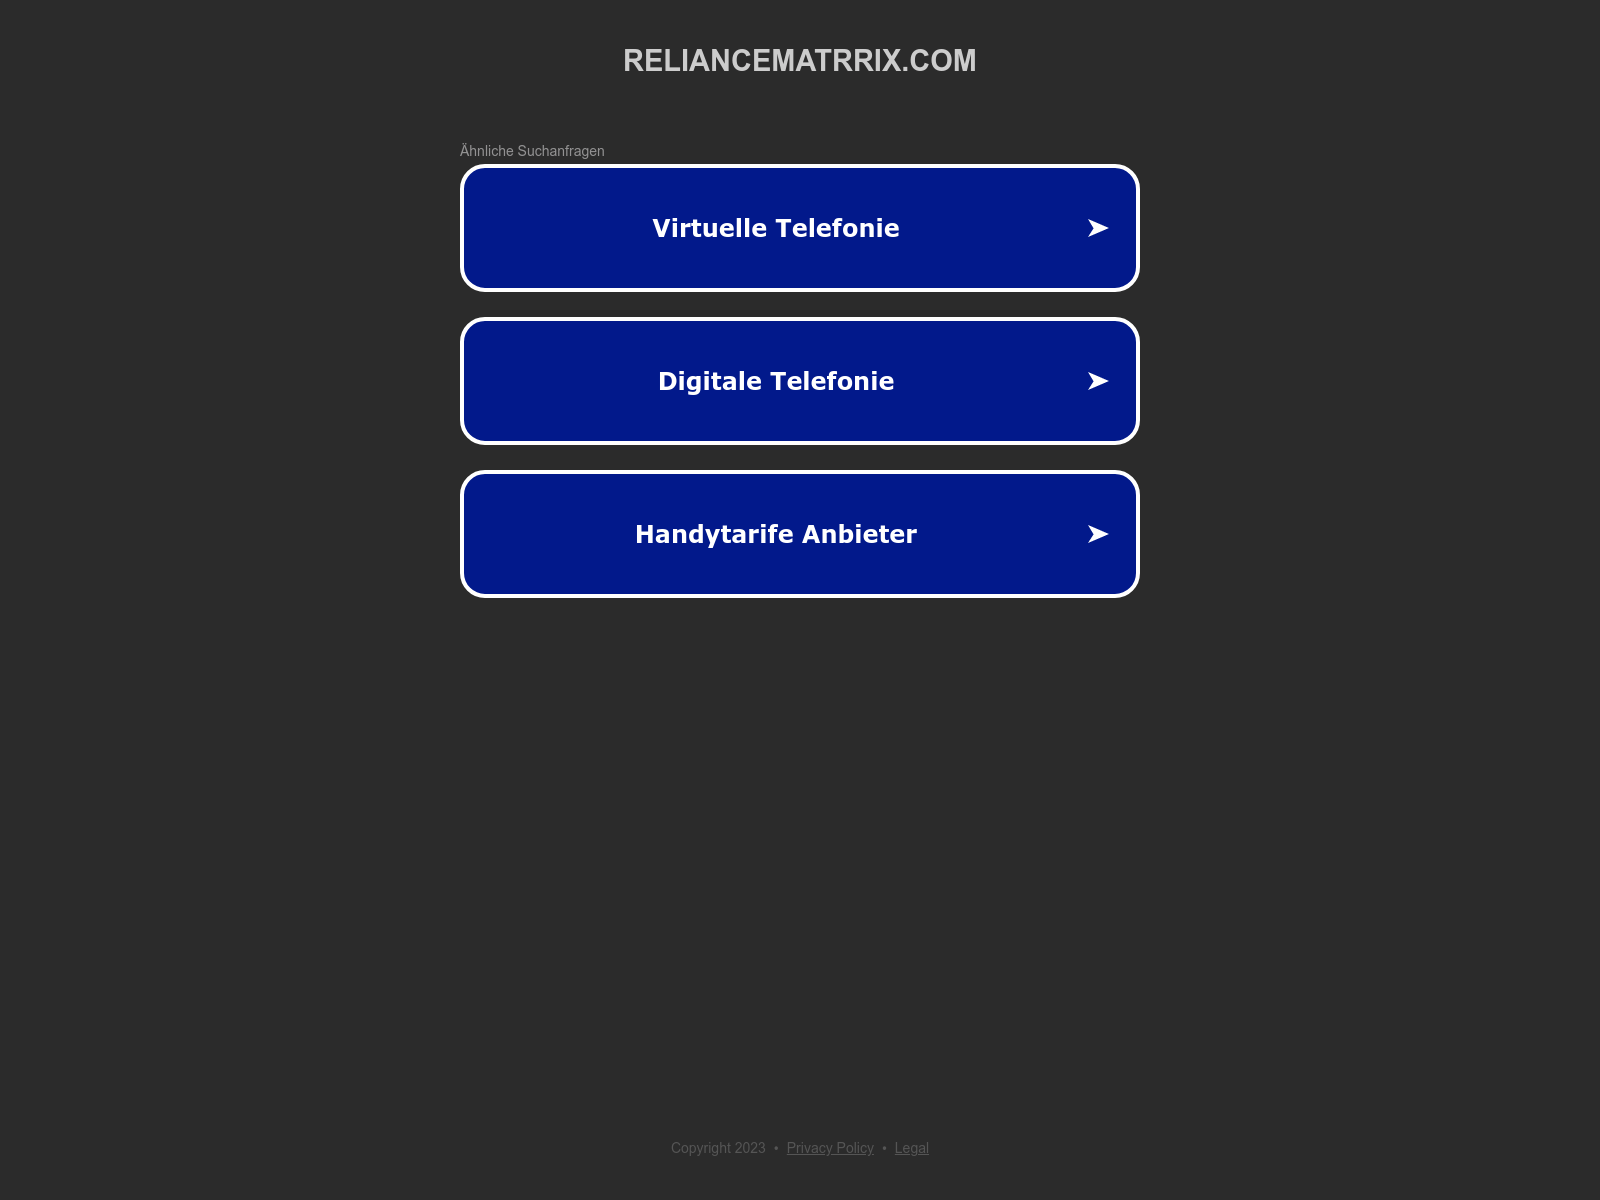



http://reliancematrrix.com/ at 2023-04-03T09:18:25.620Z via https://urlscan.io/screenshots/bbfe79c9-8083-44f9-9d04-54c3144b1a5d.png


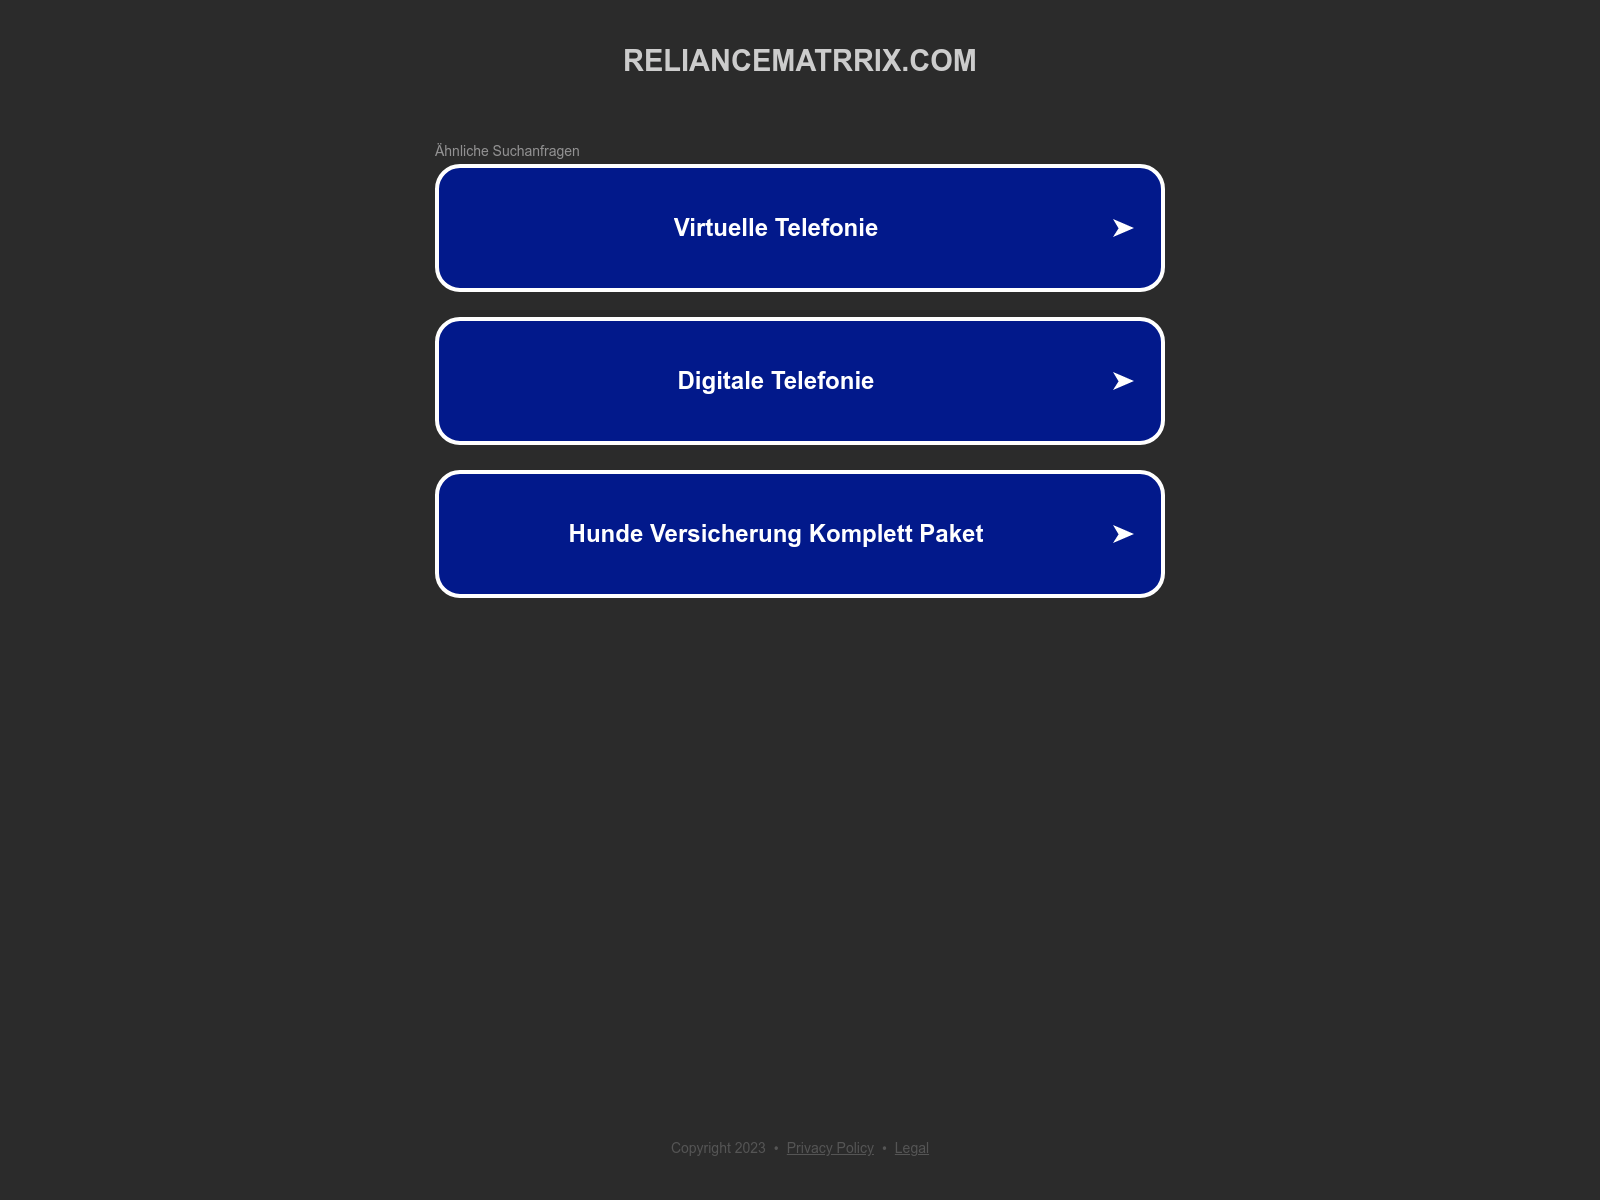



http://reliancematrrix.com/ at 2023-04-02T09:36:11.053Z via https://urlscan.io/screenshots/db4b07fe-a47e-44ad-b52b-4115d4d9ad20.png


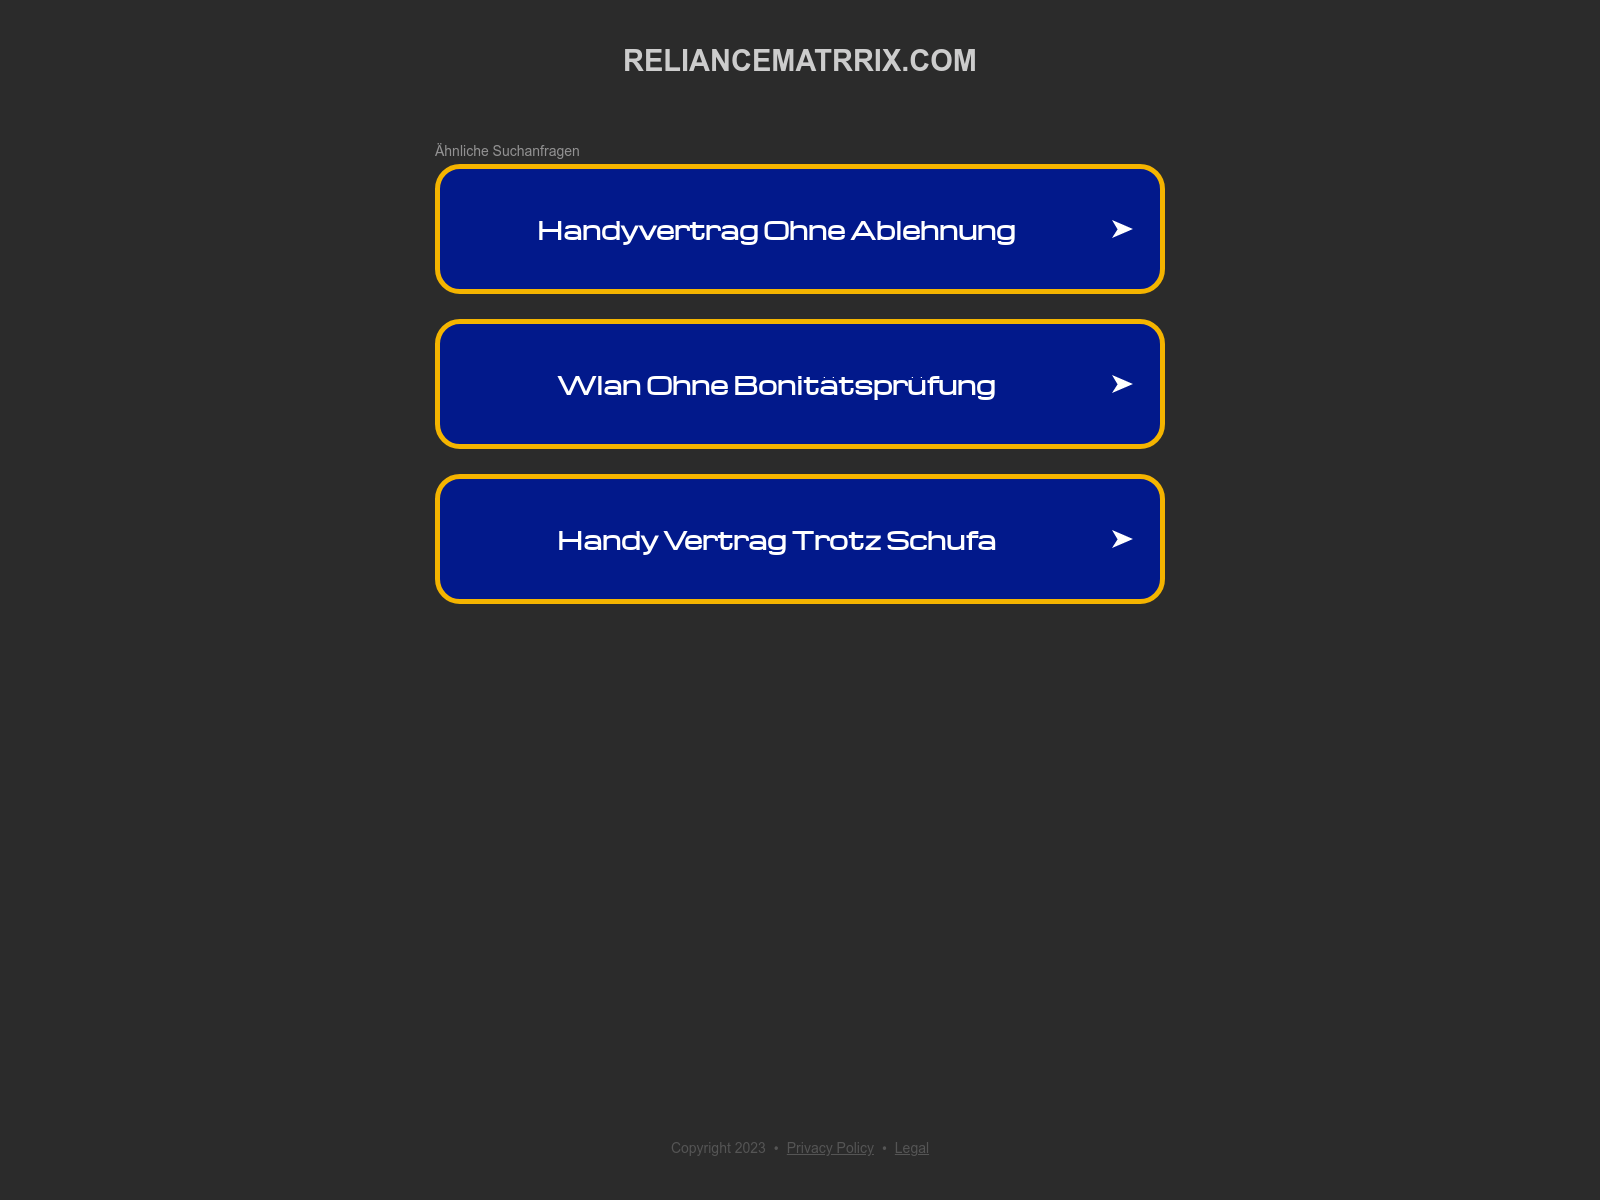



http://reliancematrrix.com/ at 2023-04-01T09:30:29.919Z via https://urlscan.io/screenshots/8c0ac0ab-6e1a-4119-927e-2c5f4702b627.png


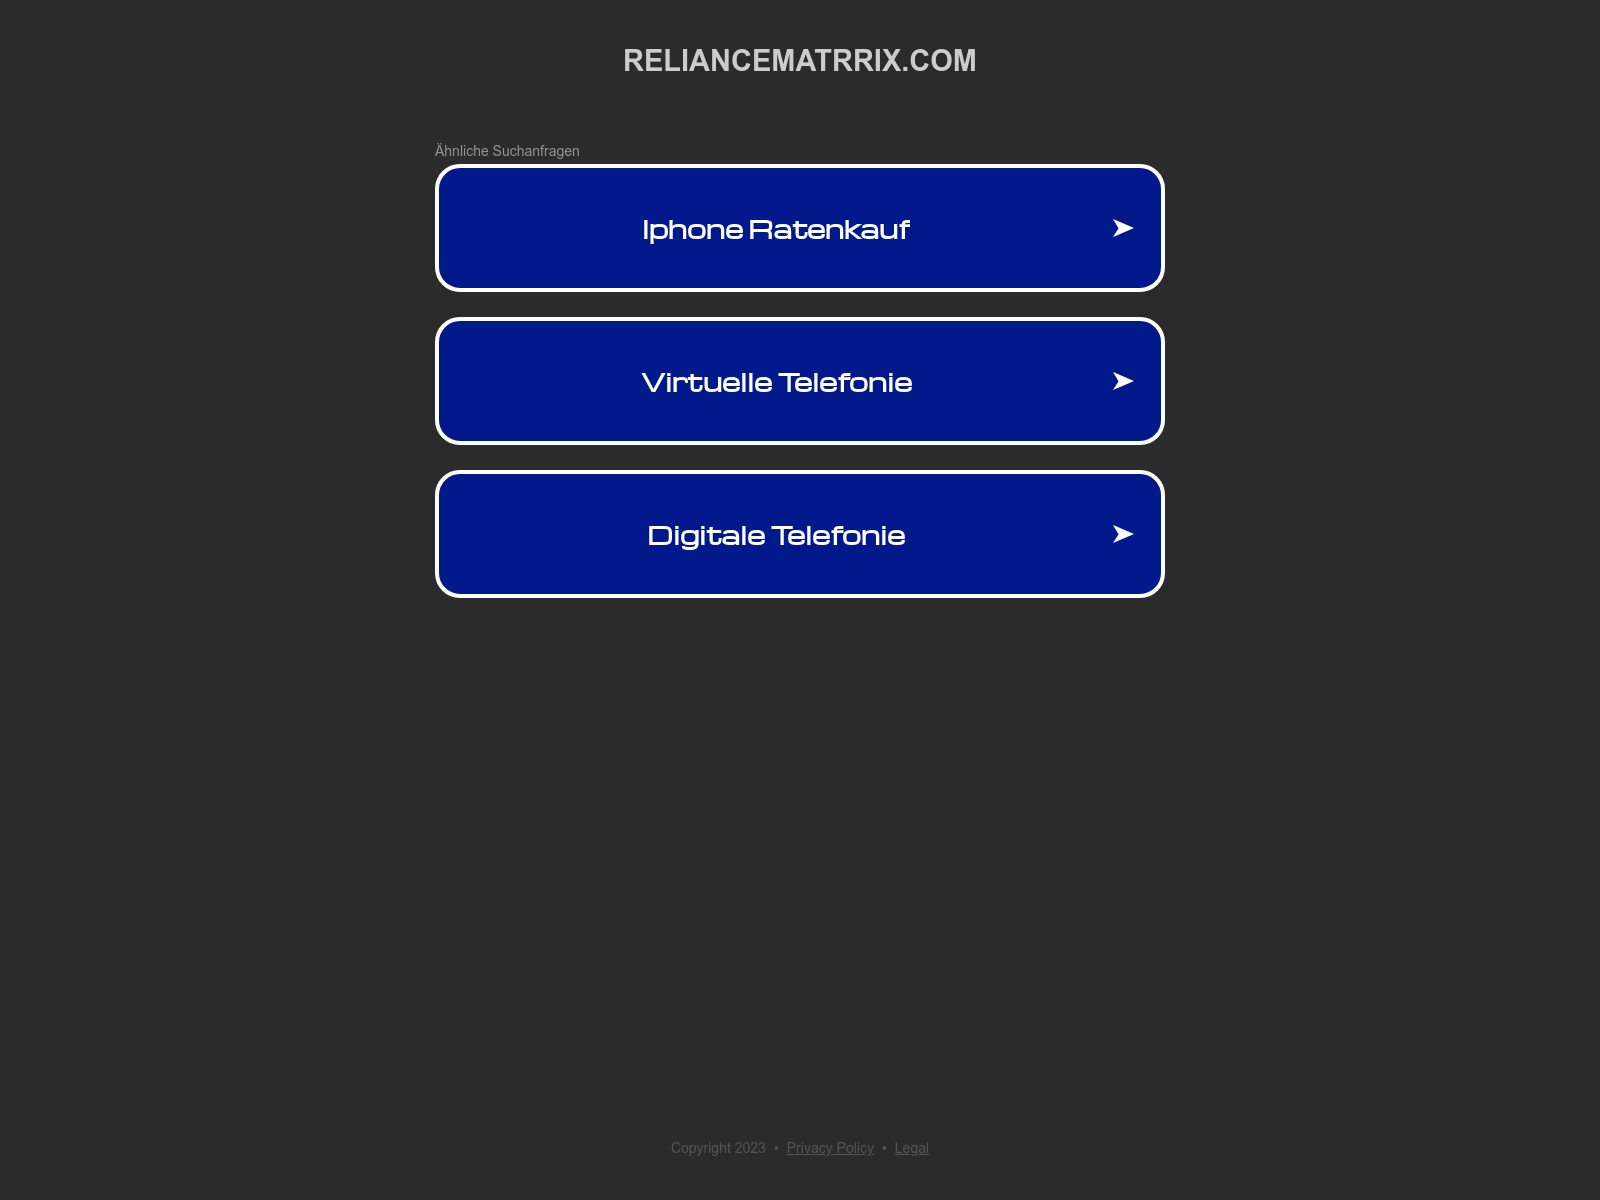



http://reliancematrrix.com/ at 2023-03-31T19:44:20.833Z via https://urlscan.io/screenshots/298d0993-2499-49a9-9781-61d8d7684008.png


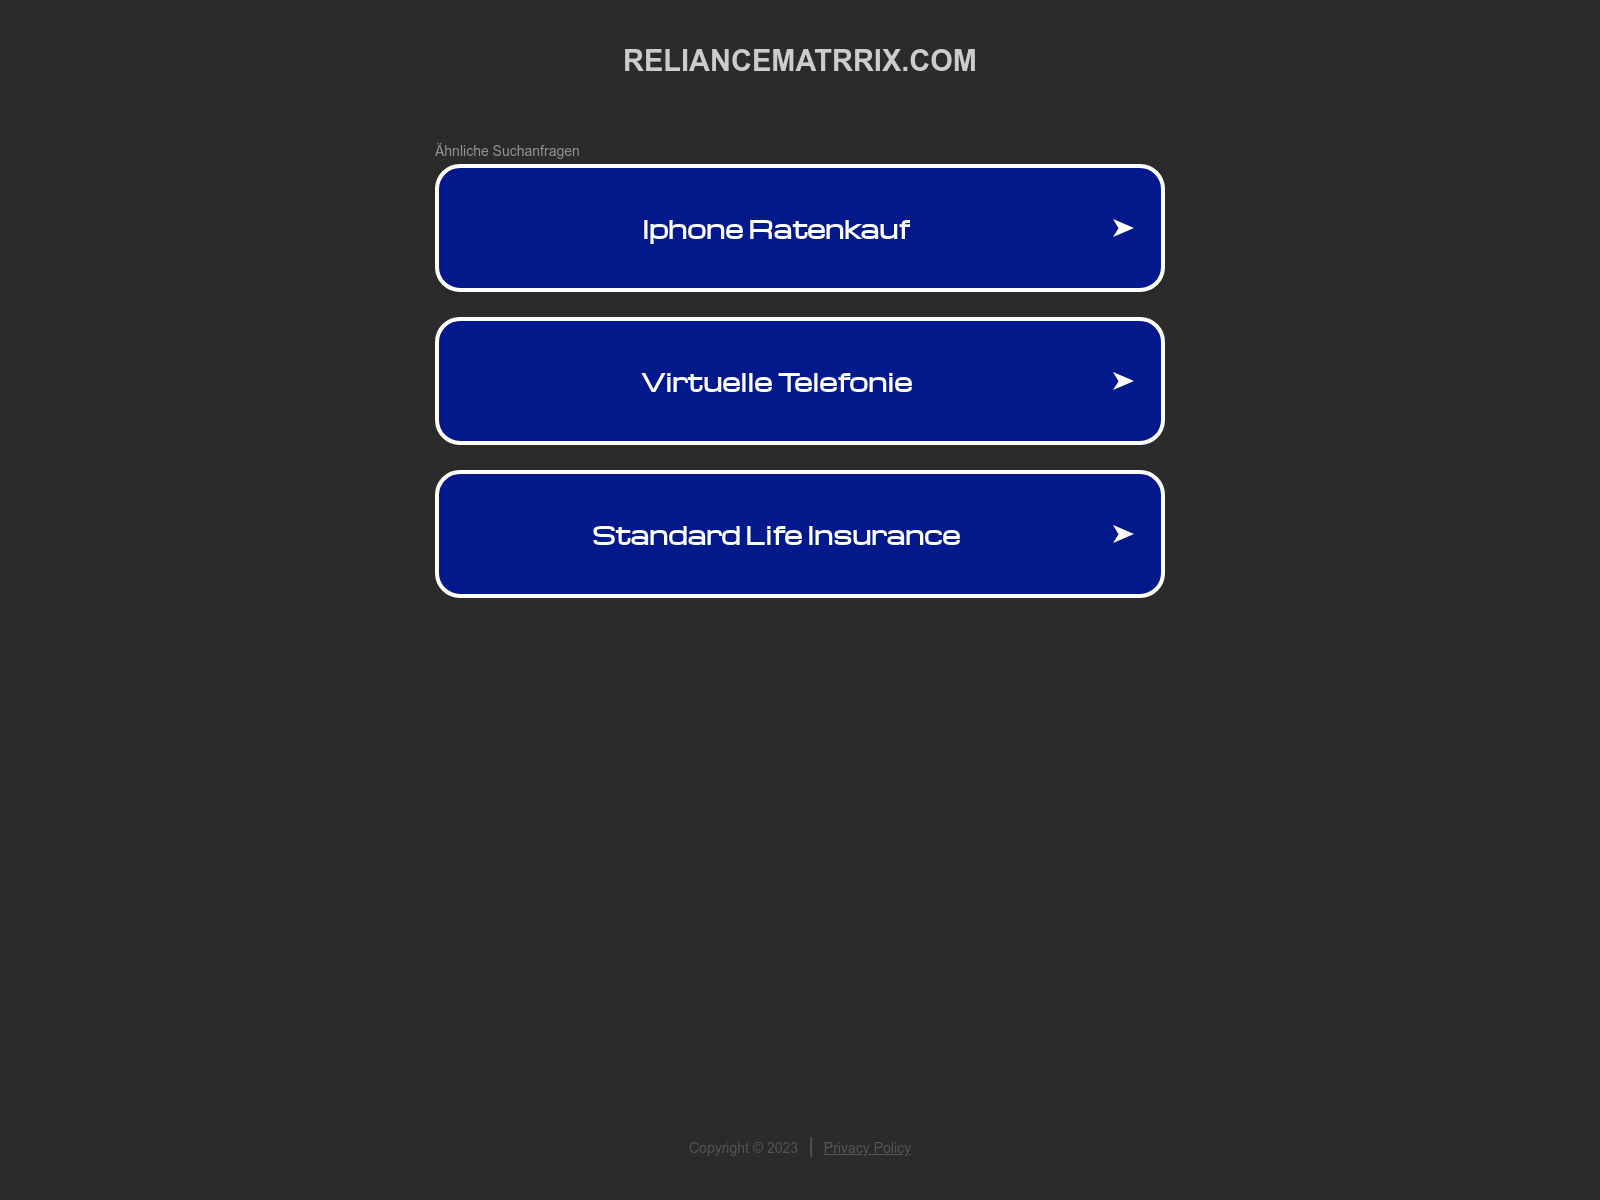



http://reliancematrrix.com/ at 2023-03-31T09:31:24.431Z via https://urlscan.io/screenshots/0fc32446-2900-4fbf-b2f3-55799c65eaba.png


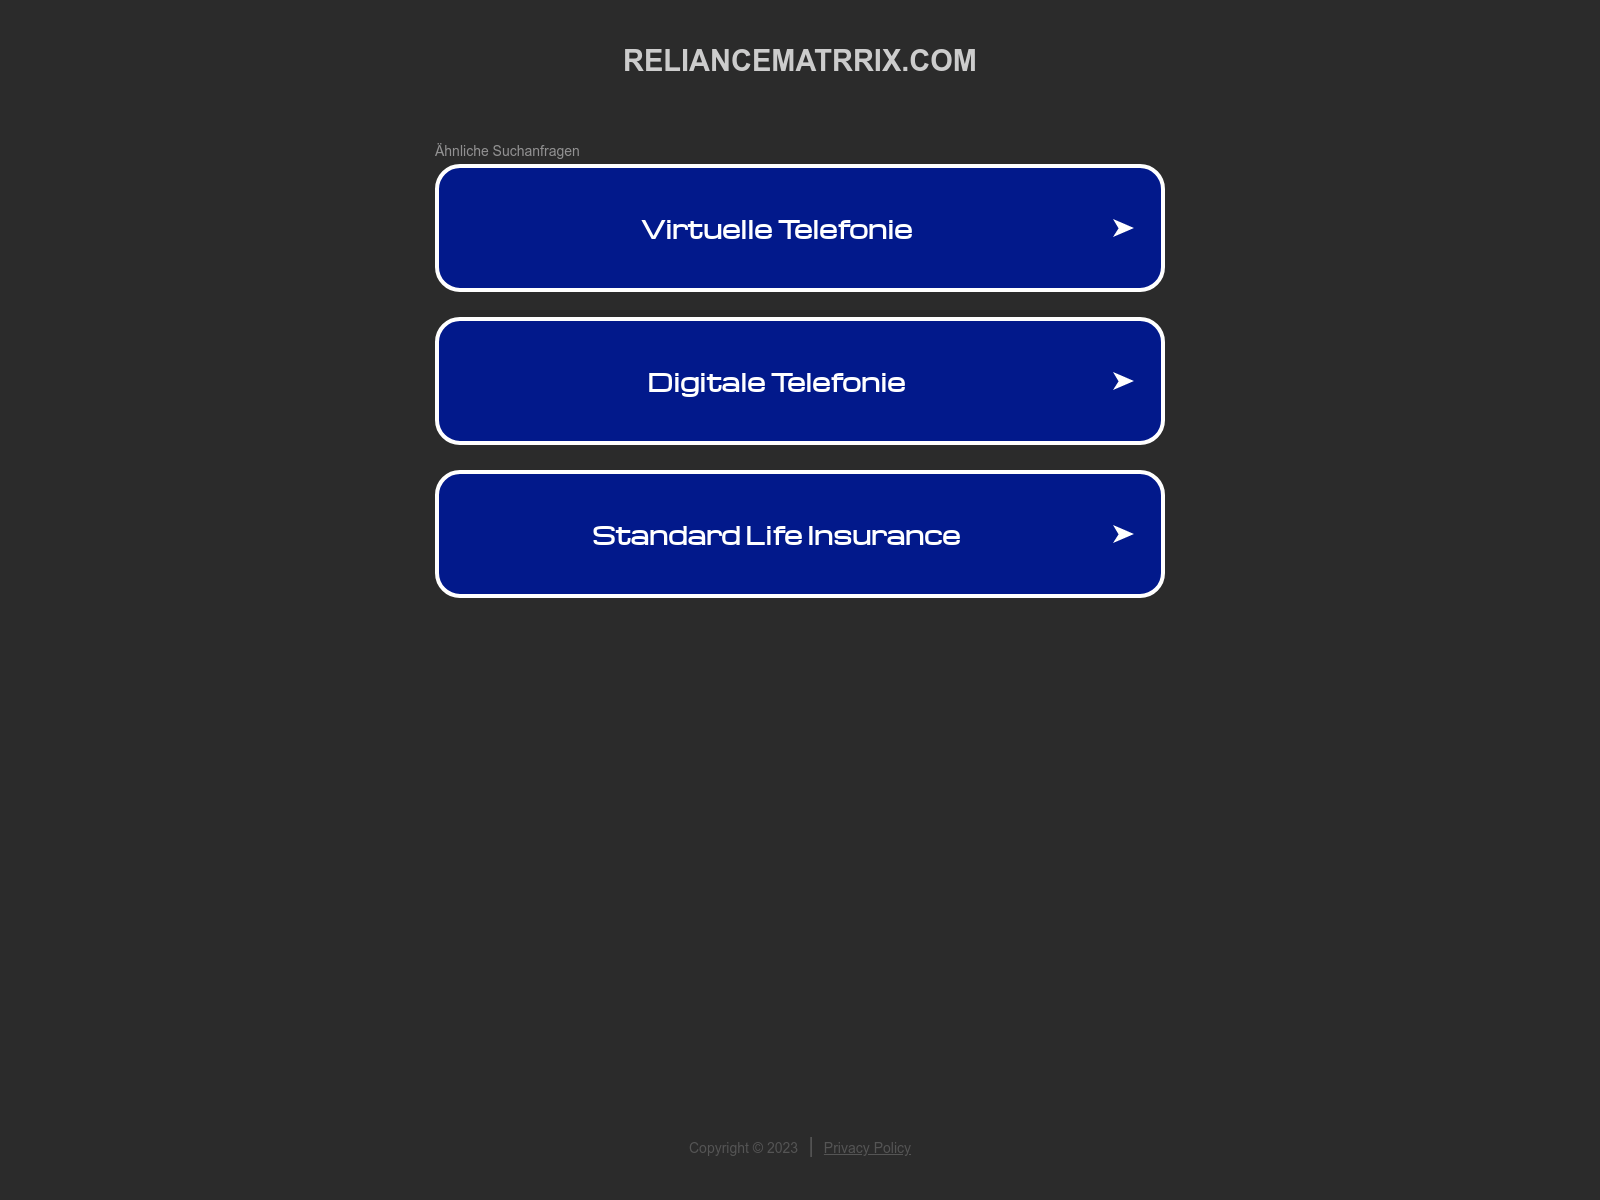



http://reliancematrrix.com/ at 2023-03-31T07:52:26.926Z via https://urlscan.io/screenshots/ee15286c-62da-456d-95ea-666c2438a45e.png


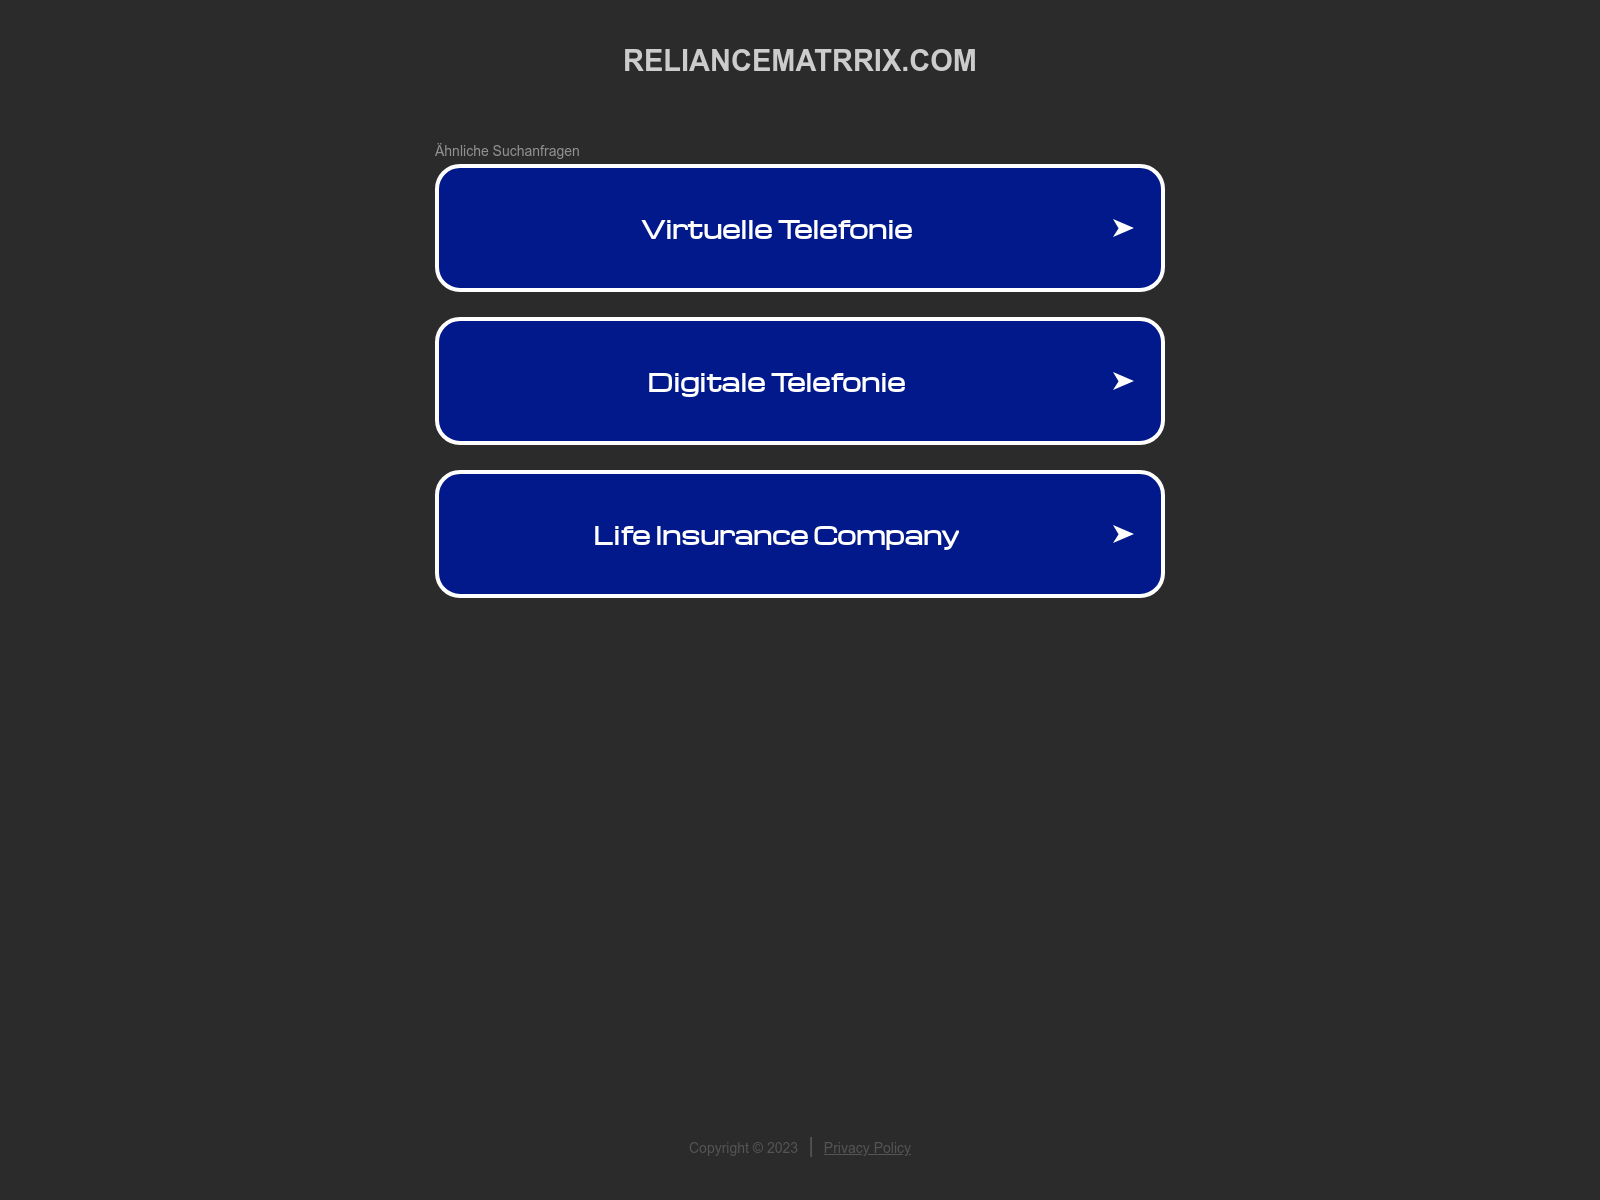



http://reliancematrrix.com/ at 2023-03-30T09:17:00.904Z via https://urlscan.io/screenshots/1ed669e0-4254-46f2-913c-9346bf8d92e2.png


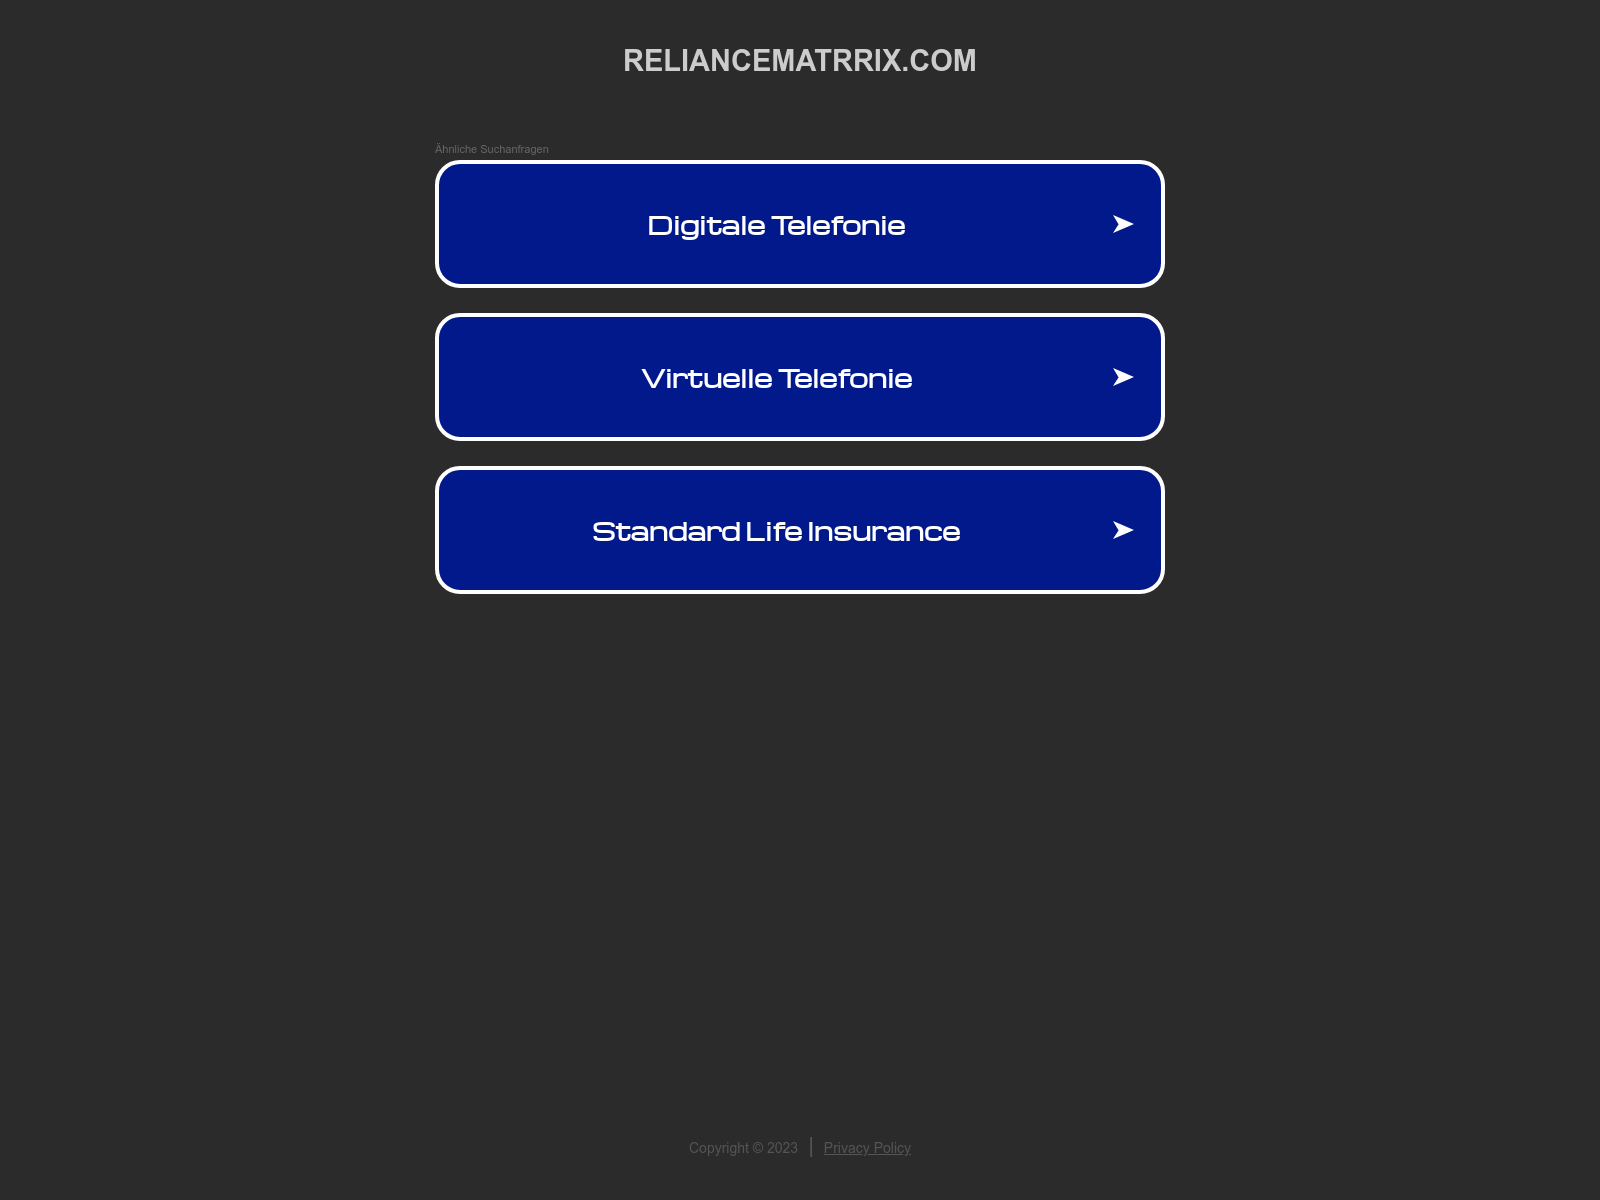



http://reliancematrrix.com/ at 2023-03-29T13:31:23.918Z via https://urlscan.io/screenshots/3b381286-34e5-4caa-83fe-6300d4bb9661.png


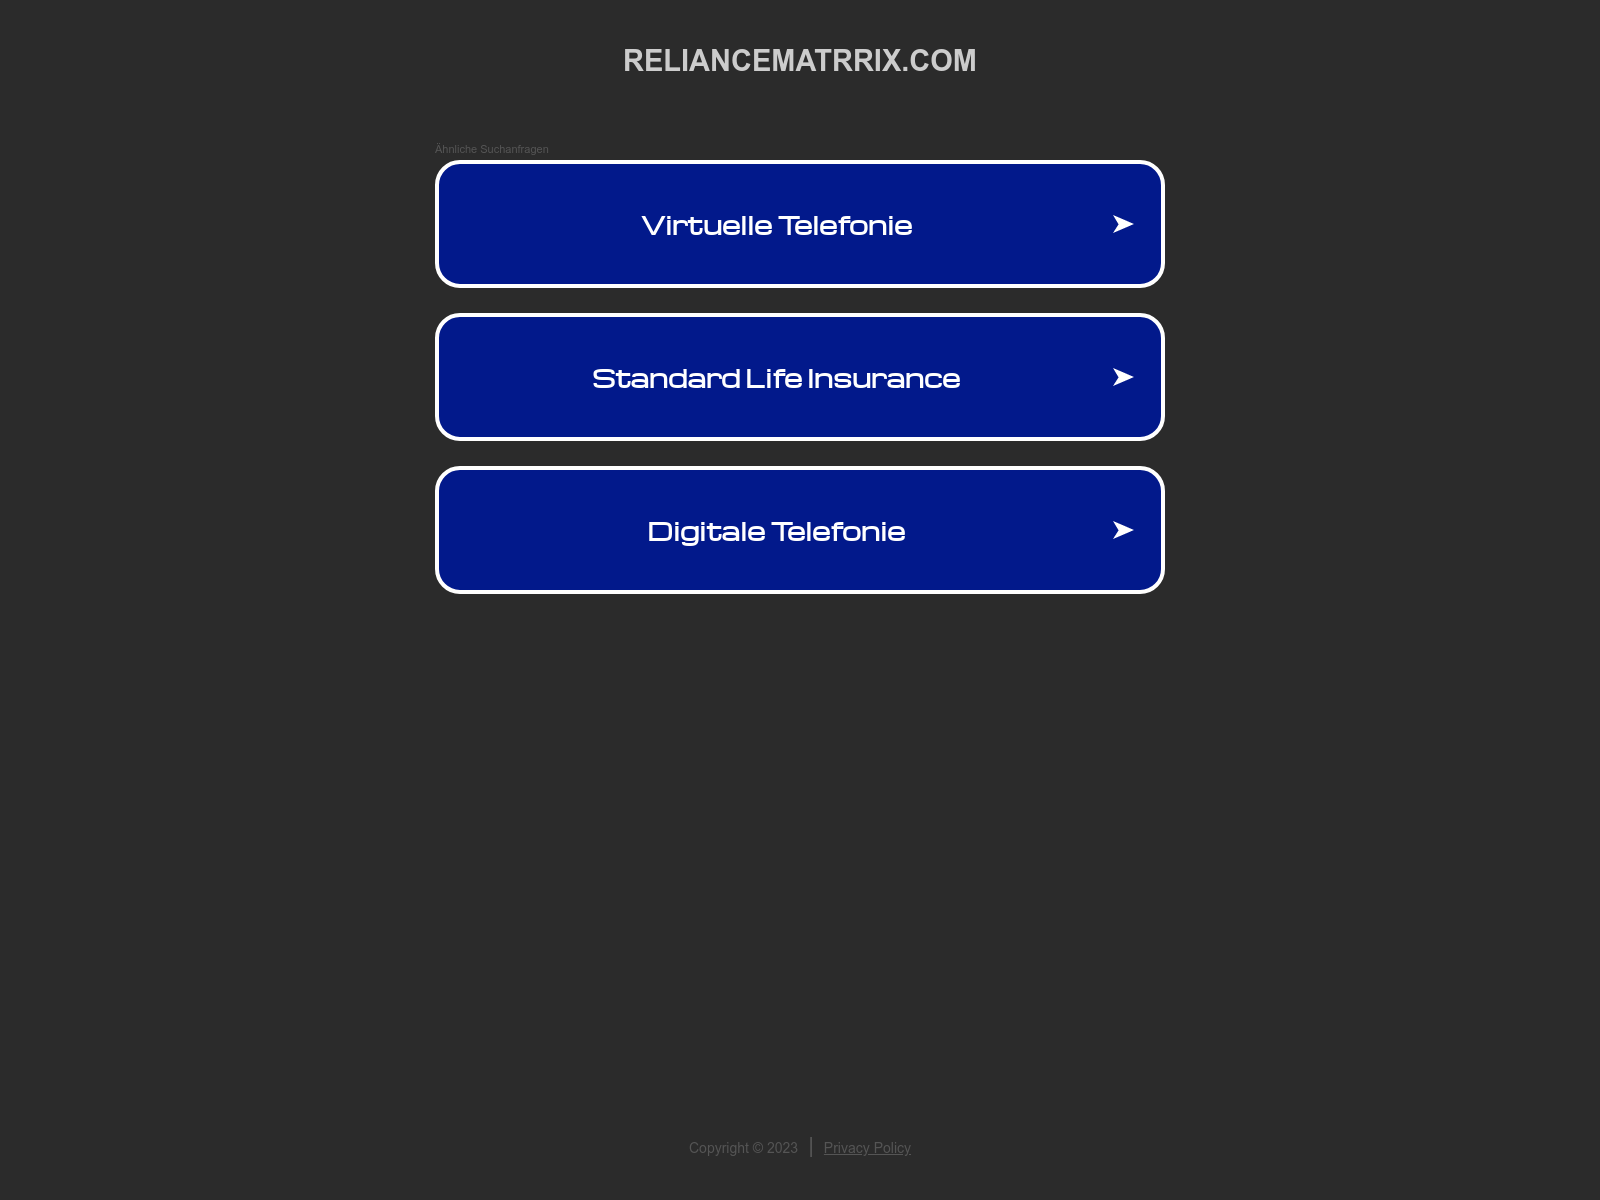



http://reliancematrrix.com/ at 2023-03-29T09:16:50.944Z via https://urlscan.io/screenshots/5626a559-5608-458e-b7f3-538312e8fcb7.png


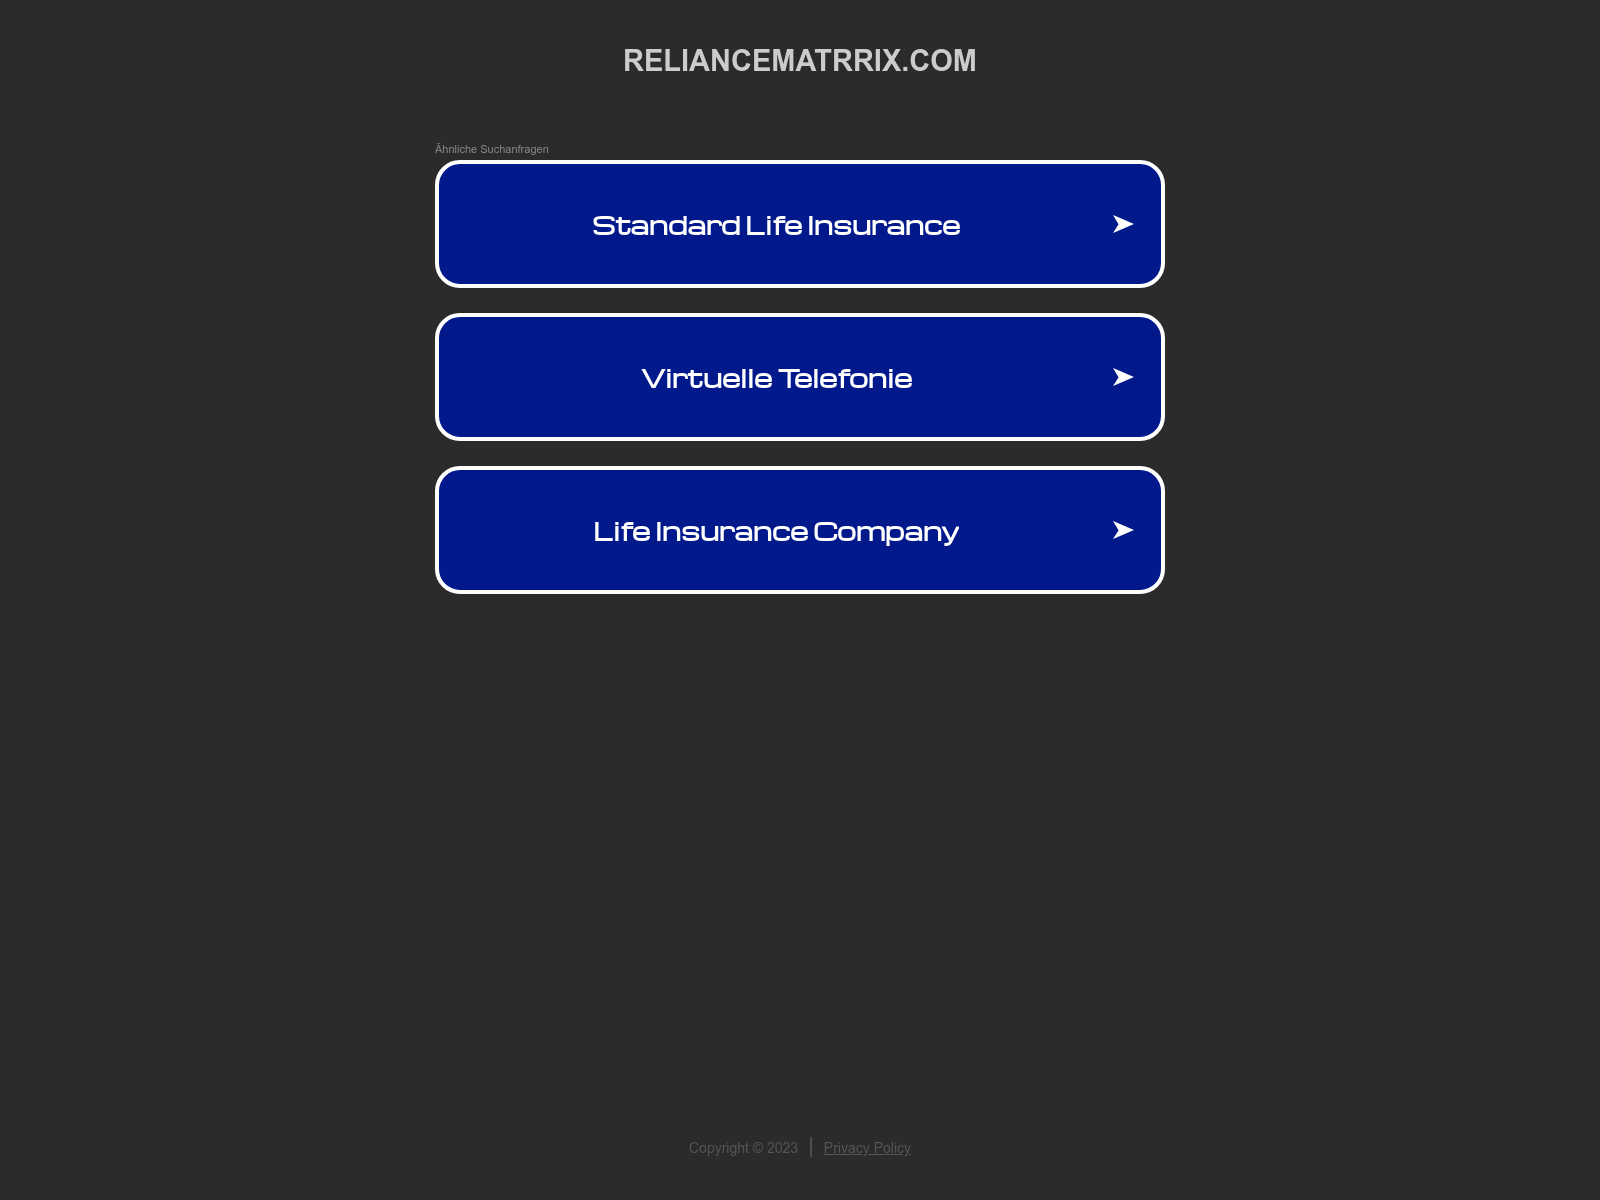



http://reliancematrrix.com/ at 2023-03-27T09:11:34.718Z via https://urlscan.io/screenshots/ba9707b1-2335-4de8-a893-0650bd70ecce.png


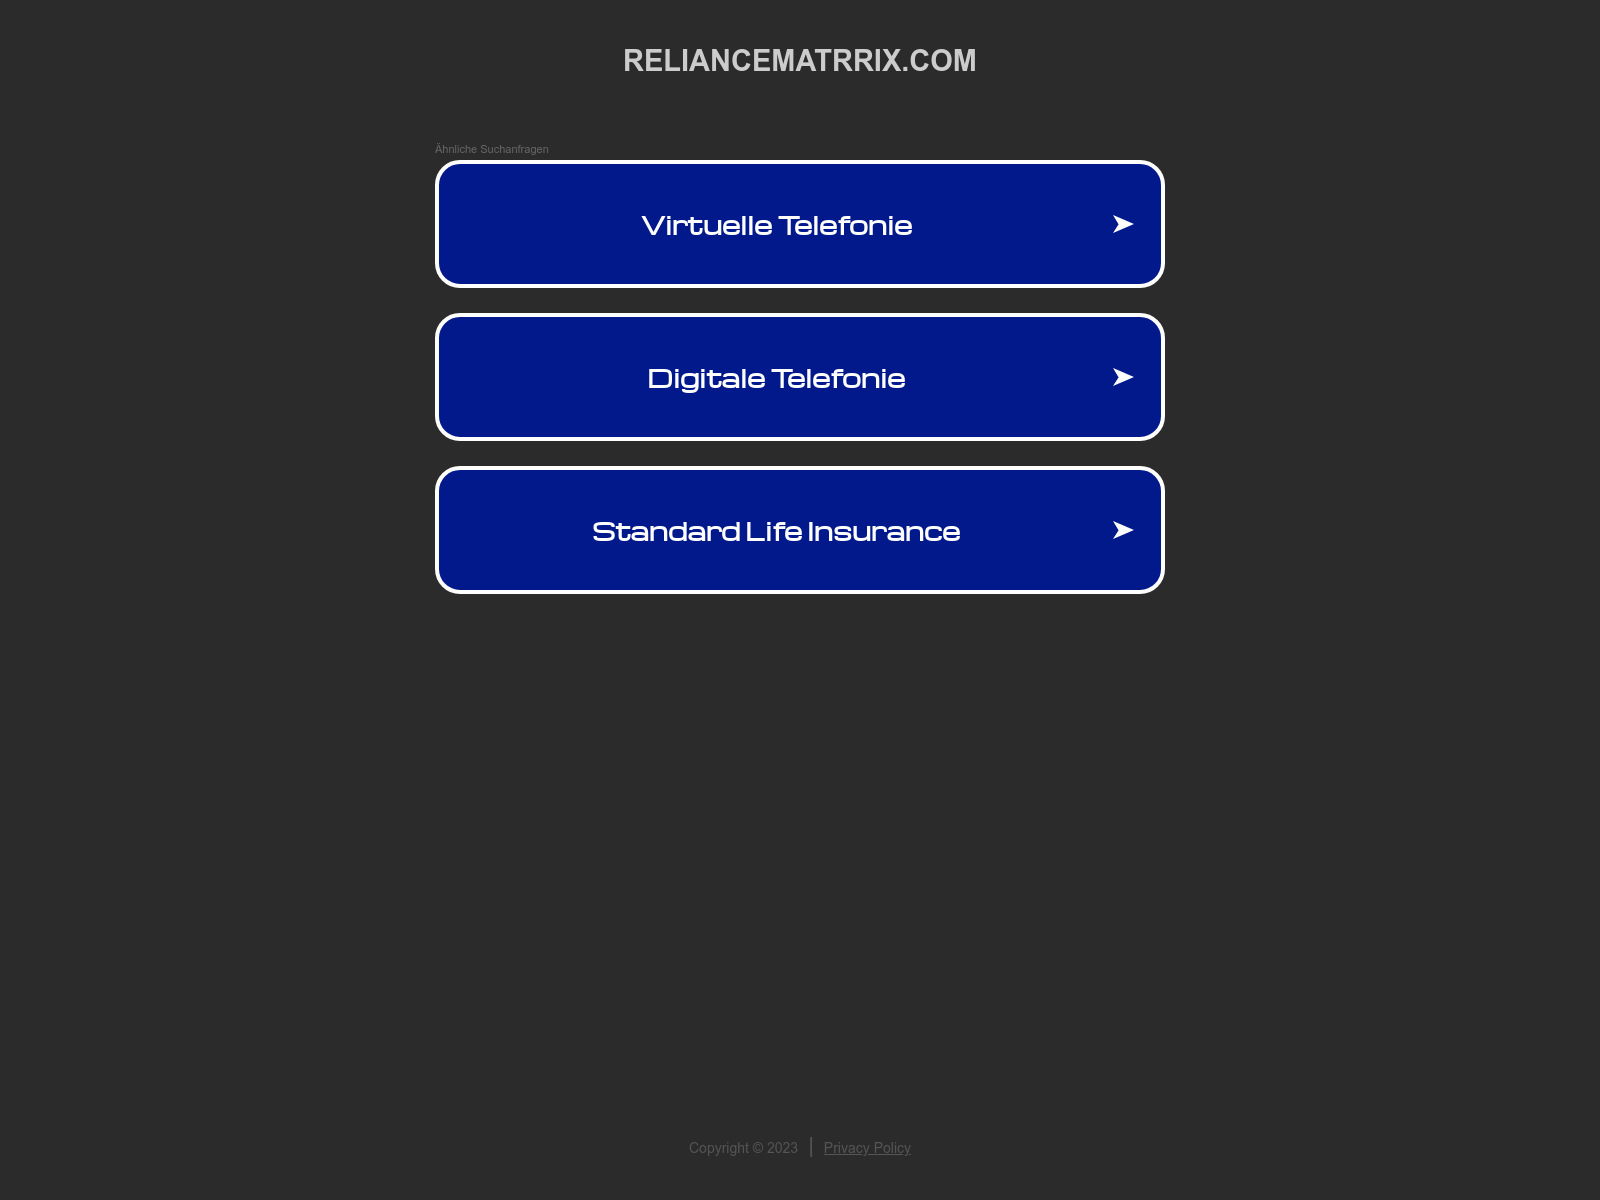



http://reliancematrrix.com/ at 2023-03-20T09:54:23.488Z via https://urlscan.io/screenshots/83af745e-6208-43ff-bfa9-8850a563c446.png


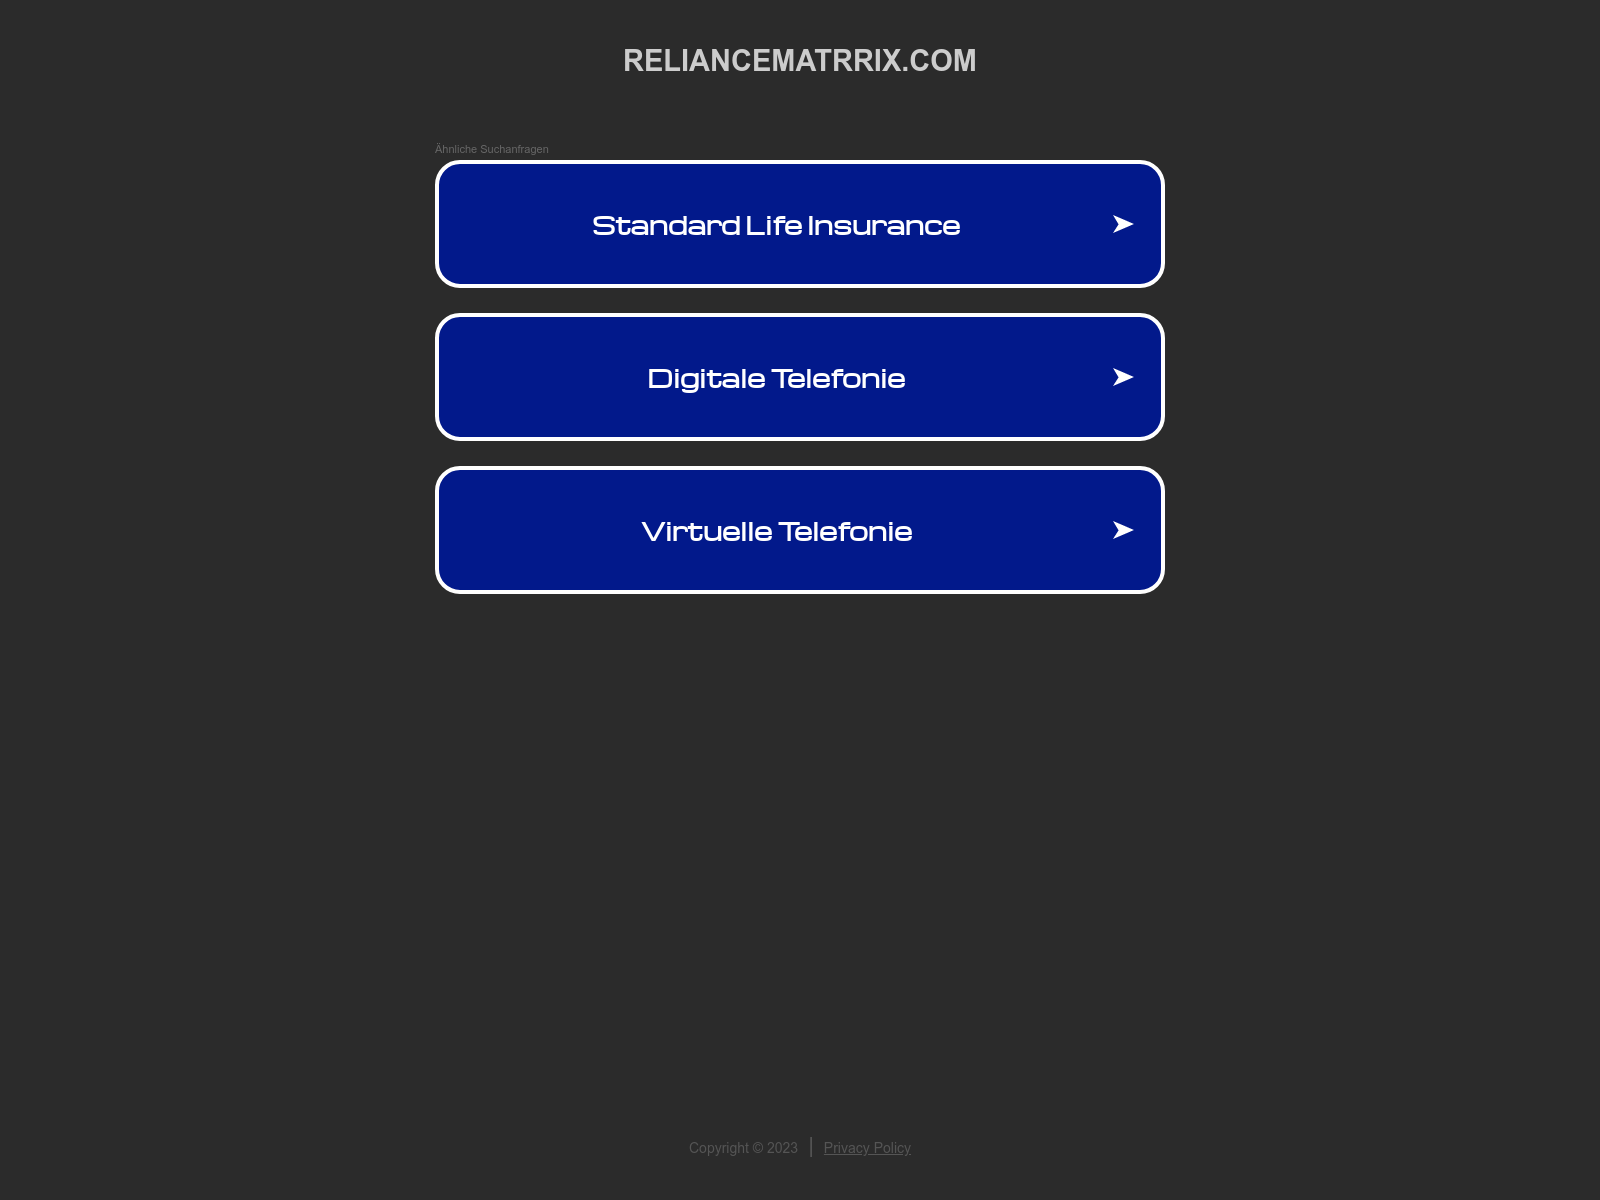



http://reliancematrrix.com/ at 2023-03-19T09:23:22.223Z via https://urlscan.io/screenshots/4008e08b-df40-4512-8050-9ae829d1e634.png


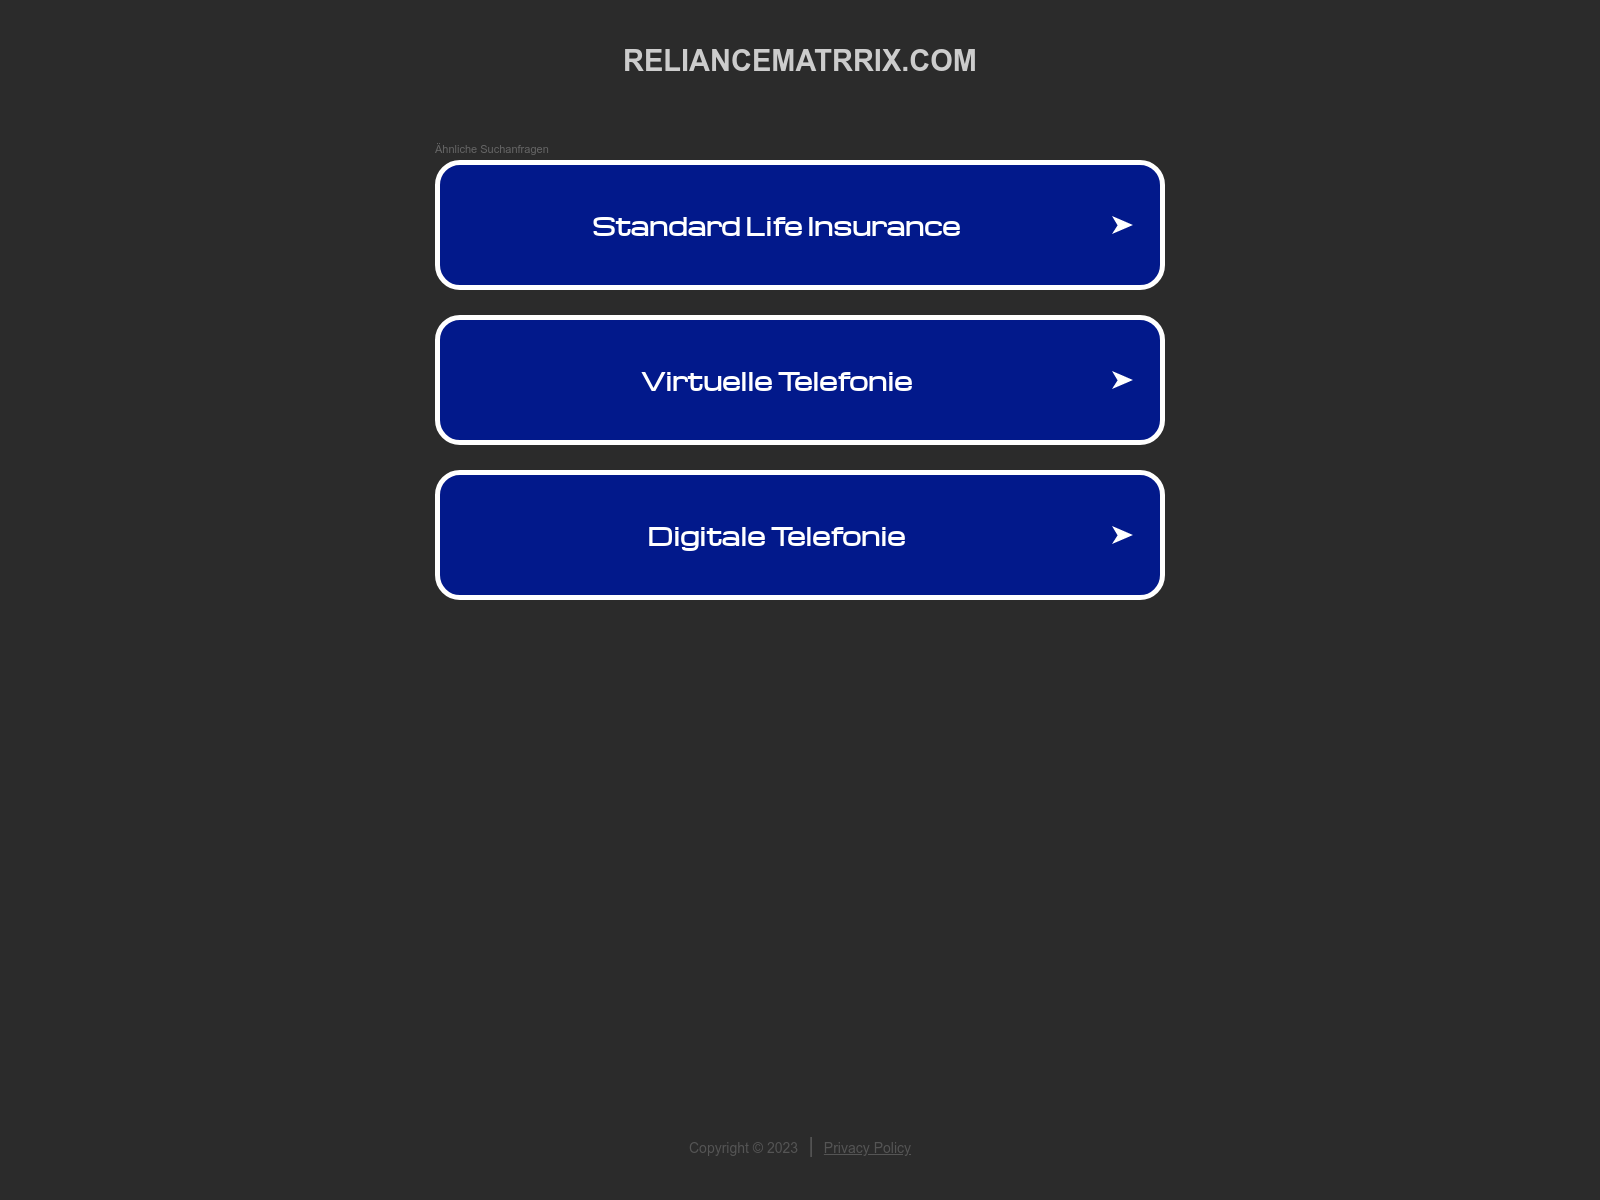



http://reliancematrrix.com/ at 2023-03-18T09:24:51.861Z via https://urlscan.io/screenshots/0b3259ec-f051-49ef-a910-f77b7883b8bb.png


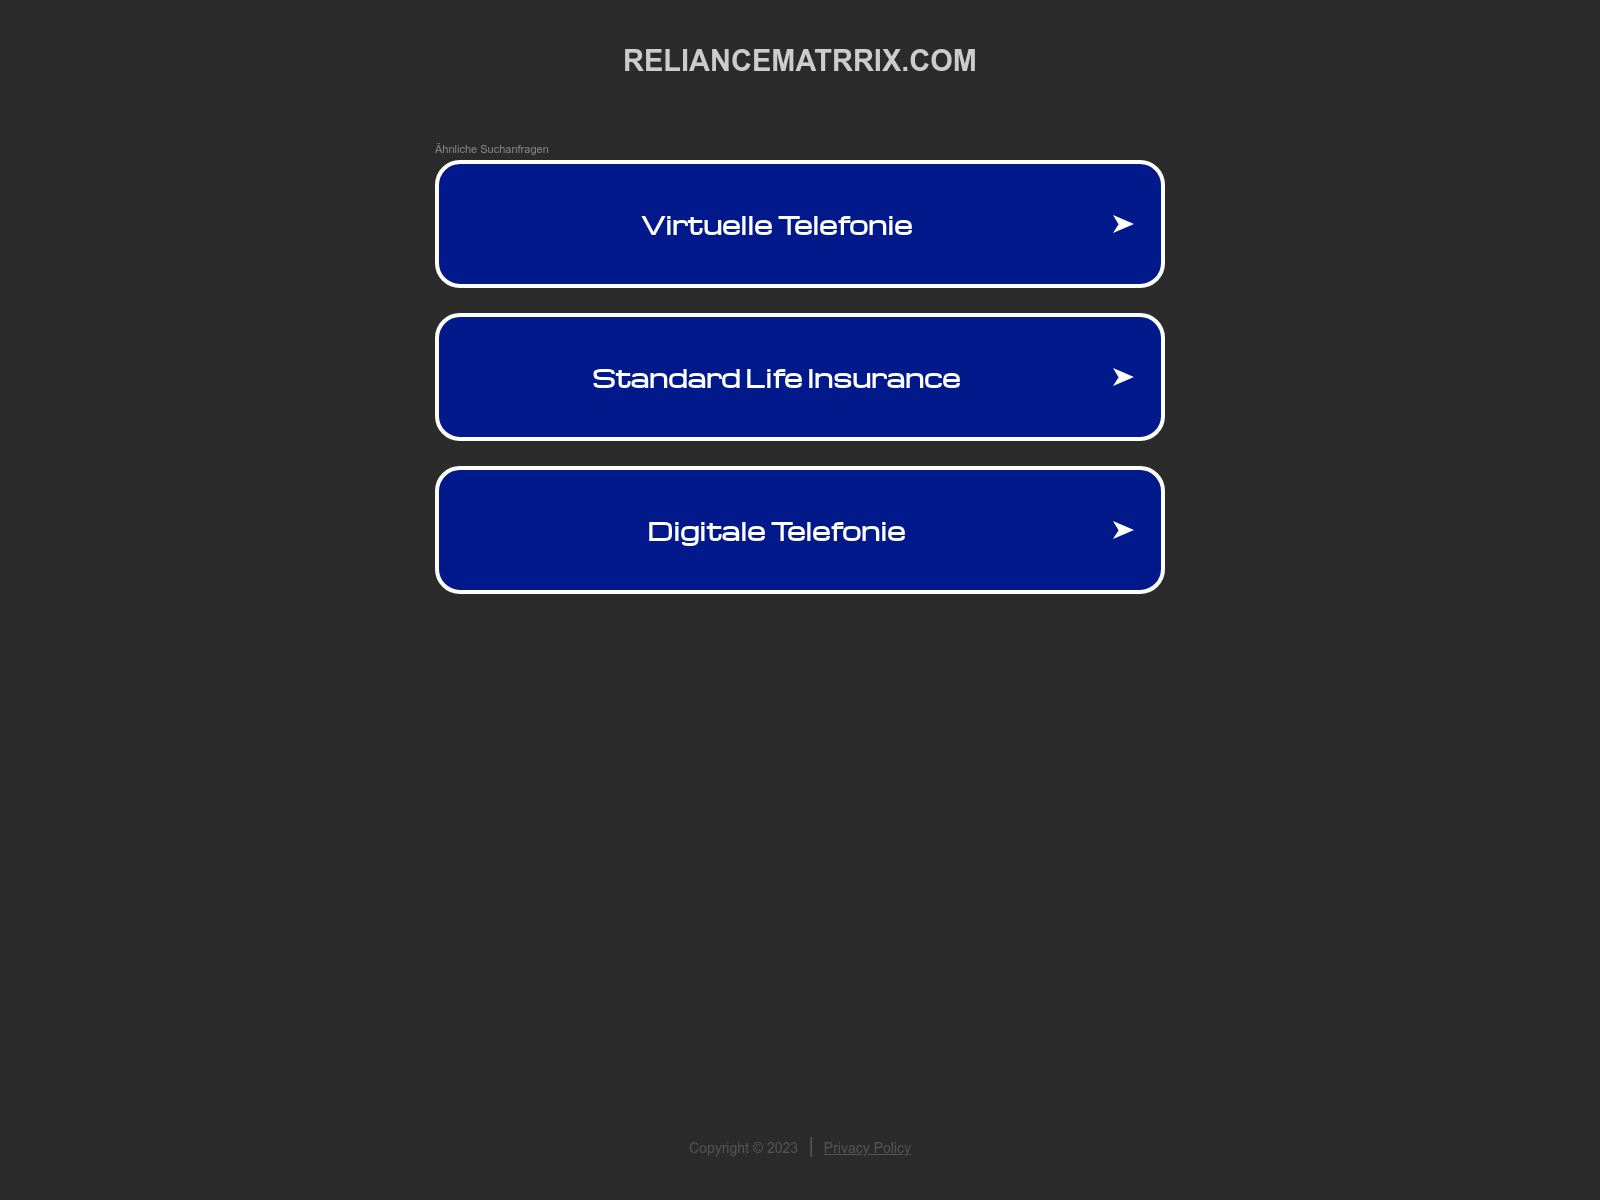



http://reliancematrrix.com/ at 2023-03-17T06:08:43.245Z via https://urlscan.io/screenshots/cf8244e5-c5d9-4532-bee4-0b694e12fa9e.png


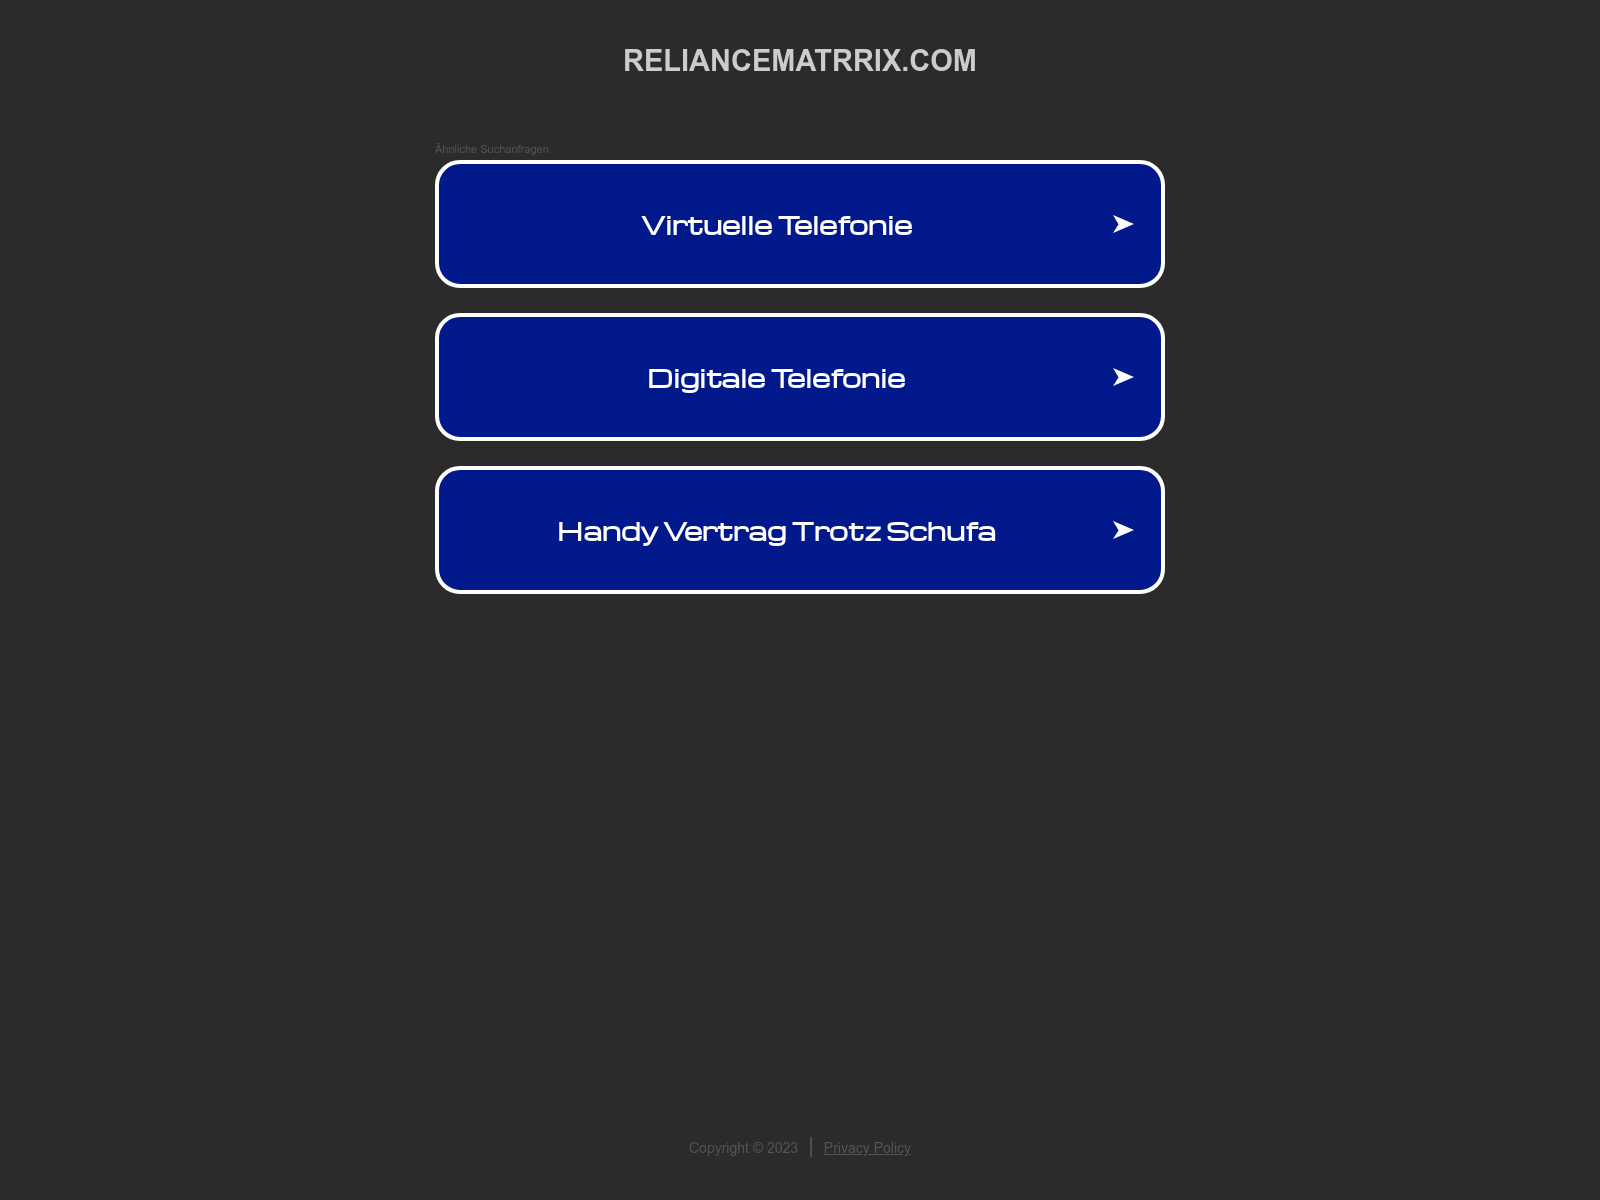



http://reliancematrrix.com/ at 2023-03-10T09:21:53.964Z via https://urlscan.io/screenshots/1e29116d-97ed-402c-b027-6f70026b8ab7.png


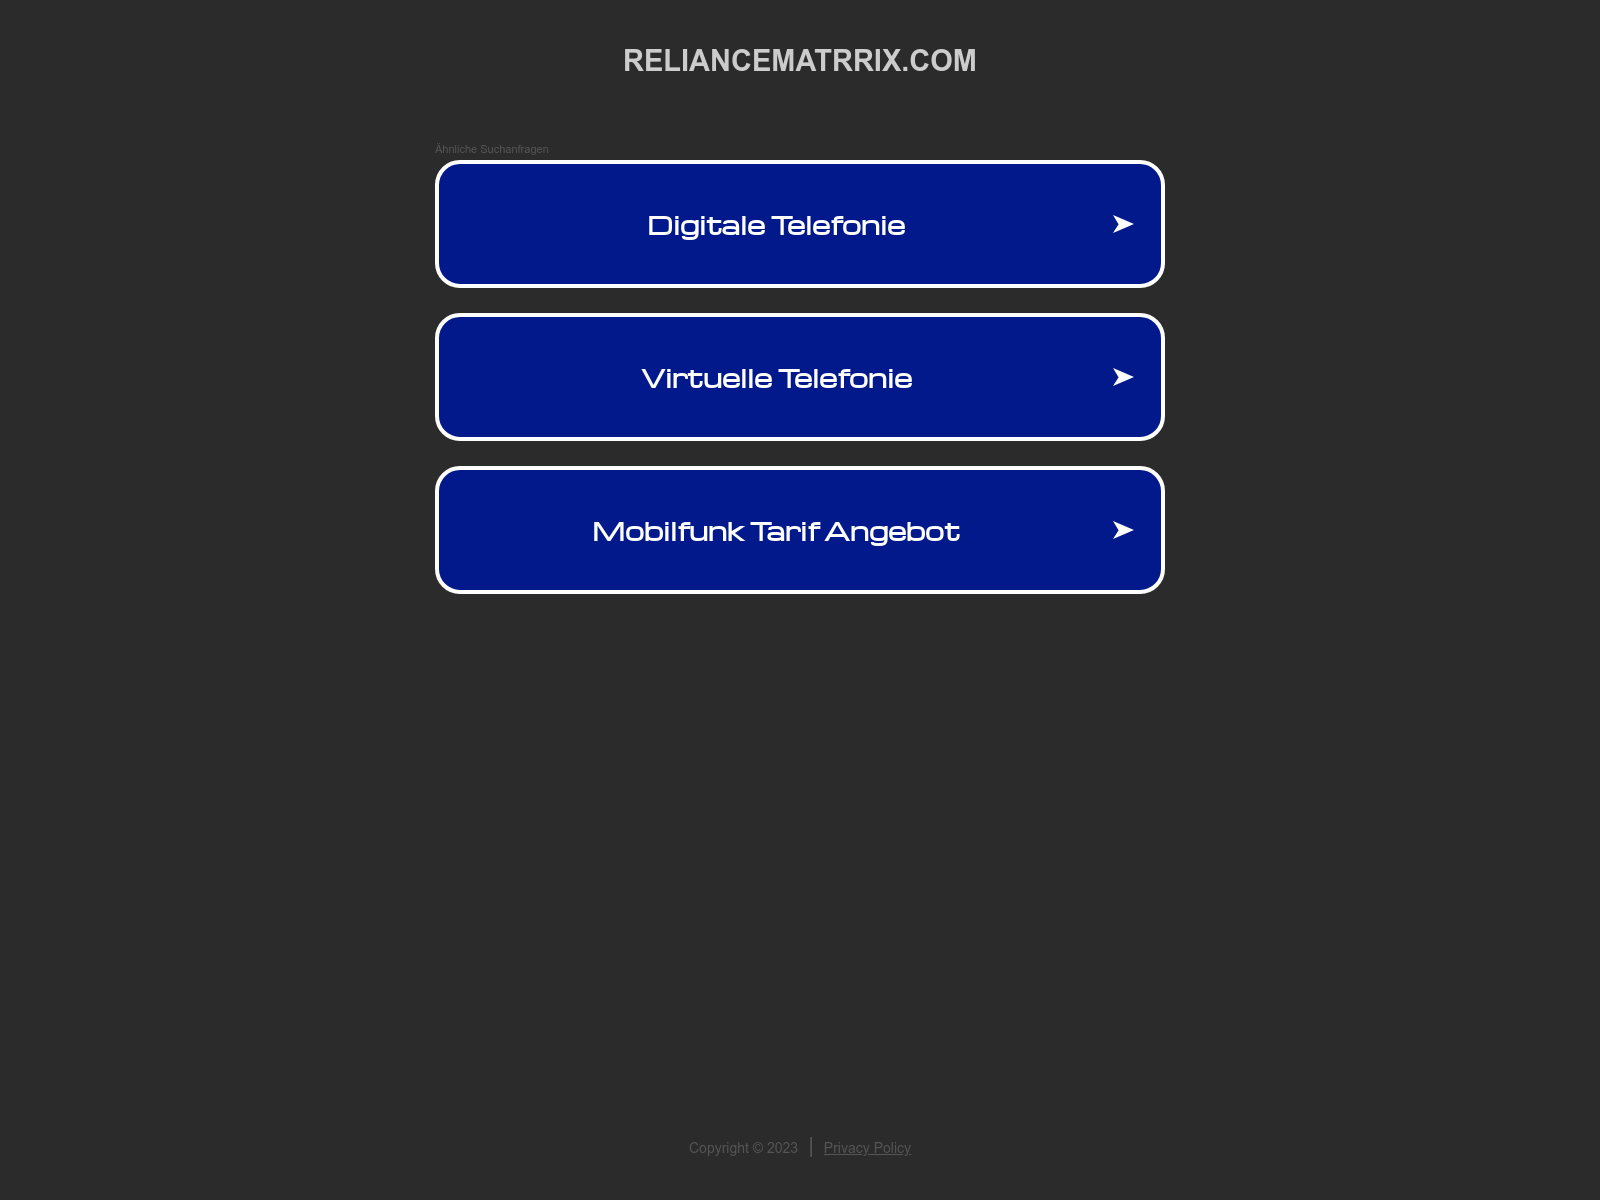



http://reliancematrrix.com/ at 2023-03-09T09:18:39.733Z via https://urlscan.io/screenshots/6eaee17e-59de-4155-9581-7b4113782c81.png


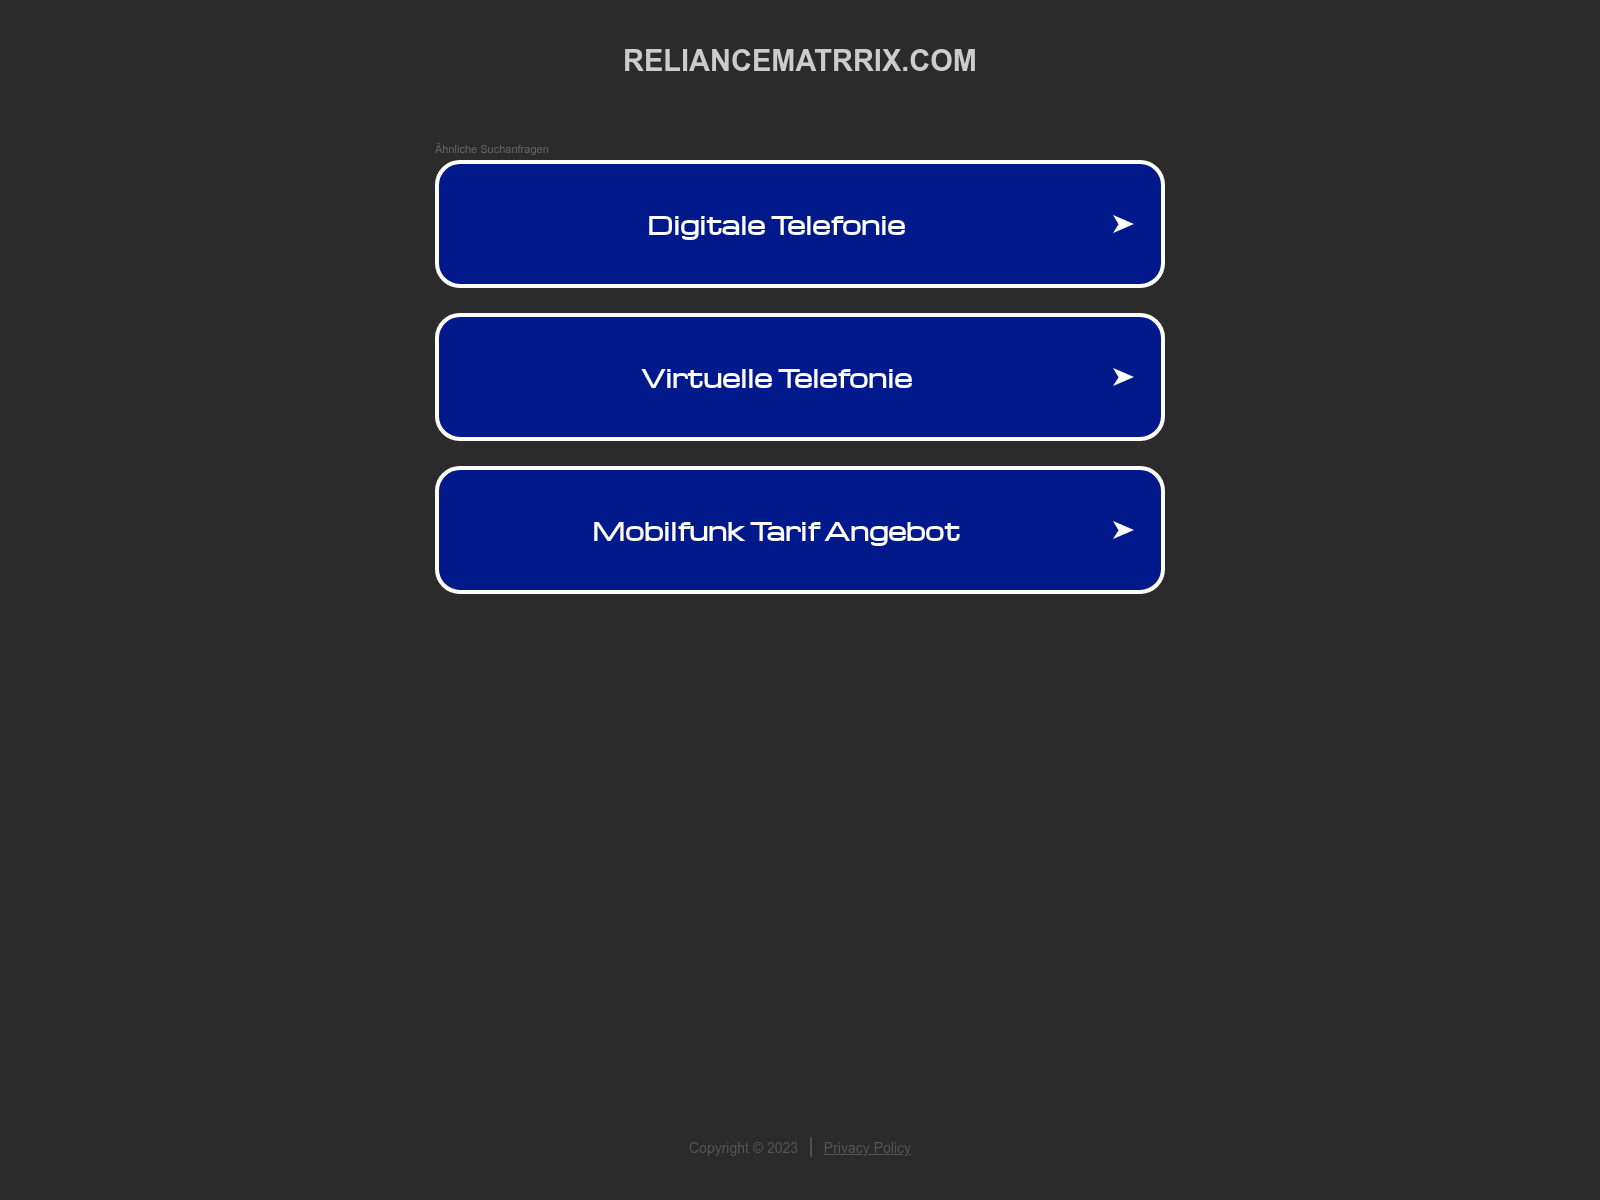



http://reliancematrrix.com/ at 2023-03-07T09:23:09.093Z via https://urlscan.io/screenshots/a2b5254d-a3e0-43f8-8397-c3f5fc122613.png


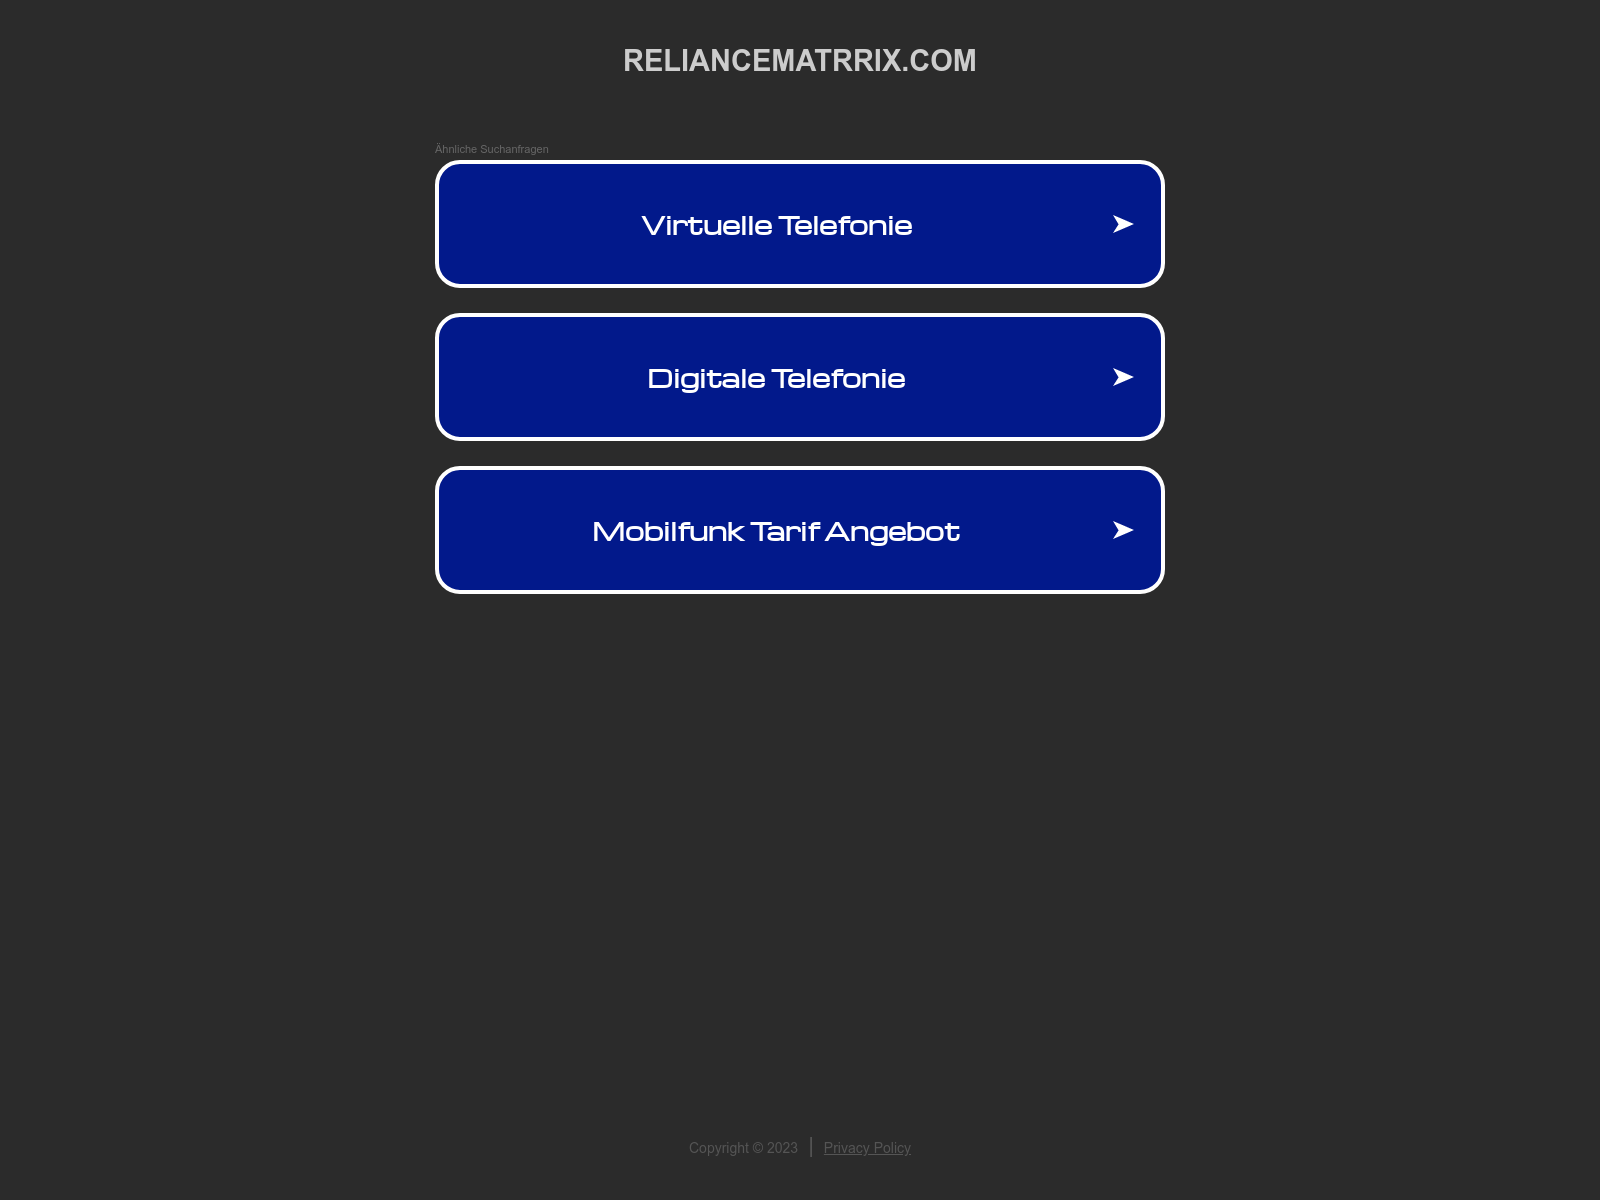



http://reliancematrrix.com/ at 2023-03-06T09:20:00.113Z via https://urlscan.io/screenshots/5239e0fa-0b4a-4452-b69f-8838930c80cd.png


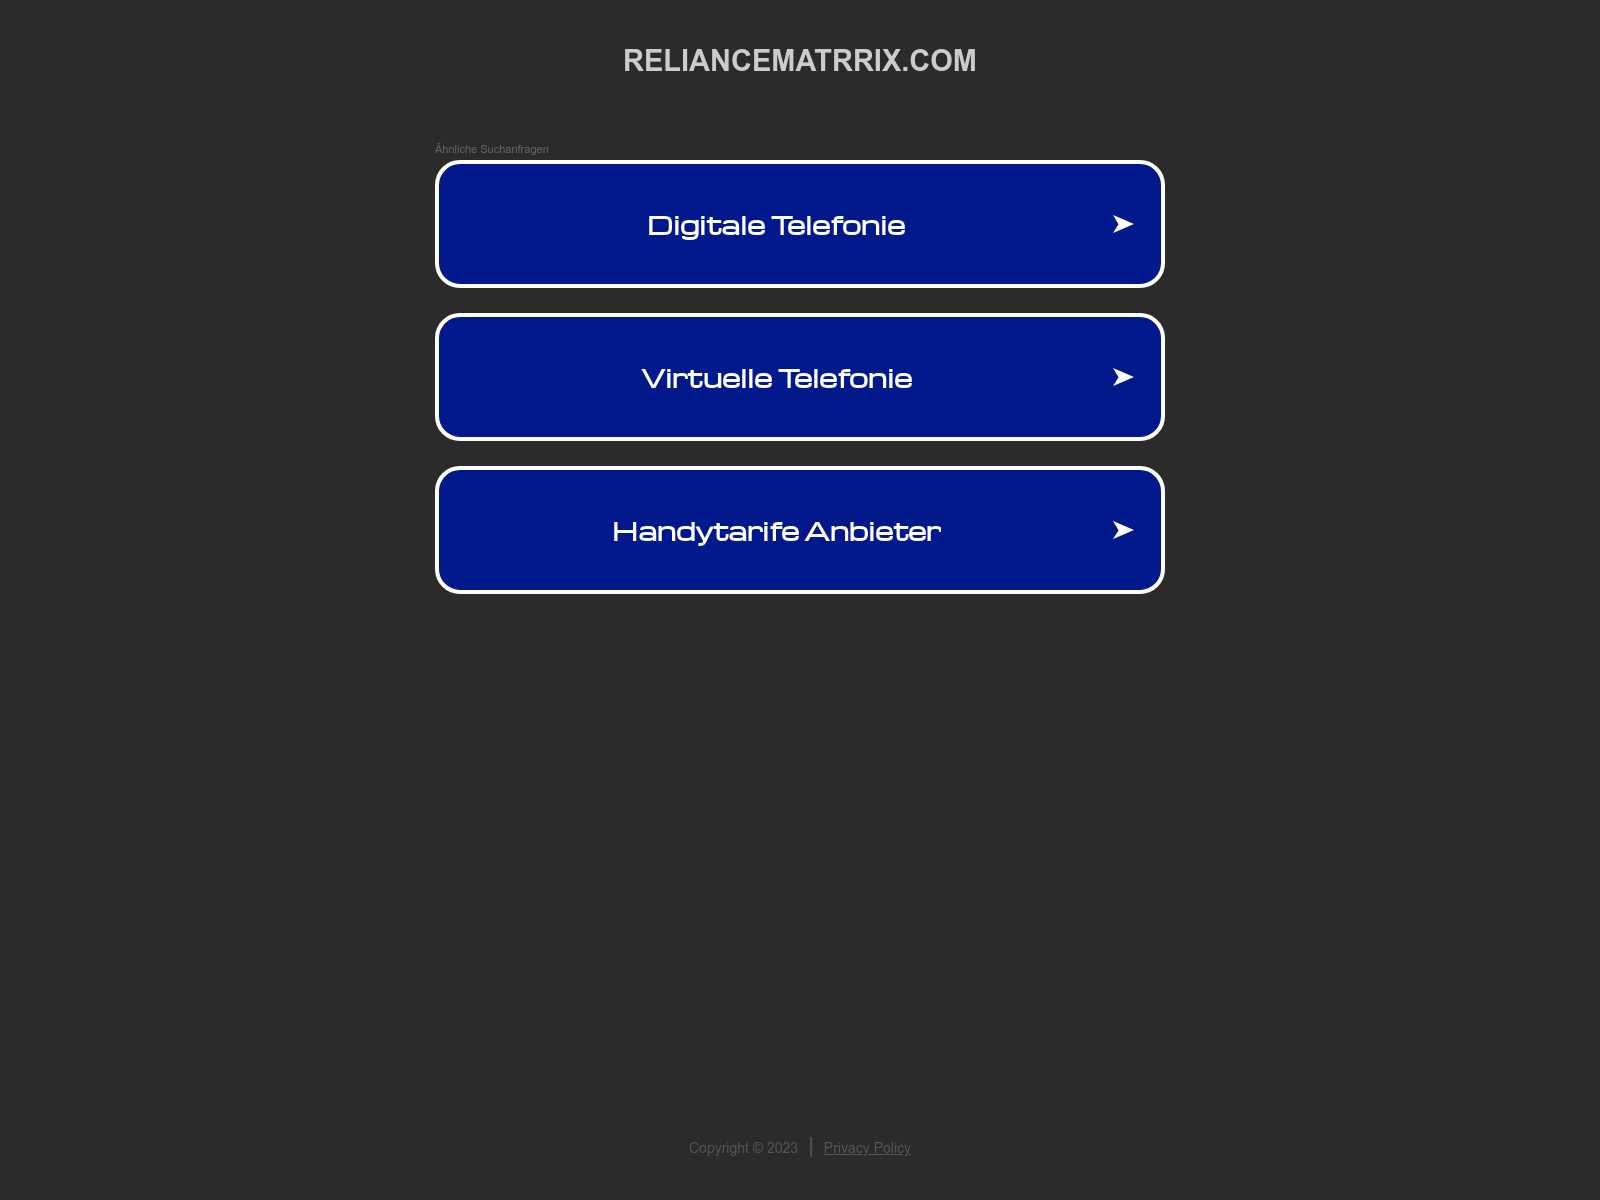



http://reliancematrrix.com/ at 2023-03-05T09:21:01.660Z via https://urlscan.io/screenshots/f4e1f2a4-e45f-4a1b-a0ff-2b5d9e412cb3.png


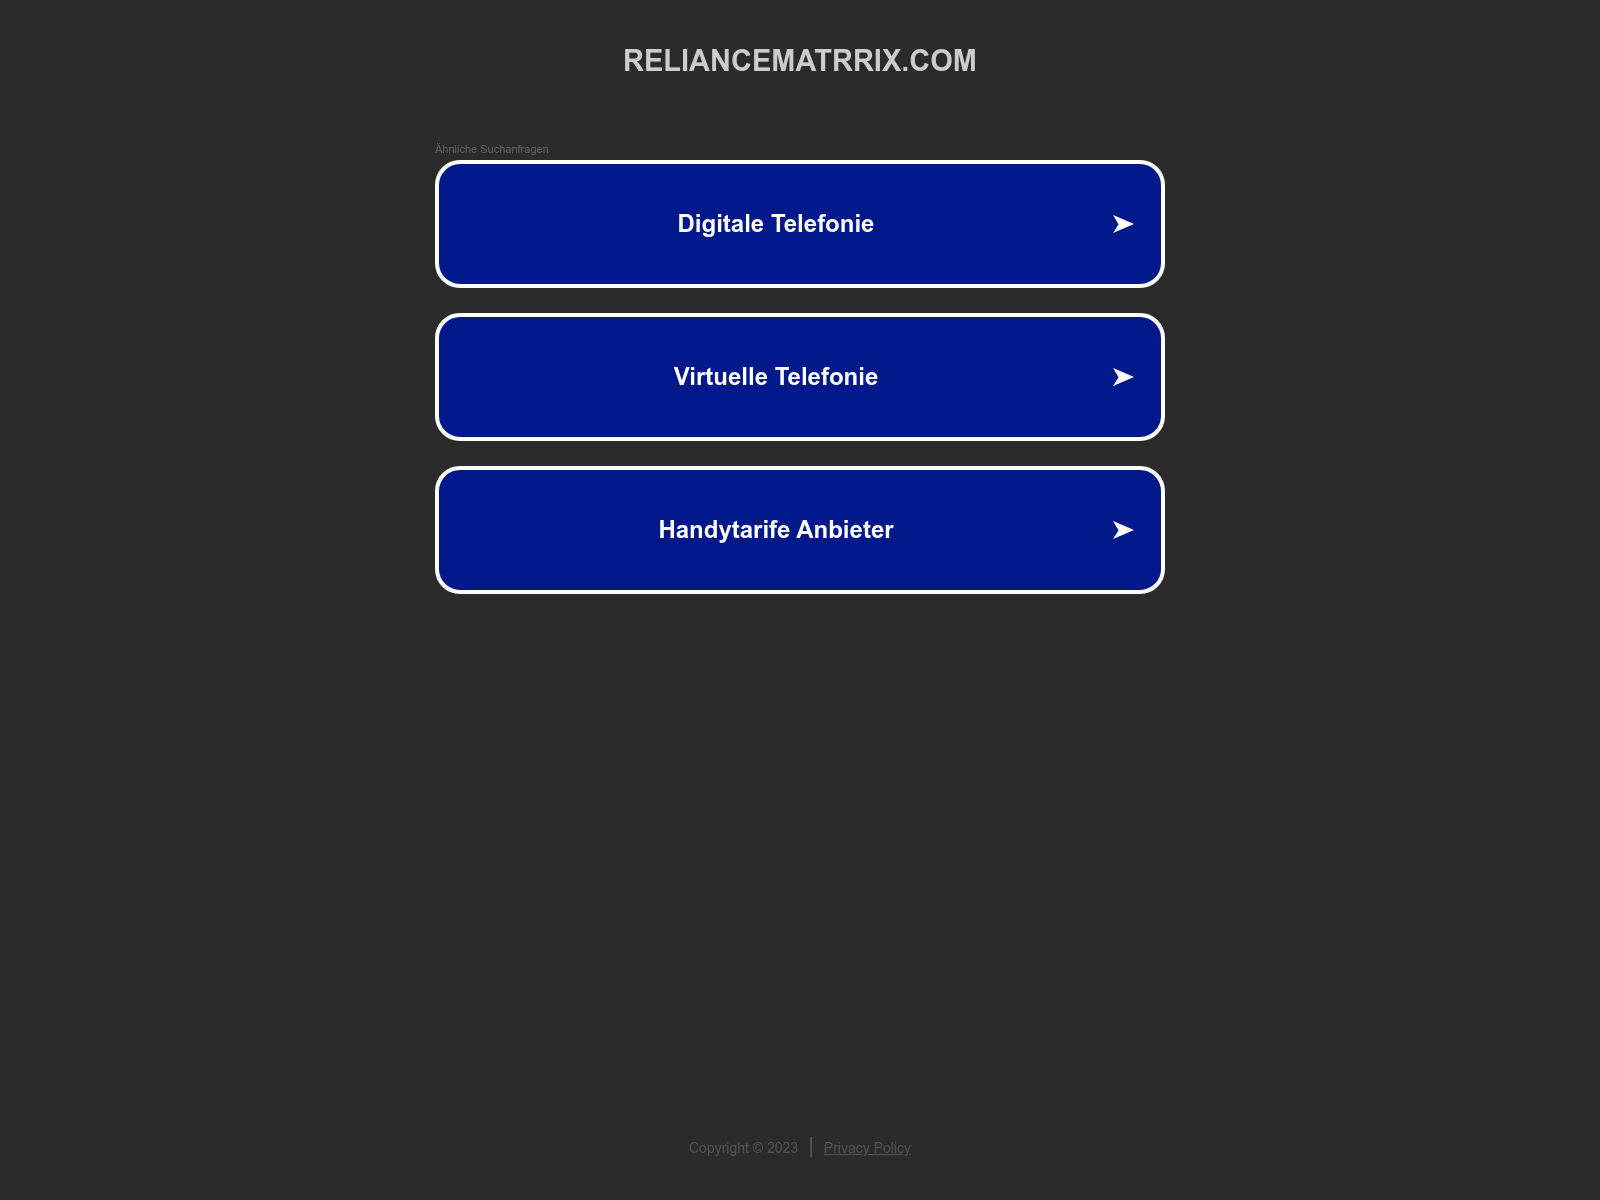



http://reliancematrrix.com/ at 2023-03-04T09:22:17.108Z via https://urlscan.io/screenshots/afa162a9-82d2-491a-8a26-13f99ff0a682.png


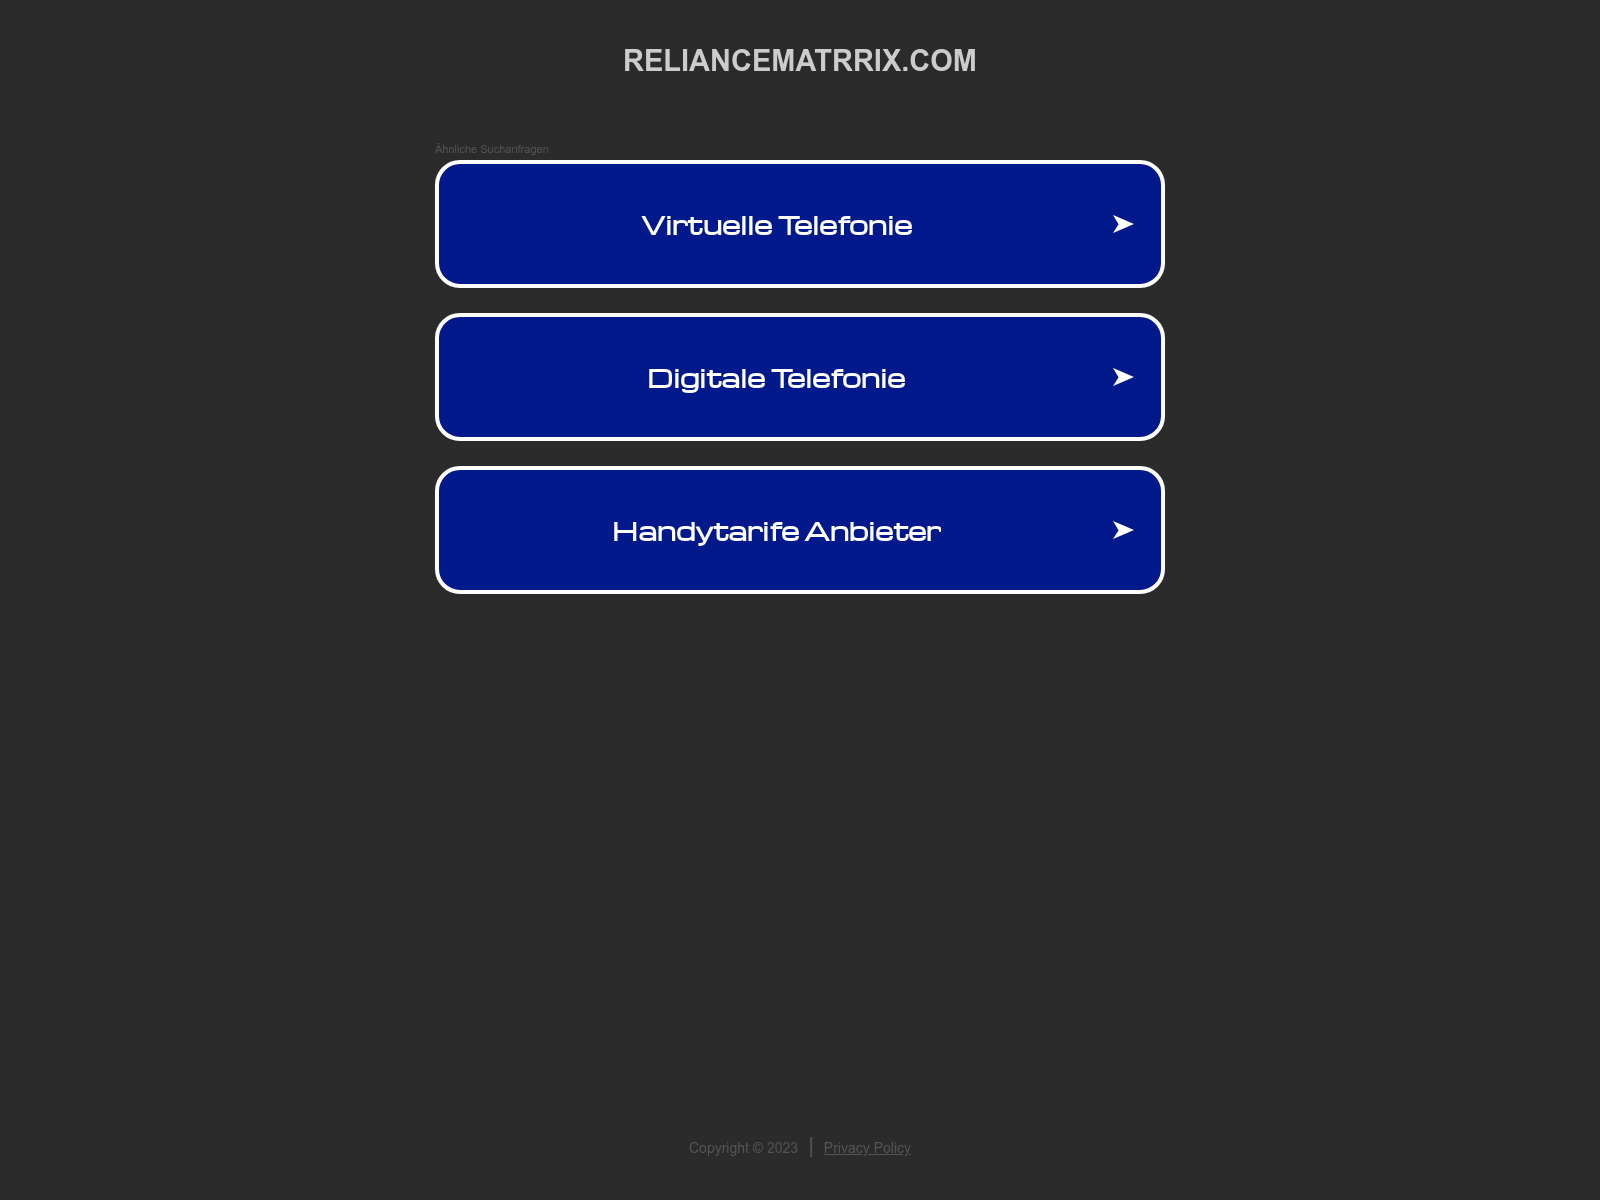



http://reliancematrrix.com/ at 2023-03-01T09:46:44.110Z via https://urlscan.io/screenshots/2d29ad68-aad5-4d65-81c0-e87b9477b8cf.png


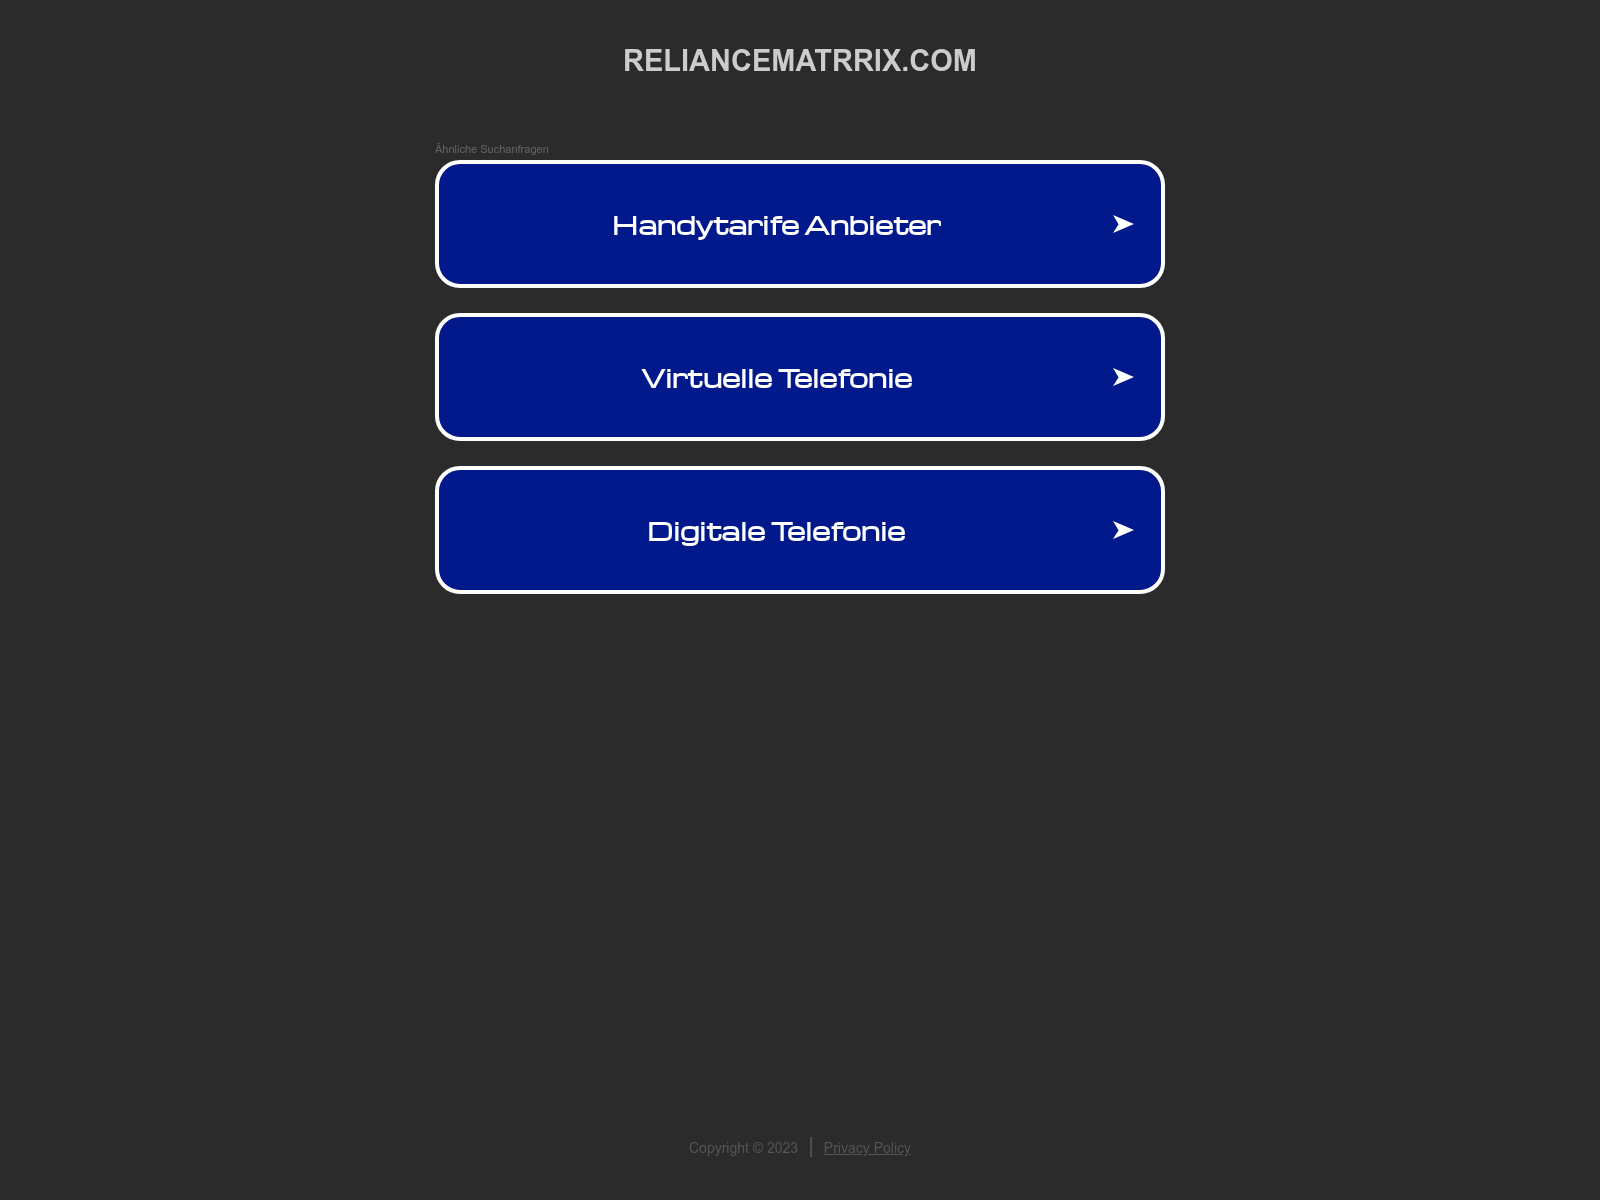

In [25]:
# Store the displayed results in a list. If you want to print them later you can just use this list
displayed = []
for urlscan_run in urlscan_results:
    if "screenshot" in urlscan_run and "screenshot_data" in urlscan_run:
        if base64.b64encode(urlscan_run["screenshot_data"].content).decode('utf-8') not in displayed:
            print("{} at {} via {}".format(urlscan_run["url"], urlscan_run["time"], urlscan_run["screenshot"]))
            display(Image(urlscan_run["screenshot_data"].content, width=240))
            displayed.append(base64.b64encode(urlscan_run["screenshot_data"].content).decode('utf-8'))
            print("\n")

## ER:3 Event graphs

Once the object relations have been added (either via the previously created URL and phishing objects, or those created by the URLscan enrichment) you can also display them on a graph. Head over to MISP and use the **Event graph** tab. This allows you to visually represent the objects, attributes and relations. Did you know you can also export these graphs to JSON, JPEG, PNG or the dot format? Under the **Export** button you can choose to export type. It's also possible to save the graph so that when you re-visit the event you can immediately have access to the lay of the objects you picked earlier. 

### Access the graph via the API
Additionally, it's also possible to access these "saved" event graphs via the **API**. If you have a graph, you can access them via `/event_graph/viewPicture/<mispevent_id>/<misp_eventgraph_id>`.

First, **save a graph** in the MISP interface under Event graph and then execute the next cell. Don't worry if you don't want to save the graph right away, the playbook will catch the error and continue without it.


![helpers/playbook-create_update_misp_event_on_phishing_with_link_eventgraph1.png](helpers/playbook-create_update_misp_event_on_phishing_with_link_eventgraph1.png)

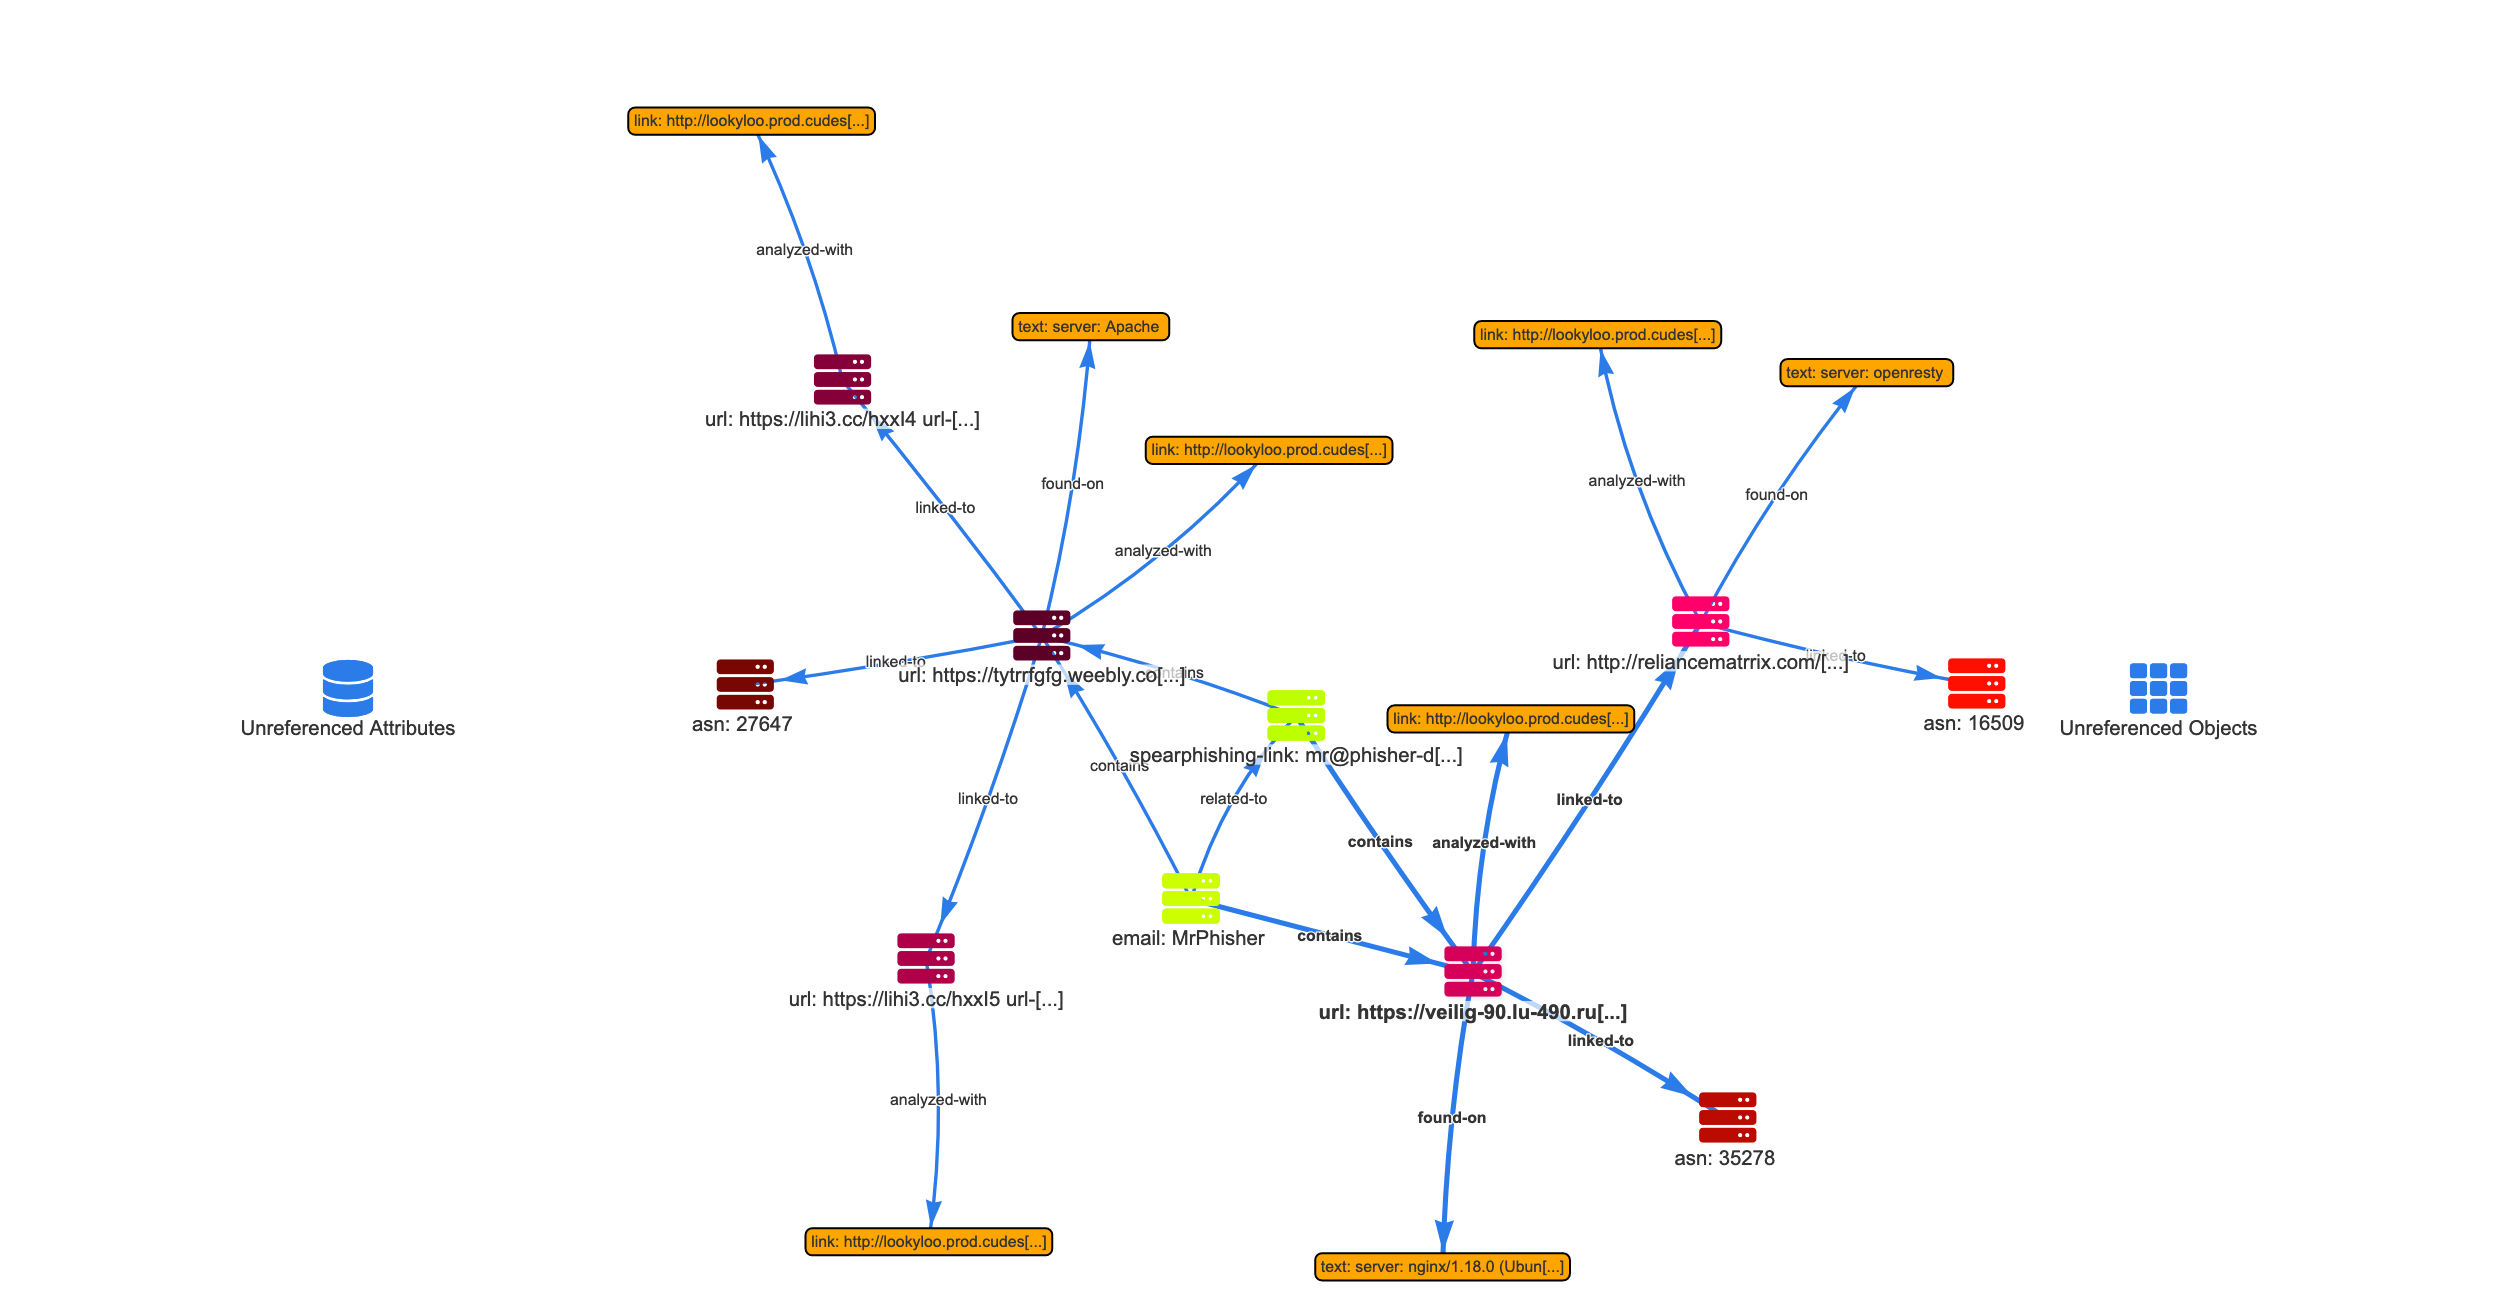

In [26]:
# Start with the first MISP Event graph
misp_eventgraph_id = 7

# We use the requests library and need to set the headers
misp_headers = {"Authorization": misp_key,  "Content-Type": "application/json", "Accept": "application/json"}
event_graph = requests.get("{}/event_graph/viewPicture/{}/{}".format(misp_url, misp_event.id, misp_eventgraph_id), headers=misp_headers, verify=misp_verifycert)
if event_graph.status_code == 200:
    display(Image(event_graph.content, width=480))
else:
    print("Event \033[91mgraph not found\033[90m. Continue with the playbook.\n\n")

### Filter the graph

Depending on the fields that you allowed the URLscan enrichment to add to your MISP event it can become more difficult to highlight the most relevant objects. In the MISP Event graph you also have the option to filter for attributes. One approach is to filter the results from URLscan and exclude some of the attributes. In the Even graph tab, click on **Filter** and scroll to **Filter on Tag presence**. Choose `do not contain` and pick `urlscan=screenshot`. Then click the plus button to add the exclusion. Do the same for `urlscan=result`. Then save your graph and rerun the previous code call. Adjust the value in `misp_eventgraph_id` to collect the MISP event graph.

![helpers/playbook-create_update_misp_event_on_phishing_with_link_eventgraph2.png](helpers/playbook-create_update_misp_event_on_phishing_with_link_eventgraph2.png)

![helpers/playbook-create_update_misp_event_on_phishing_with_link_eventgraph3.png](helpers/playbook-create_update_misp_event_on_phishing_with_link_eventgraph3.png)

# Correlation

## CR:1 Correlation

This cell adds the values for correlation. 

It uses `phishing_correlation_fields` to define which **fields** are used for correlation. Eventually, all the attribute **values** are added to one list `phishing_correlation_values` that is later used for the correlation. The values that are in the `phishing_correlation_unwanted_values` are excluded.

In [27]:
# Add correlation on the links
for links in case_details["links"]:
    phishing_correlation_values.append(links["url"]) if links["url"] not in phishing_correlation_values else None
    for redirect_url in links["redirect-url"]:
        phishing_correlation_values.append(redirect_url) if redirect_url not in phishing_correlation_values else None

# Pick the correlation values from URLscan
for urlscan_run in urlscan_results:
    for field in phishing_correlation_fields["urlscan"]:
        if field in urlscan_run:
            phishing_correlation_values.append(urlscan_run[field]) if urlscan_run[field] not in phishing_correlation_values else None

# Remove unwanted correlation values
for value in phishing_correlation_unwanted_values:
    try:
        phishing_correlation_values.remove(value)
    except:
        print("") # Have at least a line in the 'except' clause

print("MISP event and feed correlation will be done on: \033[92m{}\033[90m\n\n".format(phishing_correlation_values))        



MISP event and feed correlation will be done on: ['tytrrfgfg.weebly.com', 'weebly', 'lihi3.cc', 'lihi3', 'veilig-90.lu-490.ru', 'lu-490', 'reliancematrrix.com', 'reliancematrrix', 'https://tytrrfgfg.weebly.com/', 'https://lihi3.cc/hxxI4', 'https://lihi3.cc/hxxI5', 'https://veilig-90.lu-490.ru/01/6.php', 'http://reliancematrrix.com/', '199.34.228.54', 'pages-wildcard-2.weebly.com', 'AS27647', '199.34.228.53', 'pages-wildcard-1.weebly.com', '185.251.89.172', 'AS35278', '185.251.89.101', '199.59.243.223', 'AS16509', '199.59.243.222']




## CR:2 Correlation with MISP events

This cell searches the **MISP server** for events that have a match with a value that was previously added to the list `phishing_correlation_values`. The output is a table with all the matches.
A summary of the correlation is also shown at the end of the playbook.

Only **published** events (`correlation_published`) and attributes that have the **to_ids** flag (`correlation_to_ids`) set are take into account. There is a default limit of **1000 hits** (`correlation_limit`).

In [28]:
# Only query for published MISP events
correlation_published = True

# Only consider those values that have the to_ids field set to True
correlation_to_ids = True

# Limit the returned results to 1000 attributes
correlation_limit = 1000

In [29]:
phishing_correlation_results["misp"] = {}

if len(phishing_correlation_values) > 0:
    result = misp.search("attributes", to_ids=correlation_to_ids, published=correlation_published, limit=correlation_limit, returnformat="json", 
                         value=phishing_correlation_values, pythonify=True)
    for corr_attribute in result:
        category_type = "{}/{}".format(corr_attribute.category, corr_attribute.type)
        event_info = "{} ({})".format(corr_attribute.Event.info, corr_attribute.Event.id)
        if corr_attribute.value in phishing_correlation_results["misp"]:
            phishing_correlation_results["misp"][corr_attribute.value]["category_type"].append(category_type) if category_type not in phishing_correlation_results["misp"][corr_attribute.value]["category_type"] else None
            phishing_correlation_results["misp"][corr_attribute.value]["event_info"].append(event_info) if event_info not in phishing_correlation_results["misp"][corr_attribute.value]["event_info"] else None
        else:
            phishing_correlation_results["misp"][corr_attribute.value] = {"category_type": [category_type], "event_info": [event_info]}
            
    #misp_matches_count = 0
    #for el in phishing_correlation_results["misp"]:
    #    misp_matches_count = misp_matches_count + 1
    misp_matches_count = len(phishing_correlation_results["misp"])
    print("Got \033[92m{}\033[90m correlation result(s).\n\n".format(misp_matches_count))
else:
    print("\033[93mNo correlating MISP events found")

Got 3 correlation result(s).




### MISP events correlation table

The correlation results are now stored in `phishing_correlation_results["misp"]`. Execute the next cell to display them in a table format. The table is also included in the summary sent to Mattermost and TheHive.

In [30]:
# Put the correlations in a pretty table. We can use this table later also for the summary
misp_table = PrettyTable()
if misp_matches_count > 0:    
    misp_table.field_names = [ "Source", "Value", "Type", "Event" ]
    misp_table.align["Value"] = "l"
    misp_table.align["Type"] = "l"
    misp_table.align["Event"] = "l"
    for correlation in phishing_correlation_results["misp"]:
        for category_type in phishing_correlation_results["misp"][correlation]["category_type"]:
            events = ""
            for event in phishing_correlation_results["misp"][correlation]["event_info"]:
                events = "{}{}\n".format(events, event)
            misp_table.add_row(["MISP", correlation, category_type, events] )
    print(misp_table)
else:
    print("\033[93mNo correlating MISP events found")

+--------+--------------------------------------+-------------------------+-------------------------------+
| Source | Value                                | Type                    | Event                         |
+--------+--------------------------------------+-------------------------+-------------------------------+
|  MISP  | https://veilig-90.lu-490.ru/01/6.php | Network activity/url    | Previous phishing case (2586) |
|        |                                      |                         |                               |
|  MISP  | 199.59.243.222                       | Network activity/ip-dst | Previous phishing case (2586) |
|        |                                      |                         |                               |
|  MISP  | 199.59.243.223                       | Network activity/ip-dst | Previous phishing case (2586) |
|        |                                      |                         |                               |
+--------+------------------

## CR:3 Correlation with MISP feeds <a name="correlation_feeds"></a>

This cell searches the **MISP feeds** for events that have a match with a value that was previously added to the list `phishing_correlation_values`. The output of this cell is a table with all the matches. The output is also repeated at the end of the playbook.

Note that the correlation lookup in the MISP feeds does not return the name of the MISP event, it returns the UUID of the event as title.

In [31]:
phishing_correlation_results["feeds"] = {}

if len(phishing_correlation_values) > 0:    
    misp_cache_url = "{}/feeds/searchCaches/".format(misp_url)
    for el in phishing_correlation_values:
        # Instead of GET, use POST (https://github.com/MISP/MISP/issues/7478)
        cache_results = requests.post(misp_cache_url, headers=misp_headers, verify=misp_verifycert, json={ "value": el })
        for result in cache_results.json():
            if "Feed" in result:
                feed_name = result["Feed"]["name"]
                feed_matches = []
                for match in result["Feed"]["direct_urls"]:
                    feed_matches.append(match["url"])
                if el in phishing_correlation_results["feeds"]:
                    phishing_correlation_results["feeds"][el].append({ "feed": feed_name, "event_info": feed_matches })
                else:
                    phishing_correlation_results["feeds"][el] = [{ "feed": feed_name, "event_info": feed_matches }]
    feed_matches_count = 0
    for el in phishing_correlation_results["feeds"]:
        feed_matches_count = feed_matches_count + len(phishing_correlation_results["feeds"][el])
    print("Got \033[92m{}\033[90m correlation result(s).\n\n".format(feed_matches_count))
else:
    print("\033[93mNo correlating MISP feeds found")    

Got 1 correlation result(s).




### MISP feed correlations table

The correlation results are now stored in `phishing_correlation_results["feeds"]`. Execute the next cell to display them in a table format. The table is also included in the summary sent to Mattermost and TheHive.

In [32]:
# Put the correlations in a pretty table. We can use this table later also for the summary
feed_table = PrettyTable()
if feed_matches_count > 0:    
    feed_table.field_names = [ "Source", "Value", "Feed name", "Event" ]
    feed_table.align["Value"] = "l"
    feed_table.align["Feed name"] = "l"
    feed_table.align["Event"] = "l"
    feed_table.border = True
    for el in phishing_correlation_results["feeds"]:
        for match in phishing_correlation_results["feeds"][el]:
            events = ""
            for event in match["event_info"]:
                events = "{}{}".format(events, event)
            feed_table.add_row(["Feed", el, match["feed"], events] )
    print(feed_table)
else:
    print("\033[93mNo correlating MISP data found in the feeds")

+--------+-------------------------------+---------------------------------+--------------------------------------------------+
| Source | Value                         | Feed name                       | Event                                            |
+--------+-------------------------------+---------------------------------+--------------------------------------------------+
|  Feed  | https://tytrrfgfg.weebly.com/ | Phishtank online valid phishing | https://misp.demo.cudeso.be/feeds/previewIndex/8 |
+--------+-------------------------------+---------------------------------+--------------------------------------------------+


# Containment

## CN:1 Report phishing website to external providers <a name="containment_reporturls"></a>

The playbook allows you to **manually** report the URLs to external providers. To avoid accidental errors (or abuse) the automatic submission is not supported.

### Microsoft

You can report an unsafe IP or URL to Microsoft Security Intelligence via the form at [https://www.microsoft.com/en-us/wdsi/support/report-unsafe-site-guest](https://www.microsoft.com/en-us/wdsi/support/report-unsafe-site-guest).

### PhishTank

You can submit a URL to PhishTank via [https://phishtank.org/add_web_phish.php](https://phishtank.org/add_web_phish.php). Note that you need to be **logged in** to PhishTank.

### Google

The submission to Google Safebrowsing allows you to pre-fill the URL field, which avoids a number of additional copy/pastes. This pre-fill is done in the next code section.

In [33]:
# Create the links to report a site to Google Safebrowsing
report_google = "https://safebrowsing.google.com/safebrowsing/report_phish/?url="
display(HTML("<h3>Google</h3>"))
for url in case_details["links"]:
    display(HTML("Report URL to Google: <a href=\"{}{}\" target=_blank>{}{}</a>\n".format(report_google, url["url"], report_google, url["url"])))
    for redirect_url in url["redirect-url"]:
        display(HTML("Report the redirect URL to Google: <a href=\"{}{}\" target=_blank>{}{}</a>\n".format(report_google, redirect_url, report_google, redirect_url)))
    print("\n")

# Closure

In this **closure** or end step we collect the MISP **indicators** and create a **summary** of the actions that were performed by the playbook. The summary is printed in the playbook and can also be send to a chat channel. 

## EN:1 MISP indicators

The next section first **queries MISP for the indicators added to the MISP event** that is linked to the execution of this playbook.

The indicators are stored in the variable `indicator_table` (table format) and `indicator_raw_list` (in raw format) which is used in a later section to create the playbook summary.

### Table with MISP indicators

In [34]:
# Get all the indicators for our event and store this is in a table. We can also use this for the summary.
indicator_search = misp.search("attributes", uuid=misp_event.uuid, to_ids=True, pythonify=True)
indicator_raw_list = []
indicator_table = PrettyTable()
if len(indicator_search) > 0:
    indicator_table.field_names = ["Type", "Category", "Indicator", "Comment"]
    indicator_table.align["Type"] = "l"
    indicator_table.align["Category"] = "l"
    indicator_table.align["Indicator"] = "l"
    indicator_table.align["Comment"] = "l"
    indicator_table.border = True
    for indicator in indicator_search:
        if indicator.value not in indicator_raw_list:
            indicator_table.add_row([indicator.type, indicator.category, indicator.value, indicator.comment])
            indicator_raw_list.append(indicator.value)
    print("Got \033[92m{}\033[90m indicator(s) from the event \033[92m{}\033[90m ({}).\n\n".format(len(indicator_raw_list), misp_event.info, misp_event.id))
else:
    print("\033[93mNo indicators found in the event \033[92m{}\033[90m ({})".format(misp_event.info, misp_event.id))

Got 18 indicator(s) from the event Demo Event Phishing (2591).




### Raw list of MISP indicators

The indicators are now stored in `indicator_search` (as Python objects) and `indicator_raw_list` (in raw format, only the indicators). Execute the next cell to display them in a table format. The table is also included in the summary sent to Mattermost and TheHive.

In [35]:
if len(indicator_raw_list) > 0:
    print(indicator_table.get_string(sortby="Type"))
    print("\n\nIndicator list in raw format:")
    print("---------------------------------------------------")
    for el in indicator_raw_list:
        print("{}".format(el))
    print("---------------------------------------------------")

+-----------+------------------+--------------------------------------+--------------------------------------------+
| Type      | Category         | Indicator                            | Comment                                    |
+-----------+------------------+--------------------------------------+--------------------------------------------+
| domain    | Network activity | lihi3.cc                             |                                            |
| domain    | Network activity | lu-490.ru                            |                                            |
| domain    | Network activity | reliancematrrix.com                  |                                            |
| domain    | Network activity | weebly.com                           |                                            |
| email-src | Payload delivery | mr@phisher-domain.com                |                                            |
| email-src | Payload delivery | mrs@phisher-domain.com         

## EN:2 MISP PDF export

If you are logged into MISP, and have the **MISP export module to generate a PDF** enabled, then you can use the link in the next section to access a PDF export of the MISP event. Note that this PDF export is done *outside the playbook*.

In [36]:
# Create the link for the MISP PDF export
misp_pdf_export = "{}events/exportModule/pdfexport/{}".format(misp_url, misp_event.id)
print("PDF Link: {}\n".format(misp_pdf_export))
display(HTML("Click this link (make sure you have previously logged in to MISP) to have a PDF export of the <a href=\"{}\" target=_blank>event {} ({})</a>\n".format(misp_pdf_export, misp_event.info, misp_event.id)))

PDF Link: https://misp.demo.cudeso.be/events/exportModule/pdfexport/2591



## EN:3 Create the summary of the playbook

The next section creates a summary and stores the output in the variable `summary` in Markdown format. It also stores an intro text in the variable `intro`. These variables are later used when sending information to Mattermost or TheHive.

In [37]:
summary = "## MISP Playbook summary\nA phishing incident was analysed with MISP event: **{}** ({}/events/view/{}). ".format(misp_event.info, misp_url, misp_event.id)

phishing_objects_str = ""
url_object_str = ""
phishing_objects_count = 0
for el in phishing_objects:
    phishing_objects_str = "{} **{}** (for {})".format(phishing_objects_str, phishing_objects[el]["phishing"].uuid, el)
    phishing_objects_count += 1
    url_object_str = "{} {}".format(url_object_str, phishing_objects[el]["url"].uuid)
summary += "This concerned a message sent to **{}**, with subject **{}**\n\n".format(case_details["from"], case_details["subject"])
intro = summary

summary += "### Indicators\n"
if len(indicator_raw_list) > 0:
    indicator_table.set_style(MARKDOWN)
    summary += indicator_table.get_string(sortby="Type")
    summary += "\n\n\n" 
    summary += "Indicators in **raw format**\n\n"
    for indicator in indicator_raw_list:
        summary += "{}\n\n".format(indicator)
    summary += "\n" 
else:
    summary += "There are no indicators"
    
if create_spearphishing_link_object:
    summary += "### Objects \nIn this event the playbook created \n- an email object **{}** \n- a spearphishing link object **{}** \n- {} phishing objects {} ".format(email_object.uuid, spearphishing_link_object.uuid, phishing_objects_count, phishing_objects_str.strip())    
else:
    summary += "### Objects \nIn this event the playbook created \n- an email object **{}** \n- {} phishing objects {} ".format(email_object.uuid, phishing_objects_count, phishing_objects_str.strip())
summary += "with corresponding URL objects **{}**\n".format(url_object_str.strip())

summary += "### Correlating indicators\nThe indicators used for correlation are\n"
for el in phishing_correlation_values:
    summary += "- {}\n".format(el)

if misp_matches_count > 0:
    summary += "### MISP event matches\nThere are {} matches for the indicators found in the MISP events. \n\n".format(misp_matches_count)
    misp_table.set_style(MARKDOWN)
    summary += misp_table.get_string()
else:
    summary += "### MISP event matches\nThere are no matches for the indicators found in the MISP events."
summary += "\n"
if feed_matches_count > 0:
    summary += "### MISP feed matches\nThere are {} matches for the indicators found in the MISP feeds. \n\n".format(feed_matches_count)
    feed_table.set_style(MARKDOWN)
    summary += feed_table.get_string()
else:
    summary += "### MISP feed matches\nThere are no matches for the indicators found in the MISP feeds."
summary += "\n"

if len(phishing_correlation_results["lookyloo"]) > 0:
    summary += "### Lookyloo submission\nThe URLs are submitted to Lookyloo for further analaysis. \n\n"
    summary += "|URL|Lookyloo analysis URL|\n|:---|:----|\n"
    for el in phishing_correlation_results["lookyloo"]:
        summary += "|{}|{}|\n".format(el, phishing_correlation_results["lookyloo"][el])
else:
    summary += "### Lookyloo submission\nThere are no Lookyloo submissions."
    
summary += "\n\n"


print("The \033[92msummary\033[90m of the playbook is available.\n")

The summary of the playbook is available.



## EN:4 Print the summary of the playbook

Print the summary of the playbook in Markdown format.

In [38]:
display_markdown(summary, raw=True)

## MISP Playbook summary
A phishing incident was analysed with MISP event: **Demo Event Phishing** (https://misp.demo.cudeso.be//events/view/2591). This concerned a message sent to **['mr@phisher-domain.com', 'mrs@phisher-domain.com']**, with subject **Unable to complete invoice payment because of your unbalanced ToS**

### Indicators
| Type      | Category         | Indicator                            | Comment                                    |
|:----------|:-----------------|:-------------------------------------|:-------------------------------------------|
| domain    | Network activity | lihi3.cc                             |                                            |
| domain    | Network activity | lu-490.ru                            |                                            |
| domain    | Network activity | reliancematrrix.com                  |                                            |
| domain    | Network activity | weebly.com                           |                                            |
| email-src | Payload delivery | mr@phisher-domain.com                |                                            |
| email-src | Payload delivery | mrs@phisher-domain.com               |                                            |
| ip-dst    | Network activity | 185.251.89.101                       | https://veilig-90.lu-490.ru/01/6.php       |
| ip-dst    | Network activity | 185.251.89.172                       | https://veilig-90.lu-490.ru/01/6.php       |
| ip-dst    | Network activity | 199.34.228.53                        | https://tytrrfgfg.weebly.com/              |
| ip-dst    | Network activity | 199.34.228.54                        | https://tytrrfgfg.weebly.com/              |
| ip-dst    | Network activity | 199.59.243.222                       | http://reliancematrrix.com/                |
| ip-dst    | Network activity | 199.59.243.223                       | http://reliancematrrix.com/                |
| ip-src    | Network activity | 20.30.40.50                          |                                            |
| url       | Network activity | http://reliancematrrix.com/          | From: https://veilig-90.lu-490.ru/01/6.php |
| url       | Network activity | https://lihi3.cc/hxxI4               | From: https://tytrrfgfg.weebly.com/        |
| url       | Network activity | https://lihi3.cc/hxxI5               | From: https://tytrrfgfg.weebly.com/        |
| url       | Network activity | https://tytrrfgfg.weebly.com/        |                                            |
| url       | Network activity | https://veilig-90.lu-490.ru/01/6.php |                                            |


Indicators in **raw format**

mr@phisher-domain.com

mrs@phisher-domain.com

20.30.40.50

https://tytrrfgfg.weebly.com/

https://lihi3.cc/hxxI4

https://lihi3.cc/hxxI5

https://veilig-90.lu-490.ru/01/6.php

http://reliancematrrix.com/

weebly.com

lihi3.cc

lu-490.ru

reliancematrrix.com

199.34.228.54

199.34.228.53

185.251.89.172

185.251.89.101

199.59.243.223

199.59.243.222


### Objects 
In this event the playbook created 
- an email object **3c380500-4e05-49c5-a3cf-f7e01a553c52** 
- a spearphishing link object **cafda216-34cf-4001-8cd6-012c9815f96b** 
- 2 phishing objects **485d8a33-ace9-470a-8d5e-e2569237dcb0** (for https://tytrrfgfg.weebly.com/) **d311b569-d9ab-4393-981b-7da0b7a602cd** (for https://veilig-90.lu-490.ru/01/6.php) with corresponding URL objects **c0ad5d01-168f-4839-b9b7-2bcc7e57562d 5bda57e4-9593-4a45-9a64-935f8e9722db**
### Correlating indicators
The indicators used for correlation are
- tytrrfgfg.weebly.com
- weebly
- lihi3.cc
- lihi3
- veilig-90.lu-490.ru
- lu-490
- reliancematrrix.com
- reliancematrrix
- https://tytrrfgfg.weebly.com/
- https://lihi3.cc/hxxI4
- https://lihi3.cc/hxxI5
- https://veilig-90.lu-490.ru/01/6.php
- http://reliancematrrix.com/
- 199.34.228.54
- pages-wildcard-2.weebly.com
- AS27647
- 199.34.228.53
- pages-wildcard-1.weebly.com
- 185.251.89.172
- AS35278
- 185.251.89.101
- 199.59.243.223
- AS16509
- 199.59.243.222
### MISP event matches
There are 3 matches for the indicators found in the MISP events. 

| Source | Value                                | Type                    | Event                         |
|:------:|:-------------------------------------|:------------------------|:------------------------------|
|  MISP  | https://veilig-90.lu-490.ru/01/6.php | Network activity/url    | Previous phishing case (2586) |
|        |                                      |                         |                               |
|  MISP  | 199.59.243.222                       | Network activity/ip-dst | Previous phishing case (2586) |
|        |                                      |                         |                               |
|  MISP  | 199.59.243.223                       | Network activity/ip-dst | Previous phishing case (2586) |
|        |                                      |                         |                               |
### MISP feed matches
There are 1 matches for the indicators found in the MISP feeds. 

| Source | Value                         | Feed name                       | Event                                            |
|:------:|:------------------------------|:--------------------------------|:-------------------------------------------------|
|  Feed  | https://tytrrfgfg.weebly.com/ | Phishtank online valid phishing | https://misp.demo.cudeso.be/feeds/previewIndex/8 |
### Lookyloo submission
The URLs are submitted to Lookyloo for further analaysis. 

|URL|Lookyloo analysis URL|
|:---|:----|
|https://tytrrfgfg.weebly.com/|http://lookyloo.prod.cudeso.be:5100/tree/92827d18-c26c-4cb6-9f28-f803d90dee61|
|https://lihi3.cc/hxxI4|http://lookyloo.prod.cudeso.be:5100/tree/d2784007-c0a7-43a6-817f-4192beefba21|
|https://lihi3.cc/hxxI5|http://lookyloo.prod.cudeso.be:5100/tree/6121ff95-9f24-4873-9bbe-cfc541093203|
|https://veilig-90.lu-490.ru/01/6.php|http://lookyloo.prod.cudeso.be:5100/tree/3a352f97-bf2b-4699-809c-93c628733cd0|
|http://reliancematrrix.com/|http://lookyloo.prod.cudeso.be:5100/tree/9c80dc3a-a1a3-48f5-9f78-722c34292153|




## EN:5 Send a summary to Mattermost

Now you can send the summary that has just been printed to Mattermost. You can send the summary in two ways by selecting one of the options for the variable `send_to_mattermost_option` in the next cell.

- The default option where the entire summary is in the **chat**, or
- a short intro and the summary in a **card**

For this playbook we rely on a webhook in Mattermost. You can add a webhook by choosing the gear icon in Mattermost, then choose Integrations and then **Incoming Webhooks**. Set a channel for the webhook and lock the webhook to this channel with *"Lock to this channel"*.

In [39]:
send_to_mattermost_option = "via a chat message"
#send_to_mattermost_option = "via a chat message with card"

In [41]:
message = False
if send_to_mattermost_option == "via a chat message":
    message = {"username": mattermost_playbook_user, "text": summary}
elif send_to_mattermost_option == "via a chat message with card":
    message = {"username": mattermost_playbook_user, "text": intro, "props": {"card": summary}}

if message:
    r = requests.post(mattermost_hook, data=json.dumps(message))
    r.raise_for_status()
if message and r.status_code == 200:
    print("Summary is \033[92msent to Mattermost.\n")
else:
    print("\033[91mFailed to sent summary\033[90m to Mattermost.\n")

Summary is sent to Mattermost.



![helpers/playbook-create_update_misp_event_on_phishing_with_link_mattermost.png](helpers/playbook-create_update_misp_event_on_phishing_with_link_mattermost.png)

## EN:6 Send an alert to TheHive

Next to informing your colleagues via Mattermost you can also send an **alert** to TheHive. The alert contains the summary, and a list of indicators as 'observables'.

You can change the alert title with `thehive_alert_title` and provide a reference type with `thehive_alert_reference`. Note that this reference needs to be **unique** in TheHive. If you want to create multiple alerts for the same MISP event then add some random value at the end.

In [42]:
# The title of the TheHive alert
thehive_alert_title = "MISP Playbook Summary"

# A unique reference for the TheHive (we include the MISP event UUID)
thehive_alert_reference = "MISP event - {} - {}".format(misp_event.info, misp_event.uuid)

# Alert type in TheHive
thehive_alert_type = "MISP Playbook alert"

# TLP:Amber for TheHive
thehive_tlp = 2

# PAP:GREEN for TheHive
thehive_pap = 1

In [43]:
# Code block to send an alert to TheHive
# We use the Python requests library
thehive_headers = {'Content-Type': 'application/json', 'Authorization': f'Bearer {thehive_key}'}
thehive_url_create = "{}/api/v1/alert".format(thehive_url)

thehive_observables = []
for indicator in indicator_search:
    dataType = False
    if indicator.type == "ip-src" or indicator.type == "ip-dst":
        dataType = "ip"
    elif indicator.type == "url":
        dataType = "url"
    elif indicator.type == "hostname":
        dataType = "hostname"        
    elif indicator.type == "email-dst" or indicator.type == "email-src":        
        dataType = "mail"
    if dataType:
        thehive_observables.append({"dataType": dataType, "data": indicator.value, "pap": thehive_pap, "tlp": thehive_tlp})
thehive_alert = {"title": thehive_alert_title, 
                 "description": intro,
                 "summary": summary[0:1048576],
                 "type": thehive_alert_type, 
                 "source": "playbook", 
                 "sourceRef": thehive_alert_reference, 
                 "tlp": thehive_tlp, "pap": thehive_pap,
                 "observables": thehive_observables}

result = requests.post(thehive_url_create, headers=thehive_headers, data=json.dumps(thehive_alert))
if result.json()['status'] == 'New':
    thehive_alert_id = result.json()['_id']
    print('The TheHive \033[92malert {} is added'.format(thehive_alert_id))
else:
    print('\033[91mFailed\033[90m to add TheHive alert')
    print(result.text)

The TheHive alert ~40988776 is added


![helpers/playbook-create_update_misp_event_on_phishing_with_link_thehive.png](helpers/playbook-create_update_misp_event_on_phishing_with_link_thehive.png)

## EN:7 Publish MISP event 

As a final step, you can choose the **publish** the MISP event. 

### Remaining workflow todo's

This step will remove the **workflow** states incomplete, add a workflow state complete and then publish the event.

The playbook will also remove the workflow **todo** tags. If you have not addressed them yet then now might be a good time to do that before publishing the event.

### Publish

Publishing MISP events makes the event available to your users and, depending on the synchronisation and distribution rules, will also sync it with other connected MISP servers. Publishing an event also typically makes the indicators available for your security controls to import them in their ruleset.

In [44]:
try:
    misp.untag(misp_event.uuid, "workflow:state=\"incomplete\"")
    misp.untag(misp_event.uuid, "workflow:todo=\"review-for-privacy\"")    
    misp.untag(misp_event.uuid, "workflow:todo=\"review-for-false-positive\"")        
    misp.tag(misp_event.uuid, "workflow:state=\"complete\"", local=True)
    print("Removed workflow todo tags and removed incomplete tag. Added complete tag.")
    misp.publish(misp_event.uuid)
    print("Event {} ({} - {}) is \033[92mpublished.\n".format(misp_event.info, misp_event.id, misp_event.uuid))
except:
    print("\033[91mFailed to publish\033[90m event {} ({} - {}).\n".format(misp_event.info, misp_event.id, misp_event.uuid))

Removed workflow todo tags and removed incomplete tag. Added complete tag.
Event Demo Event Phishing (2591 - 7452cb6d-01a4-4a30-92a8-55a8b4c26011) is published.



## EN:8 End of the playbook

In [45]:
print("\033[92m End of the playbook\n\n")

 End of the playbook




## External references

- [The MISP Project](https://www.misp-project.org/)
- [Mattermost](https://mattermost.com/)
- [TheHive](https://thehive-project.org/)
- [Lookyloo](https://www.lookyloo.eu)
- [URLscan.io](https://urlscan.io/)

## Technical details

### Documentation

This playbook requires these Python **libraries** to exist in the environment where the playbook is executed. You can install them with `pip install <library>`.

```
pyfaup
chardet
PrettyTable
ipywidgets
pylookyloo
mattermostdriver
```

You need to have **network access** to 
- your MISP server (HTTP or HTTPS)
- to the website of URLscan.io (HTTPS)
- to your Mattermost, Lookyloo and TheHive server

You need
- an **API key with MISP**
- - Under Global Actions, My Profile. Add an extra authentication key.
- - Add the API key (`misp_key`) and the MISP URL (`misp_url`) to `keys.py`
- - If you use a self-signed certificate set `misp_verifycert` to False
- an **API key with URLscan.io**
- - Click on your username (upper right corner), select Settings & API and Create a new API key.
- - Add the API key (`urlscan_apikey`) to `keys.py`. Leave `urlscan_url` to `https://urlscan.io/api/v1/search`
- an **incoming webhook in your Mattermost server**
- - Set this up under Integrations, Incoming Webhooks. Set as default channel your SOC/CSIRT team channel. For additional protection, lock the webhook so that the incoming webhook can post only to the selected channel.
- - Add the webhook to `mattermost_hook`. It is displayed under 'integrations/incoming_webhooks' and set a username under `mattermost_playbook_user`
- an **API key with your TheHive server**
- - Click on your username (upper right corner), Settings and then API key
- - Make sure that your user has 'manageAlert/create' privileges
- - Add the API key (`thehive_key`) to `keys.py` and add the URL to TheHive (`thehive_url`)
- Do not forget to add the URL for your Lookyloo instance
- - You do not need an API key, just add the URL to `lookyloo_url`

### Helper functions

#### pb_print_object_definition
```
def pb_print_object_definition(misp, object_template):
    '''
    Print the raw object template

    :param misp: MISP object
    :param object_template: which object template to return
    '''
```

#### pb_add_objectattr_from_dict

```
def pb_add_objectattr_from_dict(playbook_dict, playbook_object, playbook_attr, object_type, tags=[], distribution=-1, force_toids_false=False):
    '''
    Find a match between fields provided in the playbook and the fieldnames part of the object and the add it as an attribute
    to the object

    :param playbook_dict: dictionary containing the playbook fields
    :param playbook_object: object from the playbook that requires changes
    :param playbook_attr: field in the playbook
    :param object_type: field in the object
    :param tags: tags to add to the atteribute
    :param distribution: override distribution level (default -1)
    :param force_toids_false: override the IDS setting and set to false
    '''
```

#### pb_get_misp_tags
```
def pb_get_misp_tags(tags=[], local_tags=[]):
    '''
    Get a list of MISP tags based on a Python list

    :param misp: MISP object
    :param object_template: which object template to return
    '''
```

#### pb_get_urlscan

```
def pb_get_urlscan(misp, urlscan_url, urlscan_apikey, urlscan_mapping, misp_event, source_url, url_object, phishing_object, attribute_tags):
    '''
    Query URLscan for the scan results of a given URL, create MISP attributes and objects and return the results
    We can use the MISP URLscan module but for our playbook we only require a check of the results, not a submit.
    Also we need a bit more flexiblity in parsing the results.

    :param misp: MISP object
    :param urlscan_url: URLscan endpoint
    :param urlscan_apikey: URLscan API key
    :param urlscan_mapping: list of values for which to create attributes/objects
    :param misp_event: MISP event
    :param source_url: Search URLscan for results for this URL
    :param url_object: corresponding URL object in MISP
    :param phishing_object: corresponding phishing object in MISP
    :param attribute_tags: tags to add for attributes 
    '''
```

### Colour codes

The output from Python displays some text in different colours. These are the colour codes

```
Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
White = '\033[97m'
Yellow = '\033[93m'
Magenta = '\033[95m'
Grey = '\033[90m'
Black = '\033[90m'
Default = '\033[99m'
```